# IMPORTS

In [1]:
import os
import math
import time
import torch
import random
import warnings
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, f1_score, classification_report
from accelerate import Accelerator, notebook_launcher
from torch.multiprocessing import Manager
from torch.utils.data import DataLoader, Dataset
from transformers import BertTokenizer, BertModel, BertPreTrainedModel, BertConfig, BertForSequenceClassification

# SETUP

In [2]:
warnings.filterwarnings('ignore')

In [3]:
if os.path.exists('/kaggle/working/results') == False:
    os.mkdir('/kaggle/working/results')

if os.path.exists('/kaggle/working/acquired_data') == False:
    os.mkdir('/kaggle/working/acquired_data')

In [4]:
def set_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic=True
    torch.backends.cudnn.benchmark=False

set_seed(42)

# GLOBAL VARIABLES

In [5]:
manager = Manager()

# Shared resources
aspect_accuracies = manager.list()
aspect_f1_micros = manager.list()
aspect_f1_macros = manager.list()
sentiment_accuracies = manager.list()
sentiment_f1_micros = manager.list()
sentiment_f1_macros = manager.list()
accuracies = manager.list()
f1_micros = manager.list()
f1_macros = manager.list()

# Non shared resources
filename = 'hoasa-lc'
epochs = 10
batch_size = 16
sequence_length = 48

aspect_list = ['ac', 'air_panas', 'bau', 'general', 'kebersihan', 'linen', 'service', 'sunrise_meal', 'tv', 'wifi']
aspect_mapping = {'ac': 0, 'air_panas': 1, 'bau': 2, 'general': 3, 'kebersihan': 4, 'linen': 5, 'service': 6, 'sunrise_meal': 7, 'tv': 8, 'wifi': 9}
label_mapping = {"neg": 0, "neut": 1, 'neg_pos': 1, 'pos': 2}
ignored_keys = ['labels', 'ori_text', 'ori_label', 'ori_indices', 'aspect']

# LOAD AND PREPROCESS DATA

In [6]:
train_data = pd.read_csv('/kaggle/input/hoasa-dataset/train_preprocess.csv', encoding='latin-1')
val_data = pd.read_csv('/kaggle/input/hoasa-dataset/valid_preprocess.csv', encoding='latin-1')
test_data = pd.read_csv('/kaggle/input/hoasa-dataset/test_preprocess.csv', encoding='latin-1')

data = pd.concat([train_data, val_data, test_data], ignore_index=True)

data.head()

,review,ac,air_panas,bau,general,kebersihan,linen,service,sunrise_meal,tv,wifi
0,kebersihan kurang...,neut,neut,neut,neut,neg,neut,neut,neut,neut,neut
1,"sangat mengecewakan... hotel bad image, kebers...",neut,neut,neut,neut,neg,neut,neut,neut,neut,neut
2,Tempat nyaman bersih tapi tv terlalu tinggi ti...,neut,neut,neut,neut,pos,neut,neut,neut,neg,neut
3,"semuanya bagus sesuai profile,dan harga promo ...",neut,neg,neut,pos,neut,neut,neut,neut,neut,neut
4,"Tempat tidur sangat keras, bantal besar dan ke...",neg,neg,neut,neut,neut,neg,neut,neut,neut,neut


In [7]:
train_data, val_data = train_test_split(data, test_size=0.2, random_state=42, shuffle=False)

In [8]:
train_labels = train_data.columns[1:]
val_labels = val_data.columns[1:]

# Extract features and labels for training and validation
X_train = train_data['review'].values
y_train = train_data[train_labels].values
X_val = val_data['review'].values
y_val = val_data[val_labels].values

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)

(2283,) (2283, 10)
(571,) (571, 10)


# BUILD DATASET & DATALOADERS

In [9]:
class AspectDetectionDataset(Dataset):
    def __init__(self, texts, labels, label_mapping, tokenizer, max_length=sequence_length, use_float=True):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.use_float = use_float
        self.label_mapping = label_mapping

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        encoding = self.tokenizer(text, truncation=True, padding='max_length', max_length=self.max_length, return_tensors='pt')
        
        original_labels = [self.label_mapping[label] for label in self.labels[idx]]
        encoded_labels = [1 if label == 1 else 0 for label in original_labels]
        
        item = {key: val.squeeze() for key, val in encoding.items()}
        item['ori_indices'] = idx
        item['ori_text'] = self.texts[idx]
        item['ori_label'] = torch.tensor(original_labels, dtype=torch.float)
        item['labels'] = torch.tensor(encoded_labels, dtype=torch.float if self.use_float else torch.long)
        
        return item

In [10]:
class SentimentAnalysisDataset(Dataset):
    def __init__(self, texts, labels, aspects, indices, label_mapping, tokenizer, max_length=96, use_float=True):
        self.texts = texts
        self.labels = labels
        self.aspects = aspects
        self.indices = indices
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.use_float = use_float
        self.label_mapping = label_mapping

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = aspect_token + ' ' + self.aspects[idx] + ' ' + review_token + ' ' + self.texts[idx] 
        encoding = self.tokenizer(text, truncation=True, padding='max_length', max_length=self.max_length, return_tensors='pt')

        if isinstance(self.labels[idx], str):
            self.labels[idx] = self.label_mapping[self.labels[idx]]
        elif torch.is_tensor(self.labels[idx]):
            self.labels[idx] = int(self.labels[idx].item())

        encoded_label = 1 if self.labels[idx] == 2 else self.labels[idx]
        one_hot_label = F.one_hot(torch.tensor(encoded_label, dtype=torch.long), num_classes=2).float()

        item = {key: val.squeeze() for key, val in encoding.items()}
        item['aspect'] = self.aspects[idx]
        item['labels'] = one_hot_label
        item['ori_indices'] = self.indices[idx]
        item['ori_text'] = self.texts[idx]
        item['ori_label'] = torch.tensor(self.labels[idx], dtype=torch.long)

        return item

In [11]:
tokenizer = BertTokenizer.from_pretrained('indobenchmark/indobert-base-p1')
review_token = '[REVIEW]'
aspect_token = '[ASPECT]'
special_tokens_dict = {'additional_special_tokens': [review_token, aspect_token]}
num_added_tokens = tokenizer.add_special_tokens(special_tokens_dict)

tokenizer_config.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/229k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.53k [00:00<?, ?B/s]

In [12]:
def build_aspect_dataset(X_train, y_train, X_val, y_val, sequence_length, num_workers=4):
    train_dataset = AspectDetectionDataset(X_train, y_train, label_mapping, tokenizer, max_length=sequence_length)
    val_dataset = AspectDetectionDataset(X_val, y_val, label_mapping, tokenizer, max_length=sequence_length)
    
    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=num_workers,
    )
    val_loader = torch.utils.data.DataLoader(
        val_dataset, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=num_workers, 
    )

    return train_loader, val_loader, train_dataset, val_dataset

In [13]:
def build_sentiment_dataset(device, train_dataset, val_dataset, aspect_detection_model, tokenizer, max_length=sequence_length):
    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=4, 
    )
    val_loader = torch.utils.data.DataLoader(
        val_dataset, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=4, 
    )

    aspect_detection_model.to(device)
    aspect_detection_model.eval()

    train_data = []
    train_labels = []
    train_aspects = []
    train_indices = []

    val_data = []
    val_labels = []
    val_aspects = []
    val_indices = []

    # Transform train set
    start_time = time.time()
    with torch.no_grad():
        for batch in train_loader:
            inputs = {key: val for key, val in batch.items() if key not in ignored_keys}
            labels = batch['labels'].to(device)
            
            outputs = aspect_detection_model(**inputs)
            preds = torch.sigmoid(outputs.logits).round()

            for i in range(len(preds)):
                for j in range(len(preds[i])):
                    if int(preds[i][j]) != 1:
                        train_aspects.append(aspect_list[j])
                        train_data.append(batch['ori_text'][i])
                        train_labels.append(batch['ori_label'][i][j])
                        train_indices.append(batch['ori_indices'][i])
            
        # Transform validation set
        for batch in val_loader:
            inputs = {key: val for key, val in batch.items() if key not in ignored_keys}
            labels = batch['labels'].to(device)
            
            outputs = aspect_detection_model(**inputs)
            preds = torch.sigmoid(outputs.logits).round()

            for i in range(len(preds)):
                for j in range(len(preds[i])):
                    if int(preds[i][j]) != 1:
                        val_aspects.append(aspect_list[j])
                        val_data.append(batch['ori_text'][i])
                        val_labels.append(batch['ori_label'][i][j])
                        val_indices.append(batch['ori_indices'][i])

    train_dataset = SentimentAnalysisDataset(train_data, train_labels, train_aspects, train_indices, label_mapping, tokenizer, max_length=max_length)
    val_dataset = SentimentAnalysisDataset(val_data, val_labels, val_aspects, val_indices, label_mapping, tokenizer, max_length=max_length)

    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=4, 
    )
    val_loader = torch.utils.data.DataLoader(
        val_dataset, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=4, 
    )

    return train_loader, val_loader, train_dataset, val_dataset

# TRAIN THE MODEL

In [14]:
total_data = len(X_train) + len(X_val)
initial_train_size = int(0.05 * total_data)
checkpoints = [
    int(0.5 * total_data), 
    int(0.6 * total_data), 
    int(0.7 * total_data),
    len(X_train)
]
min_increment = 50

In [15]:
def compute_metrics(p, label, classes):
    preds = torch.tensor(p.predictions) # Sigmoid and threshold for multi-label
    labels = torch.tensor(p.label_ids)

    # Hamming accuracy: proportion of correctly predicted labels over total labels
    hamming_accuracy = (preds == labels).float().mean().item()

    # Standard multi-label precision, recall, and F1 metrics
    precision, recall, f1_micro, _ = precision_recall_fscore_support(labels, preds, average='micro', zero_division=0)
    _, _, f1_macro, _ = precision_recall_fscore_support(labels, preds, average='macro', zero_division=0)

    report = classification_report(
        labels, 
        preds, 
        labels=label,
        target_names=classes,
        zero_division=0
    ) 

    return {
        'accuracy': hamming_accuracy,
        'precision': precision,
        'recall': recall,
        'f1_micro': f1_micro,
        'f1_macro': f1_macro,
        'report': report
    }

In [16]:
def compute_metrics_overall(p, classes):
    preds = torch.tensor(p.predictions)
    labels = torch.tensor(p.label_ids)

    # Ensure it's in the correct shape
    if preds.shape != labels.shape:
        raise ValueError("Shape mismatch: predictions and labels must have the same shape.")

    # Hamming accuracy: proportion of correctly predicted labels over total labels
    hamming_accuracy = (preds == labels).float().mean().item()

    # Compute per-label (column-wise) precision, recall, F1
    precision_list, recall_list, f1_micro_list, f1_macro_list = [], [], [], []
    
    for i in range(labels.shape[1]):  # Loop through each column (multi-output)
        prec, rec, f1_micro, _ = precision_recall_fscore_support(
            labels[:, i], preds[:, i], average='micro', zero_division=0
        )
        _, _, f1_macro, _ = precision_recall_fscore_support(
            labels[:, i], preds[:, i], average='macro', zero_division=0
        )

        precision_list.append(prec)
        recall_list.append(rec)
        f1_micro_list.append(f1_micro)
        f1_macro_list.append(f1_macro)

    # Compute average metrics across all outputs
    precision = sum(precision_list) / len(precision_list)
    recall = sum(recall_list) / len(recall_list)
    f1_micro = sum(f1_micro_list) / len(f1_micro_list)
    f1_macro = sum(f1_macro_list) / len(f1_macro_list)

    # Generate classification report per output
    reports = [classification_report(labels[:, i], preds[:, i], target_names=classes, zero_division=0) for i in range(labels.shape[1])]

    return {
        'accuracy': hamming_accuracy,
        'precision': precision,
        'recall': recall,
        'f1_micro': f1_micro,
        'f1_macro': f1_macro,
        'reports': reports  # Returns list of reports, one for each output label
    }


In [17]:
def train_model(current_train_size, train_indices, aspect_metrics, sentiment_metrics, metrics, trials, seed):
    accelerator = Accelerator(mixed_precision='fp16')  # Initialize the accelerator
    device = accelerator.device

    aspect_model = BertForSequenceClassification.from_pretrained(
        'indobenchmark/indobert-base-p1',
        num_labels=len(train_labels),
        problem_type="multi_label_classification"
    )

    # Freeze the first few layers of the encoder
    for name, param in aspect_model.named_parameters():
        if "encoder.layer" in name:
            layer_num = name.split(".")[3]
            try:
                if int(layer_num) < 6:
                    param.requires_grad = False
            except ValueError:
                continue

    # Define optimizer and loss function
    aspect_optimizer = torch.optim.AdamW(aspect_model.parameters(), lr=2e-5, weight_decay=0.01)
    loss_fn = torch.nn.BCEWithLogitsLoss()

    # Define DataLoaders
    current_X_train = [X_train[i] for i in train_indices]
    current_y_train = [y_train[i] for i in train_indices]
    aspect_train_loader, aspect_val_loader, aspect_train_dataset, aspect_val_dataset = build_aspect_dataset(current_X_train, current_y_train, X_val, y_val, sequence_length)

    # Prepare everything with Accelerator
    aspect_model, aspect_optimizer, aspect_train_loader, aspect_val_loader = accelerator.prepare(
        aspect_model, aspect_optimizer, aspect_train_loader, aspect_val_loader
    )

    aspect_result = None
    start_time = time.time()

    # ASPECT DETECTION
    accelerator.print("ASPECT DETECTION")
    for epoch in range(epochs):
        aspect_model.train()
        epoch_loss = 0

        for batch in aspect_train_loader:
            inputs = {key: val for key, val in batch.items() if key not in ignored_keys}
            labels = batch['labels']
        
            aspect_optimizer.zero_grad()
            outputs = aspect_model(**inputs)
            loss = loss_fn(outputs.logits, labels)
            accelerator.backward(loss)
            aspect_optimizer.step()
        
            epoch_loss += loss.item()
            
        aspect_model.eval()
        all_preds = []
        all_labels = []
        
        with torch.no_grad():
            for batch in aspect_val_loader:
                inputs = {key: val for key, val in batch.items() if key not in ignored_keys}
                labels = batch['labels']
                
                outputs = aspect_model(**inputs)
                preds = torch.sigmoid(outputs.logits).round()

                # Gather predictions and labels from all devices
                all_preds.append(accelerator.gather(preds))
                all_labels.append(accelerator.gather(labels))

        all_preds = torch.cat(all_preds).cpu().numpy()
        all_labels = torch.cat(all_labels).cpu().numpy()

        result = compute_metrics(
            type('EvalOutput', (object,), {'predictions': all_preds, 'label_ids': all_labels}),
            None,
            aspect_list,
        )

        if aspect_result is None or result['f1_micro'] >= aspect_result['f1_micro']:
            accelerator.print("Higher F1 achieved, saving model")
            
            accelerator.wait_for_everyone()
            unwrapped_model = accelerator.unwrap_model(aspect_model)
            unwrapped_model.save_pretrained(
                f'{filename}-aspect-{trials + 1}-model',
                is_main_process=accelerator.is_main_process,
                save_function=accelerator.save,
            )
            aspect_result = result

        accelerator.print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {round(epoch_loss / len(aspect_train_loader), 4)}, Accuracy: {round(result['accuracy'], 4)}, F1 Micro: {round(result['f1_micro'], 4)}, F1 Macro: {round(result['f1_macro'], 4)}")

    accelerator.print(f"\nAspect detection accuracy: {round(aspect_result['accuracy'], 4)}, F1 Micro: {round(aspect_result['f1_micro'], 4)}, F1 Macro: {round(aspect_result['f1_macro'], 4)}")
    accelerator.print(aspect_result['report'])

    best_aspect_model = BertForSequenceClassification.from_pretrained(f'{filename}-aspect-{trials + 1}-model')
    best_aspect_model = accelerator.prepare(best_aspect_model)

    # SENTIMENT ANALYSIS ON NON NEUTRAL ASPECTS
    accelerator.print("--------------------------------------------------")
    accelerator.print("SENTIMENT ANALYSIS")

    sentiment_model = BertForSequenceClassification.from_pretrained(
        'indobenchmark/indobert-base-p1',
        num_labels=2,
    )
    sentiment_optimizer = torch.optim.AdamW(sentiment_model.parameters(), lr=2e-5, weight_decay=0.01)

    for name, param in sentiment_model.named_parameters():
        if "encoder.layer" in name:
            layer_num = name.split(".")[3]
            try:
                if int(layer_num) < 6:
                    param.requires_grad = False
            except ValueError:
                continue

    accelerator.wait_for_everyone()
    sentiment_train_loader, sentiment_val_loader, sentiment_train_dataset, sentiment_val_dataset = build_sentiment_dataset(
        device, aspect_train_dataset, aspect_val_dataset, best_aspect_model, tokenizer, max_length=sequence_length
    )
    sentiment_model, sentiment_optimizer, sentiment_train_loader, sentiment_val_loader = accelerator.prepare(
        sentiment_model, sentiment_optimizer, sentiment_train_loader, sentiment_val_loader
    )
    sentiment_result = None

    for epoch in range(epochs):
        sentiment_model.train()
        epoch_loss = 0
        
        for batch in sentiment_train_loader:
            inputs = {key: val for key, val in batch.items() if key not in ignored_keys}
            labels = batch['labels']
        
            sentiment_optimizer.zero_grad()
            outputs = sentiment_model(**inputs)
            loss = loss_fn(outputs.logits, labels)
            accelerator.backward(loss)
            sentiment_optimizer.step()
        
            epoch_loss += loss.item()

        sentiment_model.eval()
        sentiment_val_outputs = []
        
        with torch.no_grad():
            for batch in sentiment_val_loader:
                inputs = {key: val for key, val in batch.items() if key not in ignored_keys}
                
                outputs = sentiment_model(**inputs)
                preds = torch.sigmoid(outputs.logits).round()

                for i in range(len(preds)):
                    val_output = {
                        'label': batch['labels'][i],
                        'aspect': batch['aspect'][i],
                        'ori_indices': batch['ori_indices'][i],
                        'pred': np.argmax(preds[i].cpu().numpy()),
                    }
                    sentiment_val_outputs.append(val_output)

        sentiment_val_outputs = accelerator.gather_for_metrics(sentiment_val_outputs)
        unique_val_outputs = {(x['ori_indices'].item(), x['aspect']): x for x in sentiment_val_outputs}
        sentiment_val_outputs = list(unique_val_outputs.values())

        result = compute_metrics(
            type('EvalOutput', (object,), {'predictions': [item['pred'] for item in sentiment_val_outputs], 'label_ids': [np.argmax(item['label'].cpu().numpy()) for item in sentiment_val_outputs]}),
            [0, 1],
            ['negative', 'positive']
        )

        if sentiment_result is None or result['f1_micro'] >= sentiment_result['f1_micro']:
            accelerator.print("Higher F1 achieved, saving model")
            sentiment_result = result
            
            accelerator.wait_for_everyone()
            unwrapped_model = accelerator.unwrap_model(sentiment_model)
            unwrapped_model.save_pretrained(
                 f'{filename}-sentiment-{trials + 1}-model',
                is_main_process=accelerator.is_main_process,
                save_function=accelerator.save,
            )

        accelerator.print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {round(epoch_loss / len(sentiment_train_loader), 4)}, Accuracy: {round(result['accuracy'], 4)}, F1 Micro: {round(result['f1_micro'], 4)}, F1 Macro: {round(result['f1_macro'], 4)}")
    
    end_time = time.time()
    duration = end_time - start_time

    accelerator.print(f"\nSentiment analysis accuracy: {round(sentiment_result['accuracy'], 4)}, F1 Micro: {round(sentiment_result['f1_micro'], 4)}, F1 Macro: {round(sentiment_result['f1_macro'], 4)}")
    accelerator.print(sentiment_result['report'])

    accelerator.wait_for_everyone()
    best_sentiment_model = BertForSequenceClassification.from_pretrained( f'{filename}-sentiment-{trials + 1}-model')
    best_sentiment_model = accelerator.prepare(best_sentiment_model)

    # Compute overall metrics
    aspect_labels = []
    aspect_indices = []
    aspect_preds = []

    aspect_outputs = {}
    sentiment_outputs = []
    
    best_aspect_model.eval()
    best_sentiment_model.eval()

    with torch.no_grad():
        for batch in aspect_val_loader:
            inputs = {key: val for key, val in batch.items() if key not in ignored_keys}
            outputs = best_aspect_model(**inputs)
            preds = torch.sigmoid(outputs.logits).round()

            aspect_indices.append(accelerator.gather(batch['ori_indices']))
            aspect_labels.append(accelerator.gather(batch['ori_label']))
            aspect_preds.append(accelerator.gather(preds))

        aspect_indices = torch.cat(aspect_indices).cpu().numpy()
        aspect_labels = torch.cat(aspect_labels).cpu().numpy()
        aspect_preds = torch.cat(aspect_preds).cpu().numpy()

        accelerator.wait_for_everyone()
        aspect_outputs = [
            {'ori_indices': aspect_indices[i], 
             'ori_labels': aspect_labels[i], 
             'pred': aspect_preds[i]}
            for i in range(len(aspect_preds))
        ]
        aspect_outputs = {x['ori_indices'].item(): x for x in aspect_outputs}
    
        for batch in sentiment_val_loader:
            inputs = {key: val for key, val in batch.items() if key not in ignored_keys}
            outputs = best_sentiment_model(**inputs)
            preds = torch.sigmoid(outputs.logits).round()
    
            for i in range(len(preds)):
                output = {
                    'aspect': batch['aspect'][i],
                    'ori_indices': batch['ori_indices'][i],
                    'pred': np.argmax(preds[i].cpu().numpy()),
                }
                sentiment_outputs.append(output)

        sentiment_outputs = accelerator.gather_for_metrics(sentiment_outputs)
        sentiment_outputs = {(x['ori_indices'].item(), x['aspect']): x for x in sentiment_outputs}

    # Replcae non neutral aspect to its predicted sentiment
    accelerator.wait_for_everyone()
    if accelerator.is_main_process:
        i = -1
        for (ori_index, aspect), value in sentiment_outputs.items():
            aspect = aspect_mapping[aspect]
            aspect_outputs[ori_index]['pred'][aspect] = 2 if value['pred'] == 1.0 else value['pred']

        result = compute_metrics_overall(
            type('EvalOutput', (object,), {'predictions': [output['pred'] for output in aspect_outputs.values()], 'label_ids': [output['ori_labels'] for output in aspect_outputs.values()]}),
            ['negative', 'neutral', 'positive'],
        )

        accelerator.print("--------------------------------------------------")
        accelerator.print(f"Iteration {current_train_size}: Accuracy: {round(result['accuracy'], 4)}, F1 Micro: {round(result['f1_micro'], 4)}, F1 Macro: {round(result['f1_macro'], 4)}")
        accelerator.print("--------------------------------------------------")
        for i in range(len(train_labels)):
            accelerator.print(f"Aspect {aspect_list[i]} report:")
            accelerator.print(result['reports'][i])
       
        aspect_metrics[0].append(aspect_result['accuracy'])
        aspect_metrics[1].append(aspect_result['f1_micro'])
        aspect_metrics[2].append(aspect_result['f1_macro'])
        sentiment_metrics[0].append(sentiment_result['accuracy'])
        sentiment_metrics[1].append(sentiment_result['f1_micro'])
        sentiment_metrics[2].append(sentiment_result['f1_macro'])
        metrics[0].append(current_train_size)
        metrics[1].append(result['accuracy'])
        metrics[2].append(result['f1_micro'])
        metrics[3].append(result['f1_macro'])
        
    accelerator.print(f"Total train time: {duration} s")
    accelerator.end_training()
    return

# PLOT THE RESULTS

In [18]:
def plot_result(data_used, accuracies, f1_micros, f1_macros):
    fig, axs = plt.subplots(1, 3, figsize=(21, 5))
    data_used = [round(data / total_data * 100, 1) for data in data_used]

    # Plot for Accuracy
    axs[0].plot(data_used, accuracies, label="Accuracy", color="blue")
    axs[0].set_xlabel("Percentage of data used")
    axs[0].set_title("Accuracy")
    axs[0].set_xticks(data_used)

    # Plot for F1 Micro
    axs[1].plot(data_used, f1_micros, label="F1 Micro", color="orange")
    axs[1].set_xlabel("Percentage of data used")
    axs[1].set_title("F1 Micro")
    axs[1].set_xticks(data_used)

    # Plot for F1 Macro
    axs[2].plot(data_used, f1_macros, label="F1 Macro", color="green")
    axs[2].set_xlabel("Percentage of data used")
    axs[2].set_title("F1 Macro")
    axs[2].set_xticks(data_used)

    # Adjust layout and show the plots
    plt.tight_layout()
    plt.show()

# QUERY STRATEGY

In [19]:
def least_confidence_sampling(aspect_model, sentiment_model, X_pool, train_indices, remaining_indices, sampling_dur, new_samples, trials, n_samples=min_increment):
    accelerator = Accelerator(mixed_precision="fp16")
    device = accelerator.device

    aspect_model.to(device)
    aspect_model.eval()
    sentiment_model.to(device)
    sentiment_model.eval()

    current_train_size = len(train_indices)
    aspect_dataset = AspectDetectionDataset(
        X_pool, 
        [['neut' for i in range(len(train_labels))] for x in range(len(X_pool))], 
        label_mapping, 
        tokenizer, 
        max_length=sequence_length
    )
    aspect_loader = DataLoader(
        aspect_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=4,
        pin_memory=True,
    )
    
    aspect_outputs = {}
    sentiment_outputs = {}

    aspects = []
    data = []
    labels = []
    indices = []

    start_time = time.time()

    # Pass through aspect detction model
    for batch in aspect_loader:
        token_type_ids = batch['token_type_ids'].to(device, non_blocking=True)
        input_ids = batch['input_ids'].to(device, non_blocking=True)
        attention_mask = batch['attention_mask'].to(device, non_blocking=True)
        
        with torch.no_grad():
            outputs = aspect_model(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
            preds = torch.sigmoid(outputs.logits)

        for i in range(len(preds)):
            aspect_outputs[batch['ori_indices'][i].item()] = np.max(preds[i].cpu().numpy())
            
            for j in range(len(preds[i])):
                if int(preds[i][j].round()) != 1:
                    aspects.append(aspect_list[j])
                    data.append(batch['ori_text'][i])
                    labels.append(batch['ori_label'][i][j])
                    indices.append(batch['ori_indices'][i])
    
    sentiment_dataset = SentimentAnalysisDataset(data, labels, aspects, indices, label_mapping, tokenizer, max_length=sequence_length)
    sentiment_loader = torch.utils.data.DataLoader(
        sentiment_dataset, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=4,
    )

    # Pass through sentiment analysis model
    for batch in sentiment_loader:
        token_type_ids = batch['token_type_ids'].to(device, non_blocking=True)
        input_ids = batch['input_ids'].to(device, non_blocking=True)
        attention_mask = batch['attention_mask'].to(device, non_blocking=True)

        with torch.no_grad():
            outputs = sentiment_model(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
            preds = torch.sigmoid(outputs.logits)

        for i in range(len(preds)):
            ori_index = batch['ori_indices'][i].item()
            if ori_index in sentiment_outputs.keys():
                max_pred = np.max(preds[i].cpu().numpy())
                sentiment_outputs[ori_index] = max_pred if max_pred > sentiment_outputs[ori_index] else sentiment_outputs[ori_index]
            else:
                sentiment_outputs[ori_index] = np.max(preds[i].cpu().numpy())

    accelerator.wait_for_everyone()
    if accelerator.is_main_process:
        aspect_outputs = dict(sorted(aspect_outputs.items()))
    
        # accelerator.print(aspect_outputs)
        for key, val in sentiment_outputs.items():
            aspect_outputs[key] = 1 - ((val + aspect_outputs[key]) / 2)
    
        # accelerator.print(aspect_outputs)
        uncertainties = np.array(list(aspect_outputs.values()))
        sorted_unc = np.argsort(uncertainties)
        sorted_unc = sorted_unc[::-1]

        threshold = np.percentile(uncertainties, 90)
        items_greater_than_average = uncertainties[uncertainties >= threshold]
        num_of_candidates = len(items_greater_than_average)
        
        # Check nearest checkpoint
        nearest_cp = 0
        for cp in checkpoints:
            if cp > current_train_size:
                nearest_cp = cp
                break
        
        if num_of_candidates <= n_samples and n_samples < nearest_cp - current_train_size:
            least_confident_indices = sorted_unc[:n_samples]
        elif num_of_candidates > n_samples and num_of_candidates < nearest_cp - current_train_size:
            least_confident_indices = sorted_unc[:max(n_samples, min(math.ceil(0.1*len(sorted_unc)), num_of_candidates))]
        else:
            least_confident_indices = sorted_unc[:nearest_cp - current_train_size]
    
            temp = train_indices.copy()
            temp.extend([remaining_indices[i] for i in least_confident_indices])
            
            # Save acquired data up to checkpoint
            acquired_data = pd.DataFrame({
                'processed_text': [X_train[i] for i in temp],
                'ac': [y_train[i][0] for i in temp],
                'air_panas': [y_train[i][1] for i in temp],
                'bau': [y_train[i][2] for i in temp],
                'general': [y_train[i][3] for i in temp],
                'kebersihan': [y_train[i][4] for i in temp],
                'linen': [y_train[i][5] for i in temp],
                'service': [y_train[i][6] for i in temp],
                'sunrise_meal': [y_train[i][7] for i in temp],
                'tv': [y_train[i][8] for i in temp],
                'wifi': [y_train[i][9] for i in temp],
            })
    
            acquired_data.to_csv(f'acquired_data/{filename}-{trials+1}-data-{nearest_cp}.csv', index=False)
    
        end_time = time.time() 
        duration = end_time - start_time
    
        sampling_dur.append(duration)
        for i in least_confident_indices:
            new_samples.append(remaining_indices[i])
            
        print("Nearest checkpoint:", nearest_cp)
        print("Threshold:", threshold)
        print("Samples above threshold:", num_of_candidates)
        print("Acquired samples:", len(least_confident_indices))
        print(f"Sampling duration: {duration} seconds")

# MAIN LOOP

In [20]:
def active_learning(seed, i):
    aspect_accuracies = manager.list()
    aspect_f1_micros = manager.list()
    aspect_f1_macros = manager.list()
    sentiment_accuracies = manager.list()
    sentiment_f1_micros = manager.list()
    sentiment_f1_macros = manager.list()
    accuracies = manager.list()
    f1_micros = manager.list()
    f1_macros = manager.list()
    data_used = manager.list()
    sampling_dur = manager.list()
    new_samples = manager.list()

    set_seed(seed)
    
    print("===============================================")
    print("TRIAL {}".format(i+1))
    print("Random seed:", seed)
    
    train_indices = np.random.choice(range(len(X_train)), initial_train_size, replace=False).tolist()
    remaining_indices = list(set(range(len(X_train))) - set(train_indices))
    
    current_train_size = initial_train_size
    
    start_time = time.time()
    while current_train_size < checkpoints[len(checkpoints) - 1]:
        # Train the model
        args = (
            current_train_size, 
            train_indices, 
            (aspect_accuracies, aspect_f1_micros, aspect_f1_macros), 
            (sentiment_accuracies, sentiment_f1_micros, sentiment_f1_macros),
            (data_used, accuracies, f1_micros, f1_macros), 
            i,
            seed
        )
        notebook_launcher(train_model, args, num_processes=2)

        aspect_model = BertForSequenceClassification.from_pretrained(f'{filename}-aspect-{i+1}-model')
        sentiment_model = BertForSequenceClassification.from_pretrained(f'{filename}-sentiment-{i+1}-model')
    
        # Perform query strategy to select new samples
        new_samples = manager.list()
        sampling_args = (
            aspect_model, 
            sentiment_model, 
            [X_train[i] for i in remaining_indices], 
            train_indices, 
            remaining_indices, 
            sampling_dur, 
            new_samples, 
            i
        )
        notebook_launcher(least_confidence_sampling, sampling_args, num_processes=2)
        new_samples = list(new_samples)
        train_indices.extend(new_samples)
        remaining_indices = list(set(remaining_indices) - set(new_samples))
    
        # Update current training size
        current_train_size = len(train_indices)
        print("New train size: {}".format(current_train_size))
    
    # Train last epoch
    args = (
        current_train_size, 
        train_indices, 
        (aspect_accuracies, aspect_f1_micros, aspect_f1_macros), 
        (sentiment_accuracies, sentiment_f1_micros, sentiment_f1_macros),
        (data_used, accuracies, f1_micros, f1_macros), 
        i,
        seed
    )
    notebook_launcher(train_model, args, num_processes=2)
    data_used, accuracies, f1_micros, f1_macros, sampling_dur = list(data_used), list(accuracies), list(f1_micros), list(f1_macros), list(sampling_dur)
    aspect_accuracies, aspect_f1_micros, aspect_f1_macros = list(aspect_accuracies), list(aspect_f1_micros), list(aspect_f1_macros)
    sentiment_accuracies, sentiment_f1_micros, sentiment_f1_macros = list(sentiment_accuracies), list(sentiment_f1_micros), list(sentiment_f1_macros)
    
    end_time = time.time()
    duration = end_time - start_time
    
    # print(f"Total sampling time: {np.array(sampling_dur).sum().round(2)} seconds")
    print(f"Total runtime: {duration} seconds")
    
    plot_result(data_used, accuracies, f1_micros, f1_macros)
    
    results = pd.DataFrame({
        'Data Used': data_used,
        'Aspect Accuracy': aspect_accuracies,
        'Aspect F1 Micro': aspect_f1_micros,
        'Aspect F1 Macro': aspect_f1_macros,
        'Sentiment Accuracy': sentiment_accuracies,
        'Sentiment F1 Micro': sentiment_f1_micros,
        'Sentiment F1 Macro': sentiment_f1_macros,
        'Accuracy': accuracies,
        'F1 Micro': f1_micros,
        'F1 Macro': f1_macros,
    })
    
    sampling_dur.insert(0, 0)
    results['Sampling Duration'] = sampling_dur
    results.to_csv(f'results/{filename}-{i+1}-results.csv', index=False)

In [21]:
seeds = [50, 81, 14, 3, 94]

## RUN 1

TRIAL 1
Random seed: 50
Launching training on 2 GPUs.


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5865, Accuracy: 0.7995, F1 Micro: 0.8876, F1 Macro: 0.8805
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4747, Accuracy: 0.801, F1 Micro: 0.8892, F1 Macro: 0.8841
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4337, Accuracy: 0.8007, F1 Micro: 0.8893, F1 Macro: 0.8848
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.425, Accuracy: 0.8033, F1 Micro: 0.8905, F1 Macro: 0.8856
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.4065, Accuracy: 0.8064, F1 Micro: 0.8916, F1 Macro: 0.8857
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.4121, Accuracy: 0.8101, F1 Micro: 0.8933, F1 Macro: 0.8874
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.3857, Accuracy: 0.8177, F1 Micro: 0.8971, F1 Macro: 0.8914
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.3725, Accuracy: 0.8321, F1 Micro: 0.9044, F1 Macro: 0.8994
Higher F1 achieved, saving model
Epoch 9/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6014, Accuracy: 0.6293, F1 Micro: 0.6293, F1 Macro: 0.3862
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.5503, Accuracy: 0.6293, F1 Micro: 0.6293, F1 Macro: 0.3862
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4934, Accuracy: 0.6293, F1 Micro: 0.6293, F1 Macro: 0.3862
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3898, Accuracy: 0.6878, F1 Micro: 0.6878, F1 Macro: 0.5444
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3441, Accuracy: 0.7488, F1 Micro: 0.7488, F1 Macro: 0.6959
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2311, Accuracy: 0.7634, F1 Micro: 0.7634, F1 Macro: 0.719
Epoch 7/10, Train Loss: 0.181, Accuracy: 0.7439, F1 Micro: 0.7439, F1 Macro: 0.6915
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.2402, Accuracy: 0.7756, F1 Micro: 0.7756, F1 Macro: 0.7399
Epoch 9/10, Train Loss: 0.1526, Accuracy: 0.7512, F1 Micro: 0.7512, F1 Macro: 0.6996
Epoch 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5271, Accuracy: 0.801, F1 Micro: 0.8895, F1 Macro: 0.8852
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.432, Accuracy: 0.801, F1 Micro: 0.8895, F1 Macro: 0.8852
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4093, Accuracy: 0.8019, F1 Micro: 0.8898, F1 Macro: 0.8852
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.357, Accuracy: 0.8227, F1 Micro: 0.8998, F1 Macro: 0.894
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3235, Accuracy: 0.8729, F1 Micro: 0.9258, F1 Macro: 0.9209
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2741, Accuracy: 0.8962, F1 Micro: 0.9382, F1 Macro: 0.9337
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.228, Accuracy: 0.9062, F1 Micro: 0.944, F1 Macro: 0.9399
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.2014, Accuracy: 0.9186, F1 Micro: 0.951, F1 Macro: 0.9474
Higher F1 achieved, saving model
Epoch 9/10, Tr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3704, Accuracy: 0.7589, F1 Micro: 0.7589, F1 Macro: 0.4315
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2631, Accuracy: 0.7816, F1 Micro: 0.7816, F1 Macro: 0.5338
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1592, Accuracy: 0.8174, F1 Micro: 0.8174, F1 Macro: 0.7573
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1442, Accuracy: 0.8449, F1 Micro: 0.8449, F1 Macro: 0.7873
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1368, Accuracy: 0.8473, F1 Micro: 0.8473, F1 Macro: 0.7884
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1095, Accuracy: 0.8568, F1 Micro: 0.8568, F1 Macro: 0.7671
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0754, Accuracy: 0.8568, F1 Micro: 0.8568, F1 Macro: 0.7613
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1107, Accuracy: 0.8616, F1 Micro: 0.8616, F1 Macro: 0.7996
Higher F1 achieved, saving model
Epoch 9/10, Train Loss:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5102, Accuracy: 0.8009, F1 Micro: 0.8894, F1 Macro: 0.885
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4375, Accuracy: 0.8073, F1 Micro: 0.8912, F1 Macro: 0.885
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4066, Accuracy: 0.8288, F1 Micro: 0.9021, F1 Macro: 0.8956
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3565, Accuracy: 0.8752, F1 Micro: 0.9268, F1 Macro: 0.9218
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2858, Accuracy: 0.8993, F1 Micro: 0.9401, F1 Macro: 0.9362
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2448, Accuracy: 0.9222, F1 Micro: 0.9528, F1 Macro: 0.9489
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2144, Accuracy: 0.9252, F1 Micro: 0.9547, F1 Macro: 0.9514
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1825, Accuracy: 0.9283, F1 Micro: 0.9565, F1 Macro: 0.9532
Higher F1 achieved, saving model
Epoch 9/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4726, Accuracy: 0.8062, F1 Micro: 0.8062, F1 Macro: 0.6636
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.355, Accuracy: 0.8428, F1 Micro: 0.8428, F1 Macro: 0.7777
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3147, Accuracy: 0.8504, F1 Micro: 0.8504, F1 Macro: 0.788
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2424, Accuracy: 0.8579, F1 Micro: 0.8579, F1 Macro: 0.7791
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.193, Accuracy: 0.8698, F1 Micro: 0.8698, F1 Macro: 0.8018
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1706, Accuracy: 0.8708, F1 Micro: 0.8708, F1 Macro: 0.8038
Epoch 7/10, Train Loss: 0.1131, Accuracy: 0.8568, F1 Micro: 0.8568, F1 Macro: 0.7694
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1202, Accuracy: 0.8773, F1 Micro: 0.8773, F1 Macro: 0.8203
Epoch 9/10, Train Loss: 0.0937, Accuracy: 0.8708, F1 Micro: 0.8708, F1 Macro: 0.816
Higher F

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5077, Accuracy: 0.801, F1 Micro: 0.8895, F1 Macro: 0.8852
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4444, Accuracy: 0.8142, F1 Micro: 0.8957, F1 Macro: 0.8911
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3939, Accuracy: 0.8637, F1 Micro: 0.921, F1 Macro: 0.917
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3104, Accuracy: 0.9106, F1 Micro: 0.9465, F1 Macro: 0.9431
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2515, Accuracy: 0.9283, F1 Micro: 0.9566, F1 Macro: 0.9537
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2103, Accuracy: 0.9314, F1 Micro: 0.9584, F1 Macro: 0.9554
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1871, Accuracy: 0.9403, F1 Micro: 0.9636, F1 Macro: 0.9608
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1599, Accuracy: 0.9431, F1 Micro: 0.9652, F1 Macro: 0.9624
Epoch 9/10, Train Loss: 0.1428, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4778, Accuracy: 0.7894, F1 Micro: 0.7894, F1 Macro: 0.6242
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3404, Accuracy: 0.8425, F1 Micro: 0.8425, F1 Macro: 0.7867
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2801, Accuracy: 0.8495, F1 Micro: 0.8495, F1 Macro: 0.7722
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2184, Accuracy: 0.8606, F1 Micro: 0.8606, F1 Macro: 0.8079
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1945, Accuracy: 0.8776, F1 Micro: 0.8776, F1 Macro: 0.8281
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1313, Accuracy: 0.8826, F1 Micro: 0.8826, F1 Macro: 0.8286
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1161, Accuracy: 0.8837, F1 Micro: 0.8837, F1 Macro: 0.8376
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0905, Accuracy: 0.8857, F1 Micro: 0.8857, F1 Macro: 0.8343
Epoch 9/10, Train Loss: 0.0734, Accuracy: 0.8806, F1 Mic

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5115, Accuracy: 0.8019, F1 Micro: 0.8898, F1 Macro: 0.8852
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4384, Accuracy: 0.8432, F1 Micro: 0.9097, F1 Macro: 0.9048
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3514, Accuracy: 0.904, F1 Micro: 0.9429, F1 Macro: 0.9398
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2779, Accuracy: 0.924, F1 Micro: 0.9541, F1 Macro: 0.9513
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2243, Accuracy: 0.9396, F1 Micro: 0.9631, F1 Macro: 0.9604
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1895, Accuracy: 0.9446, F1 Micro: 0.9661, F1 Macro: 0.9636
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1558, Accuracy: 0.9465, F1 Micro: 0.9672, F1 Macro: 0.9641
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1369, Accuracy: 0.9484, F1 Micro: 0.9683, F1 Macro: 0.9656
Epoch 9/10, Train Loss: 0.1226, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4711, Accuracy: 0.8152, F1 Micro: 0.8152, F1 Macro: 0.7084
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3295, Accuracy: 0.8628, F1 Micro: 0.8628, F1 Macro: 0.8188
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2729, Accuracy: 0.8667, F1 Micro: 0.8667, F1 Macro: 0.8248
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2113, Accuracy: 0.8949, F1 Micro: 0.8949, F1 Macro: 0.8592
Epoch 5/10, Train Loss: 0.1473, Accuracy: 0.8891, F1 Micro: 0.8891, F1 Macro: 0.8477
Epoch 6/10, Train Loss: 0.1069, Accuracy: 0.893, F1 Micro: 0.893, F1 Macro: 0.8539
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0782, Accuracy: 0.8979, F1 Micro: 0.8979, F1 Macro: 0.8629
Epoch 8/10, Train Loss: 0.0587, Accuracy: 0.8959, F1 Micro: 0.8959, F1 Macro: 0.8584
Epoch 9/10, Train Loss: 0.0455, Accuracy: 0.8891, F1 Micro: 0.8891, F1 Macro: 0.8473
Epoch 10/10, Train Loss: 0.0458, Accuracy: 0.8949, F1 Micro: 0.8949, F1 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5051, Accuracy: 0.8125, F1 Micro: 0.8936, F1 Macro: 0.8851
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4216, Accuracy: 0.8741, F1 Micro: 0.9263, F1 Macro: 0.9221
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3144, Accuracy: 0.9179, F1 Micro: 0.9507, F1 Macro: 0.948
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2509, Accuracy: 0.9363, F1 Micro: 0.9613, F1 Macro: 0.959
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2055, Accuracy: 0.9394, F1 Micro: 0.9631, F1 Macro: 0.9602
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1683, Accuracy: 0.9443, F1 Micro: 0.966, F1 Macro: 0.9633
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1445, Accuracy: 0.9486, F1 Micro: 0.9685, F1 Macro: 0.9653
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1298, Accuracy: 0.9507, F1 Micro: 0.9696, F1 Macro: 0.9669
Higher F1 achieved, saving model
Epoch 9/1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4719, Accuracy: 0.8202, F1 Micro: 0.8202, F1 Macro: 0.7239
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3033, Accuracy: 0.8738, F1 Micro: 0.8738, F1 Macro: 0.8411
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2167, Accuracy: 0.8955, F1 Micro: 0.8955, F1 Macro: 0.862
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.154, Accuracy: 0.8992, F1 Micro: 0.8992, F1 Macro: 0.8657
Epoch 5/10, Train Loss: 0.1096, Accuracy: 0.8964, F1 Micro: 0.8964, F1 Macro: 0.8651
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0868, Accuracy: 0.904, F1 Micro: 0.904, F1 Macro: 0.8749
Epoch 7/10, Train Loss: 0.0768, Accuracy: 0.8992, F1 Micro: 0.8992, F1 Macro: 0.8707
Epoch 8/10, Train Loss: 0.0631, Accuracy: 0.8936, F1 Micro: 0.8936, F1 Macro: 0.8595
Epoch 9/10, Train Loss: 0.0427, Accuracy: 0.9021, F1 Micro: 0.9021, F1 Macro: 0.8699
Epoch 10/10, Train Loss: 0.0287, Accuracy: 0.9011, F1 Micro: 0.9011, F1 Ma

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4986, Accuracy: 0.8109, F1 Micro: 0.8941, F1 Macro: 0.8895
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3963, Accuracy: 0.8936, F1 Micro: 0.9368, F1 Macro: 0.9336
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2949, Accuracy: 0.9278, F1 Micro: 0.9565, F1 Macro: 0.9541
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2277, Accuracy: 0.9394, F1 Micro: 0.9632, F1 Macro: 0.9604
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1858, Accuracy: 0.9462, F1 Micro: 0.9671, F1 Macro: 0.9647
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1583, Accuracy: 0.9505, F1 Micro: 0.9696, F1 Macro: 0.9673
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1306, Accuracy: 0.9582, F1 Micro: 0.9741, F1 Macro: 0.9716
Epoch 8/10, Train Loss: 0.114, Accuracy: 0.9543, F1 Micro: 0.972, F1 Macro: 0.9694
Epoch 9/10, Train Loss: 0.0997, Accuracy: 0.9543, F1 Micro: 0.9719, F1 Mac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4844, Accuracy: 0.8466, F1 Micro: 0.8466, F1 Macro: 0.8038
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3102, Accuracy: 0.8734, F1 Micro: 0.8734, F1 Macro: 0.8254
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2214, Accuracy: 0.8974, F1 Micro: 0.8974, F1 Macro: 0.8628
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.147, Accuracy: 0.9003, F1 Micro: 0.9003, F1 Macro: 0.8654
Epoch 5/10, Train Loss: 0.1324, Accuracy: 0.8926, F1 Micro: 0.8926, F1 Macro: 0.8583
Epoch 6/10, Train Loss: 0.0885, Accuracy: 0.8984, F1 Micro: 0.8984, F1 Macro: 0.8602
Epoch 7/10, Train Loss: 0.0587, Accuracy: 0.8993, F1 Micro: 0.8993, F1 Macro: 0.865
Epoch 8/10, Train Loss: 0.0675, Accuracy: 0.8993, F1 Micro: 0.8993, F1 Macro: 0.8664
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0507, Accuracy: 0.9022, F1 Micro: 0.9022, F1 Macro: 0.8694
Epoch 10/10, Train Loss: 0.0495, Accuracy: 0.8993, F1 Micro: 0.8993, F1 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4961, Accuracy: 0.8085, F1 Micro: 0.8929, F1 Macro: 0.8881
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3872, Accuracy: 0.895, F1 Micro: 0.9377, F1 Macro: 0.9347
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2748, Accuracy: 0.9375, F1 Micro: 0.9619, F1 Macro: 0.9594
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2121, Accuracy: 0.9436, F1 Micro: 0.9655, F1 Macro: 0.9628
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.175, Accuracy: 0.9503, F1 Micro: 0.9696, F1 Macro: 0.9671
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1508, Accuracy: 0.9519, F1 Micro: 0.9704, F1 Macro: 0.9677
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1225, Accuracy: 0.9583, F1 Micro: 0.9743, F1 Macro: 0.9718
Epoch 8/10, Train Loss: 0.1062, Accuracy: 0.9578, F1 Micro: 0.974, F1 Macro: 0.9714
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0872, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4429, Accuracy: 0.8546, F1 Micro: 0.8546, F1 Macro: 0.813
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2677, Accuracy: 0.8675, F1 Micro: 0.8675, F1 Macro: 0.819
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1951, Accuracy: 0.8914, F1 Micro: 0.8914, F1 Macro: 0.8619
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1352, Accuracy: 0.8979, F1 Micro: 0.8979, F1 Macro: 0.866
Epoch 5/10, Train Loss: 0.1221, Accuracy: 0.8951, F1 Micro: 0.8951, F1 Macro: 0.8632
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0751, Accuracy: 0.8997, F1 Micro: 0.8997, F1 Macro: 0.8711
Epoch 7/10, Train Loss: 0.0637, Accuracy: 0.8951, F1 Micro: 0.8951, F1 Macro: 0.8674
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0494, Accuracy: 0.9016, F1 Micro: 0.9016, F1 Macro: 0.8703
Epoch 9/10, Train Loss: 0.042, Accuracy: 0.896, F1 Micro: 0.896, F1 Macro: 0.8626
Epoch 10/10, Train Loss: 0.0281, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4919, Accuracy: 0.8222, F1 Micro: 0.8997, F1 Macro: 0.8945
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3638, Accuracy: 0.9062, F1 Micro: 0.9441, F1 Macro: 0.9414
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2536, Accuracy: 0.9326, F1 Micro: 0.9592, F1 Macro: 0.9568
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2007, Accuracy: 0.941, F1 Micro: 0.964, F1 Macro: 0.9615
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1629, Accuracy: 0.9455, F1 Micro: 0.9667, F1 Macro: 0.9644
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1335, Accuracy: 0.9569, F1 Micro: 0.9734, F1 Macro: 0.9709
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1208, Accuracy: 0.9589, F1 Micro: 0.9745, F1 Macro: 0.9719
Epoch 8/10, Train Loss: 0.099, Accuracy: 0.9573, F1 Micro: 0.9737, F1 Macro: 0.9712
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0864, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4187, Accuracy: 0.8561, F1 Micro: 0.8561, F1 Macro: 0.8103
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2958, Accuracy: 0.8625, F1 Micro: 0.8625, F1 Macro: 0.8121
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1891, Accuracy: 0.8937, F1 Micro: 0.8937, F1 Macro: 0.8664
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1245, Accuracy: 0.8973, F1 Micro: 0.8973, F1 Macro: 0.8642
Epoch 5/10, Train Loss: 0.098, Accuracy: 0.8946, F1 Micro: 0.8946, F1 Macro: 0.863
Epoch 6/10, Train Loss: 0.0676, Accuracy: 0.8873, F1 Micro: 0.8873, F1 Macro: 0.8517
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0527, Accuracy: 0.901, F1 Micro: 0.901, F1 Macro: 0.8743
Epoch 8/10, Train Loss: 0.0412, Accuracy: 0.8973, F1 Micro: 0.8973, F1 Macro: 0.8661
Epoch 9/10, Train Loss: 0.0497, Accuracy: 0.8983, F1 Micro: 0.8983, F1 Macro: 0.8668
Epoch 10/10, Train Loss: 0.019, Accuracy: 0.8983, F1 Micro: 0.8983, F1 Mac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4922, Accuracy: 0.8292, F1 Micro: 0.9027, F1 Macro: 0.8976
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.355, Accuracy: 0.9139, F1 Micro: 0.9486, F1 Macro: 0.9461
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2448, Accuracy: 0.9325, F1 Micro: 0.9591, F1 Macro: 0.9565
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1922, Accuracy: 0.9503, F1 Micro: 0.9694, F1 Macro: 0.9662
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1674, Accuracy: 0.9543, F1 Micro: 0.9719, F1 Macro: 0.9692
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1339, Accuracy: 0.9545, F1 Micro: 0.972, F1 Macro: 0.9693
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1119, Accuracy: 0.9599, F1 Micro: 0.9752, F1 Macro: 0.9727
Epoch 8/10, Train Loss: 0.0937, Accuracy: 0.9569, F1 Micro: 0.9735, F1 Macro: 0.9712
Epoch 9/10, Train Loss: 0.0824, Accuracy: 0.9594, F1 Micro: 0.9749, F1 Mac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4156, Accuracy: 0.8527, F1 Micro: 0.8527, F1 Macro: 0.8047
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2597, Accuracy: 0.8728, F1 Micro: 0.8728, F1 Macro: 0.8466
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1755, Accuracy: 0.8765, F1 Micro: 0.8765, F1 Macro: 0.8338
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1255, Accuracy: 0.893, F1 Micro: 0.893, F1 Macro: 0.861
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0826, Accuracy: 0.9003, F1 Micro: 0.9003, F1 Macro: 0.8736
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0878, Accuracy: 0.9021, F1 Micro: 0.9021, F1 Macro: 0.8762
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0737, Accuracy: 0.9039, F1 Micro: 0.9039, F1 Macro: 0.8775
Epoch 8/10, Train Loss: 0.0453, Accuracy: 0.893, F1 Micro: 0.893, F1 Macro: 0.864
Epoch 9/10, Train Loss: 0.0397, Accuracy: 0.9021, F1 Micro: 0.9021, F1 Macro: 0.8735
Epoch 10/1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4856, Accuracy: 0.8378, F1 Micro: 0.9075, F1 Macro: 0.9026
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3297, Accuracy: 0.9184, F1 Micro: 0.9508, F1 Macro: 0.9481
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2332, Accuracy: 0.9415, F1 Micro: 0.9643, F1 Macro: 0.9617
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.182, Accuracy: 0.9462, F1 Micro: 0.967, F1 Macro: 0.9646
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1535, Accuracy: 0.9547, F1 Micro: 0.9722, F1 Macro: 0.9696
Epoch 6/10, Train Loss: 0.1274, Accuracy: 0.954, F1 Micro: 0.9717, F1 Macro: 0.9695
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1123, Accuracy: 0.9585, F1 Micro: 0.9744, F1 Macro: 0.972
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0942, Accuracy: 0.963, F1 Micro: 0.9771, F1 Macro: 0.9747
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0768, Accuracy: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4134, Accuracy: 0.856, F1 Micro: 0.856, F1 Macro: 0.8009
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2589, Accuracy: 0.887, F1 Micro: 0.887, F1 Macro: 0.8492
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1537, Accuracy: 0.9015, F1 Micro: 0.9015, F1 Macro: 0.8726
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1177, Accuracy: 0.9052, F1 Micro: 0.9052, F1 Macro: 0.877
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0955, Accuracy: 0.907, F1 Micro: 0.907, F1 Macro: 0.8797
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0731, Accuracy: 0.9088, F1 Micro: 0.9088, F1 Macro: 0.8812
Epoch 7/10, Train Loss: 0.0481, Accuracy: 0.9052, F1 Micro: 0.9052, F1 Macro: 0.8759
Epoch 8/10, Train Loss: 0.0417, Accuracy: 0.907, F1 Micro: 0.907, F1 Macro: 0.8815
Epoch 9/10, Train Loss: 0.0335, Accuracy: 0.9079, F1 Micro: 0.9079, F1 Macro: 0.8807
Epoch 10/10, Train Loss: 0.0179, Accuracy: 0.9

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4808, Accuracy: 0.8375, F1 Micro: 0.9071, F1 Macro: 0.9019
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3262, Accuracy: 0.9257, F1 Micro: 0.9551, F1 Macro: 0.9527
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2262, Accuracy: 0.9443, F1 Micro: 0.9659, F1 Macro: 0.963
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1886, Accuracy: 0.9446, F1 Micro: 0.9662, F1 Macro: 0.9635
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1477, Accuracy: 0.9589, F1 Micro: 0.9746, F1 Macro: 0.972
Epoch 6/10, Train Loss: 0.1228, Accuracy: 0.9583, F1 Micro: 0.9743, F1 Macro: 0.9723
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1035, Accuracy: 0.9615, F1 Micro: 0.9761, F1 Macro: 0.9735
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0892, Accuracy: 0.9622, F1 Micro: 0.9765, F1 Macro: 0.9742
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0756, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3691, Accuracy: 0.8694, F1 Micro: 0.8694, F1 Macro: 0.8204
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2365, Accuracy: 0.8955, F1 Micro: 0.8955, F1 Macro: 0.8593
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1743, Accuracy: 0.9021, F1 Micro: 0.9021, F1 Macro: 0.8699
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1143, Accuracy: 0.9142, F1 Micro: 0.9142, F1 Macro: 0.8878
Epoch 5/10, Train Loss: 0.0836, Accuracy: 0.9104, F1 Micro: 0.9104, F1 Macro: 0.8858
Epoch 6/10, Train Loss: 0.0818, Accuracy: 0.9104, F1 Micro: 0.9104, F1 Macro: 0.8821
Epoch 7/10, Train Loss: 0.0564, Accuracy: 0.9076, F1 Micro: 0.9076, F1 Macro: 0.8824
Epoch 8/10, Train Loss: 0.0436, Accuracy: 0.9132, F1 Micro: 0.9132, F1 Macro: 0.8853
Epoch 9/10, Train Loss: 0.0332, Accuracy: 0.9114, F1 Micro: 0.9114, F1 Macro: 0.8861
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0297, Accuracy: 0.9142, F1 Micro: 0.9142, F

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4775, Accuracy: 0.8583, F1 Micro: 0.918, F1 Macro: 0.9132
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3118, Accuracy: 0.9273, F1 Micro: 0.956, F1 Macro: 0.9534
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2159, Accuracy: 0.9457, F1 Micro: 0.9668, F1 Macro: 0.9642
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1732, Accuracy: 0.9531, F1 Micro: 0.9712, F1 Macro: 0.9689
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1422, Accuracy: 0.9602, F1 Micro: 0.9754, F1 Macro: 0.973
Epoch 6/10, Train Loss: 0.1178, Accuracy: 0.9595, F1 Micro: 0.9749, F1 Macro: 0.9723
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1001, Accuracy: 0.9627, F1 Micro: 0.9768, F1 Macro: 0.9744
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0846, Accuracy: 0.963, F1 Micro: 0.9771, F1 Macro: 0.9748
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0718, Accuracy: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3747, Accuracy: 0.8626, F1 Micro: 0.8626, F1 Macro: 0.819
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2218, Accuracy: 0.881, F1 Micro: 0.881, F1 Macro: 0.8385
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1818, Accuracy: 0.9011, F1 Micro: 0.9011, F1 Macro: 0.8703
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.124, Accuracy: 0.9075, F1 Micro: 0.9075, F1 Macro: 0.8794
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1063, Accuracy: 0.9075, F1 Micro: 0.9075, F1 Macro: 0.8797
Epoch 6/10, Train Loss: 0.0622, Accuracy: 0.902, F1 Micro: 0.902, F1 Macro: 0.8751
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0555, Accuracy: 0.913, F1 Micro: 0.913, F1 Macro: 0.8858
Epoch 8/10, Train Loss: 0.0293, Accuracy: 0.9057, F1 Micro: 0.9057, F1 Macro: 0.8776
Epoch 9/10, Train Loss: 0.0396, Accuracy: 0.9057, F1 Micro: 0.9057, F1 Macro: 0.8784
Epoch 10/10, Train Loss: 0.0203, Accuracy: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4726, Accuracy: 0.8514, F1 Micro: 0.9145, F1 Macro: 0.9101
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3092, Accuracy: 0.9299, F1 Micro: 0.9575, F1 Macro: 0.955
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2152, Accuracy: 0.9431, F1 Micro: 0.9653, F1 Macro: 0.9627
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1676, Accuracy: 0.95, F1 Micro: 0.9694, F1 Macro: 0.9672
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1377, Accuracy: 0.9571, F1 Micro: 0.9736, F1 Macro: 0.9711
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1182, Accuracy: 0.9575, F1 Micro: 0.9737, F1 Macro: 0.9713
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0985, Accuracy: 0.959, F1 Micro: 0.9747, F1 Macro: 0.9725
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0816, Accuracy: 0.962, F1 Micro: 0.9764, F1 Macro: 0.9742
Epoch 9/10, Train Loss: 0.0694, Accuracy: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.37, Accuracy: 0.8673, F1 Micro: 0.8673, F1 Macro: 0.82
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2333, Accuracy: 0.9007, F1 Micro: 0.9007, F1 Macro: 0.8745
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1595, Accuracy: 0.9091, F1 Micro: 0.9091, F1 Macro: 0.8815
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1117, Accuracy: 0.91, F1 Micro: 0.91, F1 Macro: 0.8815
Epoch 5/10, Train Loss: 0.0915, Accuracy: 0.9063, F1 Micro: 0.9063, F1 Macro: 0.8766
Epoch 6/10, Train Loss: 0.0529, Accuracy: 0.9054, F1 Micro: 0.9054, F1 Macro: 0.8773
Epoch 7/10, Train Loss: 0.0367, Accuracy: 0.9026, F1 Micro: 0.9026, F1 Macro: 0.8695
Epoch 8/10, Train Loss: 0.0472, Accuracy: 0.9082, F1 Micro: 0.9082, F1 Macro: 0.8802
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0341, Accuracy: 0.9165, F1 Micro: 0.9165, F1 Macro: 0.8909
Epoch 10/10, Train Loss: 0.0298, Accuracy: 0.9119, F1 Micro: 0.9119, F1 Macro:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4659, Accuracy: 0.8693, F1 Micro: 0.9235, F1 Macro: 0.9185
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.294, Accuracy: 0.9252, F1 Micro: 0.955, F1 Macro: 0.9521
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2119, Accuracy: 0.9469, F1 Micro: 0.9674, F1 Macro: 0.9651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1637, Accuracy: 0.9552, F1 Micro: 0.9724, F1 Macro: 0.9704
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1359, Accuracy: 0.9616, F1 Micro: 0.9762, F1 Macro: 0.9738
Epoch 6/10, Train Loss: 0.1103, Accuracy: 0.9589, F1 Micro: 0.9746, F1 Macro: 0.9722
Epoch 7/10, Train Loss: 0.0891, Accuracy: 0.9615, F1 Micro: 0.9762, F1 Macro: 0.9739
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0809, Accuracy: 0.9623, F1 Micro: 0.9767, F1 Macro: 0.9745
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0674, Accuracy: 0.963, F1 Micro: 0.977, F1 Macro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3701, Accuracy: 0.8621, F1 Micro: 0.8621, F1 Macro: 0.8241
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2214, Accuracy: 0.8897, F1 Micro: 0.8897, F1 Macro: 0.8533
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1491, Accuracy: 0.9072, F1 Micro: 0.9072, F1 Macro: 0.8801
Epoch 4/10, Train Loss: 0.113, Accuracy: 0.8989, F1 Micro: 0.8989, F1 Macro: 0.8649
Epoch 5/10, Train Loss: 0.0831, Accuracy: 0.8989, F1 Micro: 0.8989, F1 Macro: 0.8652
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0529, Accuracy: 0.9127, F1 Micro: 0.9127, F1 Macro: 0.8862
Epoch 7/10, Train Loss: 0.0458, Accuracy: 0.898, F1 Micro: 0.898, F1 Macro: 0.8651
Epoch 8/10, Train Loss: 0.0441, Accuracy: 0.9108, F1 Micro: 0.9108, F1 Macro: 0.8848
Epoch 9/10, Train Loss: 0.0389, Accuracy: 0.9053, F1 Micro: 0.9053, F1 Macro: 0.8774
Epoch 10/10, Train Loss: 0.028, Accuracy: 0.9062, F1 Micro: 0.9062, F1 Macro: 0.8768

Sentiment analysis a

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4665, Accuracy: 0.8703, F1 Micro: 0.9243, F1 Macro: 0.92
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2934, Accuracy: 0.9273, F1 Micro: 0.956, F1 Macro: 0.9534
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2047, Accuracy: 0.945, F1 Micro: 0.9663, F1 Macro: 0.9636
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1659, Accuracy: 0.958, F1 Micro: 0.9741, F1 Macro: 0.9719
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1354, Accuracy: 0.9592, F1 Micro: 0.9748, F1 Macro: 0.9728
Epoch 6/10, Train Loss: 0.1106, Accuracy: 0.9587, F1 Micro: 0.9744, F1 Macro: 0.9719
Epoch 7/10, Train Loss: 0.0914, Accuracy: 0.9583, F1 Micro: 0.9742, F1 Macro: 0.9717
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0791, Accuracy: 0.9628, F1 Micro: 0.9769, F1 Macro: 0.9746
Epoch 9/10, Train Loss: 0.0668, Accuracy: 0.9618, F1 Micro: 0.9763, F1 Macro: 0.9738
Epoch 10/10, Train Loss: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3595, Accuracy: 0.8645, F1 Micro: 0.8645, F1 Macro: 0.8167
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2091, Accuracy: 0.8876, F1 Micro: 0.8876, F1 Macro: 0.8507
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1486, Accuracy: 0.9041, F1 Micro: 0.9041, F1 Macro: 0.8771
Epoch 4/10, Train Loss: 0.1118, Accuracy: 0.8968, F1 Micro: 0.8968, F1 Macro: 0.8646
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.081, Accuracy: 0.9051, F1 Micro: 0.9051, F1 Macro: 0.8781
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0612, Accuracy: 0.9088, F1 Micro: 0.9088, F1 Macro: 0.8824
Epoch 7/10, Train Loss: 0.0428, Accuracy: 0.906, F1 Micro: 0.906, F1 Macro: 0.8764
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0374, Accuracy: 0.9115, F1 Micro: 0.9115, F1 Macro: 0.885
Epoch 9/10, Train Loss: 0.0261, Accuracy: 0.8977, F1 Micro: 0.8977, F1 Macro: 0.8643
Epoch 10/10, Train Loss: 0.0343, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.458, Accuracy: 0.8708, F1 Micro: 0.924, F1 Macro: 0.9179
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2818, Accuracy: 0.9332, F1 Micro: 0.9595, F1 Macro: 0.9574
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2002, Accuracy: 0.9493, F1 Micro: 0.9689, F1 Macro: 0.9666
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1591, Accuracy: 0.9561, F1 Micro: 0.9729, F1 Macro: 0.9706
Epoch 5/10, Train Loss: 0.131, Accuracy: 0.9542, F1 Micro: 0.9718, F1 Macro: 0.9697
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1062, Accuracy: 0.9604, F1 Micro: 0.9754, F1 Macro: 0.973
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0894, Accuracy: 0.9628, F1 Micro: 0.977, F1 Macro: 0.9747
Epoch 8/10, Train Loss: 0.0744, Accuracy: 0.9606, F1 Micro: 0.9756, F1 Macro: 0.9732
Epoch 9/10, Train Loss: 0.0643, Accuracy: 0.9627, F1 Micro: 0.9768, F1 Macro: 0.9742
Epoch 10/10, Train Loss: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3571, Accuracy: 0.8659, F1 Micro: 0.8659, F1 Macro: 0.8179
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.213, Accuracy: 0.8921, F1 Micro: 0.8921, F1 Macro: 0.8539
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1549, Accuracy: 0.9053, F1 Micro: 0.9053, F1 Macro: 0.8749
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.118, Accuracy: 0.9128, F1 Micro: 0.9128, F1 Macro: 0.8845
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0716, Accuracy: 0.9128, F1 Micro: 0.9128, F1 Macro: 0.8865
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0568, Accuracy: 0.9137, F1 Micro: 0.9137, F1 Macro: 0.8876
Epoch 7/10, Train Loss: 0.0572, Accuracy: 0.9109, F1 Micro: 0.9109, F1 Macro: 0.8823
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0485, Accuracy: 0.9146, F1 Micro: 0.9146, F1 Macro: 0.8867
Epoch 9/10, Train Loss: 0.0314, Accuracy: 0.9099, F1 Micro: 0.9099, F1 Macro: 0.8813
Epoch 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4515, Accuracy: 0.871, F1 Micro: 0.9246, F1 Macro: 0.9209
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2771, Accuracy: 0.9347, F1 Micro: 0.9604, F1 Macro: 0.9584
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1971, Accuracy: 0.9474, F1 Micro: 0.9678, F1 Macro: 0.9652
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.153, Accuracy: 0.9613, F1 Micro: 0.9761, F1 Macro: 0.974
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1241, Accuracy: 0.9632, F1 Micro: 0.9772, F1 Macro: 0.9749
Epoch 6/10, Train Loss: 0.1035, Accuracy: 0.9604, F1 Micro: 0.9756, F1 Macro: 0.9736
Epoch 7/10, Train Loss: 0.0866, Accuracy: 0.9623, F1 Micro: 0.9767, F1 Macro: 0.9744
Epoch 8/10, Train Loss: 0.0723, Accuracy: 0.9627, F1 Micro: 0.9768, F1 Macro: 0.9747
Epoch 9/10, Train Loss: 0.0619, Accuracy: 0.9625, F1 Micro: 0.9767, F1 Macro: 0.9746
Epoch 10/10, Train Loss: 0.0528, Accuracy: 0.9623, F1 Mi

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3853, Accuracy: 0.8725, F1 Micro: 0.8725, F1 Macro: 0.8322
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2225, Accuracy: 0.903, F1 Micro: 0.903, F1 Macro: 0.8731
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1625, Accuracy: 0.9076, F1 Micro: 0.9076, F1 Macro: 0.8772
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1259, Accuracy: 0.914, F1 Micro: 0.914, F1 Macro: 0.8862
Epoch 5/10, Train Loss: 0.1079, Accuracy: 0.9048, F1 Micro: 0.9048, F1 Macro: 0.8764
Epoch 6/10, Train Loss: 0.0663, Accuracy: 0.9085, F1 Micro: 0.9085, F1 Macro: 0.8765
Epoch 7/10, Train Loss: 0.0592, Accuracy: 0.9094, F1 Micro: 0.9094, F1 Macro: 0.8803
Epoch 8/10, Train Loss: 0.0575, Accuracy: 0.9067, F1 Micro: 0.9067, F1 Macro: 0.8752
Epoch 9/10, Train Loss: 0.0457, Accuracy: 0.8993, F1 Micro: 0.8993, F1 Macro: 0.8629
Epoch 10/10, Train Loss: 0.0348, Accuracy: 0.9104, F1 Micro: 0.9104, F1 Macro: 0.8836

Sentiment analysis a

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4569, Accuracy: 0.8733, F1 Micro: 0.9253, F1 Macro: 0.9205
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2779, Accuracy: 0.9361, F1 Micro: 0.961, F1 Macro: 0.9585
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1948, Accuracy: 0.9493, F1 Micro: 0.9689, F1 Macro: 0.9666
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1532, Accuracy: 0.959, F1 Micro: 0.9747, F1 Macro: 0.9724
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1235, Accuracy: 0.9599, F1 Micro: 0.9751, F1 Macro: 0.9727
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1067, Accuracy: 0.9615, F1 Micro: 0.9761, F1 Macro: 0.974
Epoch 7/10, Train Loss: 0.0857, Accuracy: 0.9599, F1 Micro: 0.9752, F1 Macro: 0.9728
Epoch 8/10, Train Loss: 0.0709, Accuracy: 0.9613, F1 Micro: 0.976, F1 Macro: 0.9739
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.062, Accuracy: 0.9632, F1 Micro: 0.9772, F1 Macro:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3424, Accuracy: 0.8711, F1 Micro: 0.8711, F1 Macro: 0.8306
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2191, Accuracy: 0.8952, F1 Micro: 0.8952, F1 Macro: 0.8648
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1589, Accuracy: 0.9091, F1 Micro: 0.9091, F1 Macro: 0.881
Epoch 4/10, Train Loss: 0.0928, Accuracy: 0.9063, F1 Micro: 0.9063, F1 Macro: 0.8789
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0698, Accuracy: 0.9156, F1 Micro: 0.9156, F1 Macro: 0.8891
Epoch 6/10, Train Loss: 0.0657, Accuracy: 0.91, F1 Micro: 0.91, F1 Macro: 0.8823
Epoch 7/10, Train Loss: 0.045, Accuracy: 0.9137, F1 Micro: 0.9137, F1 Macro: 0.8872
Epoch 8/10, Train Loss: 0.0348, Accuracy: 0.9137, F1 Micro: 0.9137, F1 Macro: 0.888
Epoch 9/10, Train Loss: 0.0238, Accuracy: 0.9109, F1 Micro: 0.9109, F1 Macro: 0.8831
Epoch 10/10, Train Loss: 0.022, Accuracy: 0.9137, F1 Micro: 0.9137, F1 Macro: 0.8855

Sentiment analysis accur

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4475, Accuracy: 0.8764, F1 Micro: 0.9276, F1 Macro: 0.9237
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.274, Accuracy: 0.9337, F1 Micro: 0.9598, F1 Macro: 0.9578
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1943, Accuracy: 0.9514, F1 Micro: 0.9702, F1 Macro: 0.9682
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1512, Accuracy: 0.9547, F1 Micro: 0.9721, F1 Macro: 0.9699
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1282, Accuracy: 0.9601, F1 Micro: 0.9754, F1 Macro: 0.9732
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1106, Accuracy: 0.9618, F1 Micro: 0.9764, F1 Macro: 0.9739
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0873, Accuracy: 0.9628, F1 Micro: 0.977, F1 Macro: 0.9746
Epoch 8/10, Train Loss: 0.0744, Accuracy: 0.9625, F1 Micro: 0.9767, F1 Macro: 0.9744
Epoch 9/10, Train Loss: 0.059, Accuracy: 0.9618, F1 Micro: 0.9763, F1 Macr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3564, Accuracy: 0.868, F1 Micro: 0.868, F1 Macro: 0.8238
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2006, Accuracy: 0.8879, F1 Micro: 0.8879, F1 Macro: 0.8528
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1327, Accuracy: 0.9033, F1 Micro: 0.9033, F1 Macro: 0.8762
Epoch 4/10, Train Loss: 0.0901, Accuracy: 0.8987, F1 Micro: 0.8987, F1 Macro: 0.8694
Epoch 5/10, Train Loss: 0.0625, Accuracy: 0.9024, F1 Micro: 0.9024, F1 Macro: 0.8768
Epoch 6/10, Train Loss: 0.0556, Accuracy: 0.8969, F1 Micro: 0.8969, F1 Macro: 0.871
Epoch 7/10, Train Loss: 0.0398, Accuracy: 0.8942, F1 Micro: 0.8942, F1 Macro: 0.8606
Epoch 8/10, Train Loss: 0.0347, Accuracy: 0.8942, F1 Micro: 0.8942, F1 Macro: 0.864
Epoch 9/10, Train Loss: 0.0142, Accuracy: 0.9005, F1 Micro: 0.9005, F1 Macro: 0.8718
Epoch 10/10, Train Loss: 0.0239, Accuracy: 0.8951, F1 Micro: 0.8951, F1 Macro: 0.8676

Sentiment analysis accuracy: 0.9033, F1 Micro: 0.9033

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4568, Accuracy: 0.8833, F1 Micro: 0.9315, F1 Macro: 0.928
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2707, Accuracy: 0.9344, F1 Micro: 0.9601, F1 Macro: 0.9575
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1926, Accuracy: 0.9462, F1 Micro: 0.9671, F1 Macro: 0.9648
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.149, Accuracy: 0.9589, F1 Micro: 0.9746, F1 Macro: 0.9724
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1269, Accuracy: 0.9606, F1 Micro: 0.9756, F1 Macro: 0.9733
Epoch 6/10, Train Loss: 0.1012, Accuracy: 0.9589, F1 Micro: 0.9747, F1 Macro: 0.9728
Epoch 7/10, Train Loss: 0.0882, Accuracy: 0.9601, F1 Micro: 0.9753, F1 Macro: 0.9729
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0726, Accuracy: 0.9627, F1 Micro: 0.9768, F1 Macro: 0.9744
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0613, Accuracy: 0.9642, F1 Micro: 0.9778, F1 Mac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.36, Accuracy: 0.8548, F1 Micro: 0.8548, F1 Macro: 0.7975
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.195, Accuracy: 0.9062, F1 Micro: 0.9062, F1 Macro: 0.8802
Epoch 3/10, Train Loss: 0.1329, Accuracy: 0.9026, F1 Micro: 0.9026, F1 Macro: 0.8766
Epoch 4/10, Train Loss: 0.0815, Accuracy: 0.9008, F1 Micro: 0.9008, F1 Macro: 0.8701
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0684, Accuracy: 0.9098, F1 Micro: 0.9098, F1 Macro: 0.885
Epoch 6/10, Train Loss: 0.0531, Accuracy: 0.9053, F1 Micro: 0.9053, F1 Macro: 0.8794
Epoch 7/10, Train Loss: 0.0407, Accuracy: 0.9044, F1 Micro: 0.9044, F1 Macro: 0.8749
Epoch 8/10, Train Loss: 0.0375, Accuracy: 0.908, F1 Micro: 0.908, F1 Macro: 0.8799
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0235, Accuracy: 0.9116, F1 Micro: 0.9116, F1 Macro: 0.8876
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0232, Accuracy: 0.9125, F1 Micro: 0.9125, F1 Macr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4484, Accuracy: 0.8849, F1 Micro: 0.9321, F1 Macro: 0.9288
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2674, Accuracy: 0.9314, F1 Micro: 0.9585, F1 Macro: 0.9562
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1894, Accuracy: 0.9519, F1 Micro: 0.9705, F1 Macro: 0.9682
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1488, Accuracy: 0.9557, F1 Micro: 0.9728, F1 Macro: 0.9704
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1241, Accuracy: 0.959, F1 Micro: 0.9747, F1 Macro: 0.9724
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0998, Accuracy: 0.9628, F1 Micro: 0.9769, F1 Macro: 0.9746
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0824, Accuracy: 0.9646, F1 Micro: 0.978, F1 Macro: 0.976
Epoch 8/10, Train Loss: 0.0706, Accuracy: 0.9644, F1 Micro: 0.9779, F1 Macro: 0.9757
Epoch 9/10, Train Loss: 0.0604, Accuracy: 0.9642, F1 Micro: 0.9778, F1 Macr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3529, Accuracy: 0.8747, F1 Micro: 0.8747, F1 Macro: 0.8311
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.189, Accuracy: 0.9088, F1 Micro: 0.9088, F1 Macro: 0.8813
Epoch 3/10, Train Loss: 0.1287, Accuracy: 0.9005, F1 Micro: 0.9005, F1 Macro: 0.8675
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.0974, Accuracy: 0.9097, F1 Micro: 0.9097, F1 Macro: 0.8789
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0613, Accuracy: 0.9134, F1 Micro: 0.9134, F1 Macro: 0.8869
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0422, Accuracy: 0.9143, F1 Micro: 0.9143, F1 Macro: 0.8874
Epoch 7/10, Train Loss: 0.0244, Accuracy: 0.9115, F1 Micro: 0.9115, F1 Macro: 0.8855
Epoch 8/10, Train Loss: 0.0277, Accuracy: 0.9124, F1 Micro: 0.9124, F1 Macro: 0.8847
Epoch 9/10, Train Loss: 0.0209, Accuracy: 0.906, F1 Micro: 0.906, F1 Macro: 0.8778
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0223, Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4367, Accuracy: 0.8872, F1 Micro: 0.9335, F1 Macro: 0.9302
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2619, Accuracy: 0.938, F1 Micro: 0.9623, F1 Macro: 0.96
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1789, Accuracy: 0.9528, F1 Micro: 0.971, F1 Macro: 0.9688
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1465, Accuracy: 0.9556, F1 Micro: 0.9726, F1 Macro: 0.9701
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1196, Accuracy: 0.9608, F1 Micro: 0.9757, F1 Macro: 0.9735
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1007, Accuracy: 0.9665, F1 Micro: 0.9792, F1 Macro: 0.977
Epoch 7/10, Train Loss: 0.0792, Accuracy: 0.9639, F1 Micro: 0.9775, F1 Macro: 0.9754
Epoch 8/10, Train Loss: 0.0678, Accuracy: 0.9637, F1 Micro: 0.9774, F1 Macro: 0.9748
Epoch 9/10, Train Loss: 0.0565, Accuracy: 0.9651, F1 Micro: 0.9783, F1 Macro: 0.9761
Epoch 10/10, Train Loss: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3436, Accuracy: 0.8717, F1 Micro: 0.8717, F1 Macro: 0.8334
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2132, Accuracy: 0.8835, F1 Micro: 0.8835, F1 Macro: 0.8406
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1362, Accuracy: 0.9042, F1 Micro: 0.9042, F1 Macro: 0.8765
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.0954, Accuracy: 0.9079, F1 Micro: 0.9079, F1 Macro: 0.8814
Epoch 5/10, Train Loss: 0.0869, Accuracy: 0.9061, F1 Micro: 0.9061, F1 Macro: 0.8785
Epoch 6/10, Train Loss: 0.0648, Accuracy: 0.907, F1 Micro: 0.907, F1 Macro: 0.879
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0509, Accuracy: 0.9079, F1 Micro: 0.9079, F1 Macro: 0.8792
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.048, Accuracy: 0.9079, F1 Micro: 0.9079, F1 Macro: 0.8801
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0467, Accuracy: 0.9106, F1 Micro: 0.9106, F1 Macro: 0.884
Higher F1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4342, Accuracy: 0.8892, F1 Micro: 0.9345, F1 Macro: 0.9315
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2539, Accuracy: 0.9394, F1 Micro: 0.963, F1 Macro: 0.9609
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.179, Accuracy: 0.9564, F1 Micro: 0.9731, F1 Macro: 0.9711
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1463, Accuracy: 0.9592, F1 Micro: 0.9748, F1 Macro: 0.973
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1177, Accuracy: 0.9622, F1 Micro: 0.9766, F1 Macro: 0.9743
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0973, Accuracy: 0.9655, F1 Micro: 0.9786, F1 Macro: 0.9766
Epoch 7/10, Train Loss: 0.0768, Accuracy: 0.9642, F1 Micro: 0.9778, F1 Macro: 0.9757
Epoch 8/10, Train Loss: 0.0676, Accuracy: 0.9646, F1 Micro: 0.978, F1 Macro: 0.976
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0553, Accuracy: 0.9656, F1 Micro: 0.9786, F1 Macro:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3666, Accuracy: 0.8189, F1 Micro: 0.8189, F1 Macro: 0.7283
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1958, Accuracy: 0.8928, F1 Micro: 0.8928, F1 Macro: 0.8664
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1356, Accuracy: 0.9, F1 Micro: 0.9, F1 Macro: 0.8679
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1035, Accuracy: 0.9018, F1 Micro: 0.9018, F1 Macro: 0.8724
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0744, Accuracy: 0.9036, F1 Micro: 0.9036, F1 Macro: 0.8753
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0551, Accuracy: 0.9063, F1 Micro: 0.9063, F1 Macro: 0.8807
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0361, Accuracy: 0.9135, F1 Micro: 0.9135, F1 Macro: 0.8892
Epoch 8/10, Train Loss: 0.0294, Accuracy: 0.9027, F1 Micro: 0.9027, F1 Macro: 0.8764
Epoch 9/10, Train Loss: 0.0288, Accuracy: 0.9018, F1 Micro: 0.9018, F1 Macro: 0.8746
Epoch 10/1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4292, Accuracy: 0.8934, F1 Micro: 0.9369, F1 Macro: 0.9341
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.249, Accuracy: 0.9378, F1 Micro: 0.9623, F1 Macro: 0.9603
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1807, Accuracy: 0.9514, F1 Micro: 0.9702, F1 Macro: 0.9681
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1415, Accuracy: 0.9576, F1 Micro: 0.9738, F1 Macro: 0.9717
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1156, Accuracy: 0.9615, F1 Micro: 0.9761, F1 Macro: 0.9737
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.096, Accuracy: 0.9627, F1 Micro: 0.9768, F1 Macro: 0.9747
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0793, Accuracy: 0.9634, F1 Micro: 0.9772, F1 Macro: 0.9749
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0648, Accuracy: 0.9651, F1 Micro: 0.9783, F1 Macro: 0.9761
Epoch 9/10, Train Loss: 0.0538, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3365, Accuracy: 0.8591, F1 Micro: 0.8591, F1 Macro: 0.8045
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1785, Accuracy: 0.8997, F1 Micro: 0.8997, F1 Macro: 0.8727
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1206, Accuracy: 0.9079, F1 Micro: 0.9079, F1 Macro: 0.8816
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.0873, Accuracy: 0.9106, F1 Micro: 0.9106, F1 Macro: 0.8845
Epoch 5/10, Train Loss: 0.0606, Accuracy: 0.9097, F1 Micro: 0.9097, F1 Macro: 0.8819
Epoch 6/10, Train Loss: 0.0525, Accuracy: 0.9088, F1 Micro: 0.9088, F1 Macro: 0.8854
Epoch 7/10, Train Loss: 0.0385, Accuracy: 0.907, F1 Micro: 0.907, F1 Macro: 0.8776
Epoch 8/10, Train Loss: 0.0282, Accuracy: 0.9079, F1 Micro: 0.9079, F1 Macro: 0.8832
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0382, Accuracy: 0.9115, F1 Micro: 0.9115, F1 Macro: 0.888
Epoch 10/10, Train Loss: 0.0253, Accuracy: 0.9097, F1 Micro: 0.9097, F1 M

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4292, Accuracy: 0.8918, F1 Micro: 0.9356, F1 Macro: 0.9325
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2509, Accuracy: 0.9372, F1 Micro: 0.9617, F1 Macro: 0.9593
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1804, Accuracy: 0.9477, F1 Micro: 0.968, F1 Macro: 0.9659
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1452, Accuracy: 0.9587, F1 Micro: 0.9745, F1 Macro: 0.9725
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1152, Accuracy: 0.9618, F1 Micro: 0.9764, F1 Macro: 0.9744
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0946, Accuracy: 0.962, F1 Micro: 0.9765, F1 Macro: 0.9742
Epoch 7/10, Train Loss: 0.0782, Accuracy: 0.9608, F1 Micro: 0.9757, F1 Macro: 0.973
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0672, Accuracy: 0.9667, F1 Micro: 0.9793, F1 Macro: 0.9773
Epoch 9/10, Train Loss: 0.0553, Accuracy: 0.9625, F1 Micro: 0.9767, F1 Macr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.327, Accuracy: 0.8787, F1 Micro: 0.8787, F1 Macro: 0.8377
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1911, Accuracy: 0.9111, F1 Micro: 0.9111, F1 Macro: 0.8823
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1343, Accuracy: 0.9204, F1 Micro: 0.9204, F1 Macro: 0.8963
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1056, Accuracy: 0.9204, F1 Micro: 0.9204, F1 Macro: 0.8975
Epoch 5/10, Train Loss: 0.0586, Accuracy: 0.9194, F1 Micro: 0.9194, F1 Macro: 0.8935
Epoch 6/10, Train Loss: 0.0465, Accuracy: 0.9176, F1 Micro: 0.9176, F1 Macro: 0.8903
Epoch 7/10, Train Loss: 0.0383, Accuracy: 0.912, F1 Micro: 0.912, F1 Macro: 0.8817
Epoch 8/10, Train Loss: 0.0359, Accuracy: 0.9139, F1 Micro: 0.9139, F1 Macro: 0.8867
Epoch 9/10, Train Loss: 0.0218, Accuracy: 0.9176, F1 Micro: 0.9176, F1 Macro: 0.8905
Epoch 10/10, Train Loss: 0.0205, Accuracy: 0.9139, F1 Micro: 0.9139, F1 Macro: 0.8888

Sentiment analysis 

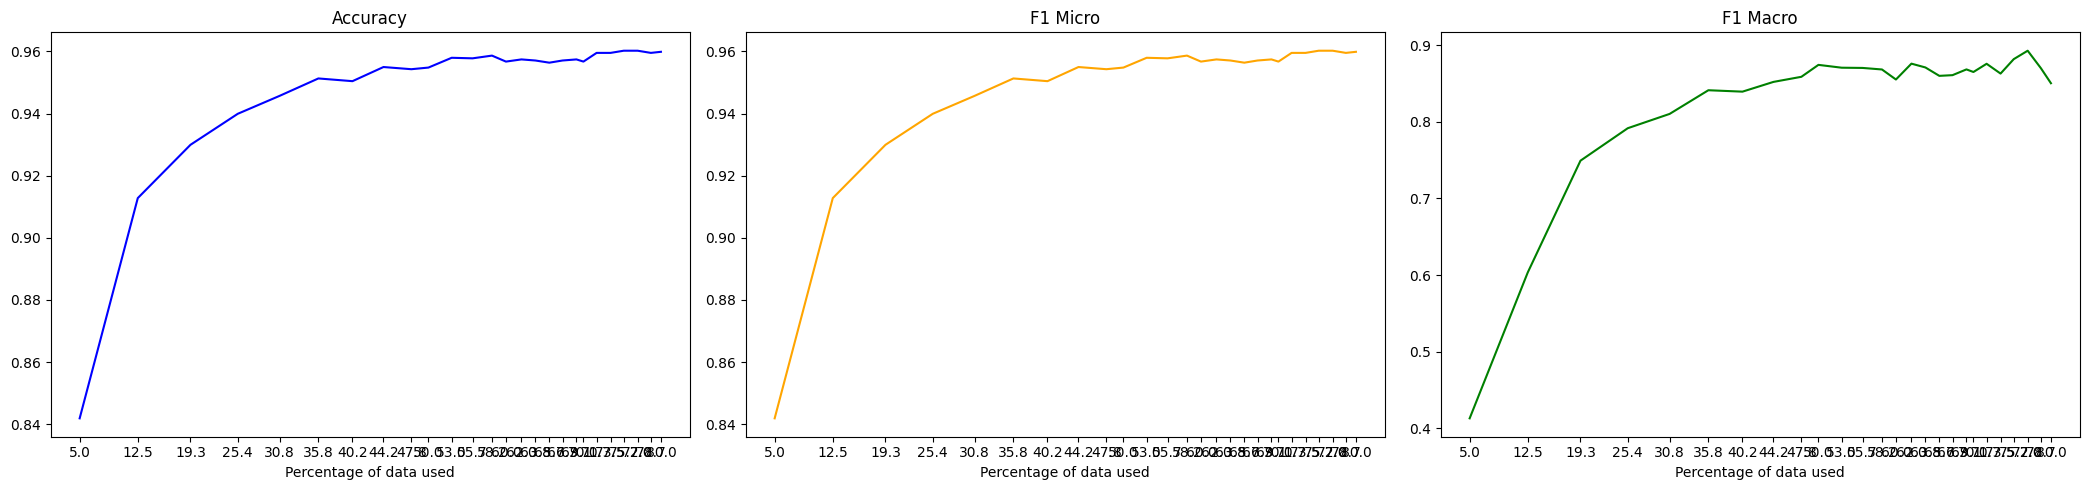

In [22]:
active_learning(seeds[0], 0)

## RUN 2

TRIAL 2
Random seed: 81
Launching training on 2 GPUs.


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6846, Accuracy: 0.7771, F1 Micro: 0.873, F1 Macro: 0.8661
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.5356, Accuracy: 0.8012, F1 Micro: 0.8896, F1 Macro: 0.8852
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4856, Accuracy: 0.8019, F1 Micro: 0.8899, F1 Macro: 0.8853
Epoch 4/10, Train Loss: 0.4451, Accuracy: 0.801, F1 Micro: 0.8895, F1 Macro: 0.8852
Epoch 5/10, Train Loss: 0.447, Accuracy: 0.801, F1 Micro: 0.8895, F1 Macro: 0.8852
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.4104, Accuracy: 0.8038, F1 Micro: 0.8908, F1 Macro: 0.8862
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.4062, Accuracy: 0.8099, F1 Micro: 0.893, F1 Macro: 0.8864
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.4023, Accuracy: 0.8189, F1 Micro: 0.8974, F1 Macro: 0.8906
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.3668, Accuracy: 0.8349, F1 Micro: 0.9047, F1 Macro:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6158, Accuracy: 0.6141, F1 Micro: 0.6141, F1 Macro: 0.3805
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4961, Accuracy: 0.6141, F1 Micro: 0.6141, F1 Macro: 0.3805
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4198, Accuracy: 0.6141, F1 Micro: 0.6141, F1 Macro: 0.3805
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.4426, Accuracy: 0.6141, F1 Micro: 0.6141, F1 Macro: 0.3805
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3147, Accuracy: 0.7391, F1 Micro: 0.7391, F1 Macro: 0.6783
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2361, Accuracy: 0.7636, F1 Micro: 0.7636, F1 Macro: 0.7349
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2395, Accuracy: 0.7663, F1 Micro: 0.7663, F1 Macro: 0.7452
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.2328, Accuracy: 0.7935, F1 Micro: 0.7935, F1 Macro: 0.781
Epoch 9/10, Train Loss: 0.1405, Accuracy: 0.7799, F1 Micr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5973, Accuracy: 0.801, F1 Micro: 0.8895, F1 Macro: 0.8852
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4879, Accuracy: 0.801, F1 Micro: 0.8895, F1 Macro: 0.8852
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4778, Accuracy: 0.8023, F1 Micro: 0.8901, F1 Macro: 0.8857
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.4397, Accuracy: 0.8203, F1 Micro: 0.8987, F1 Macro: 0.8936
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.4026, Accuracy: 0.859, F1 Micro: 0.9181, F1 Macro: 0.9123
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.3551, Accuracy: 0.8885, F1 Micro: 0.9336, F1 Macro: 0.9272
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.309, Accuracy: 0.9017, F1 Micro: 0.9408, F1 Macro: 0.9345
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.2676, Accuracy: 0.9189, F1 Micro: 0.9508, F1 Macro: 0.9467
Higher F1 achieved, saving model
Epoch 9/10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4424, Accuracy: 0.7458, F1 Micro: 0.7458, F1 Macro: 0.4272
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3306, Accuracy: 0.818, F1 Micro: 0.818, F1 Macro: 0.7564
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2536, Accuracy: 0.8368, F1 Micro: 0.8368, F1 Macro: 0.7786
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1977, Accuracy: 0.8391, F1 Micro: 0.8391, F1 Macro: 0.7849
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.134, Accuracy: 0.8557, F1 Micro: 0.8557, F1 Macro: 0.7962
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1173, Accuracy: 0.8635, F1 Micro: 0.8635, F1 Macro: 0.8088
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0531, Accuracy: 0.8646, F1 Micro: 0.8646, F1 Macro: 0.81
Epoch 8/10, Train Loss: 0.0547, Accuracy: 0.8479, F1 Micro: 0.8479, F1 Macro: 0.7962
Epoch 9/10, Train Loss: 0.0796, Accuracy: 0.859, F1 Micro: 0.859, F1 Macro: 0.8051
Epoch 10/10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5539, Accuracy: 0.801, F1 Micro: 0.8895, F1 Macro: 0.8852
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4888, Accuracy: 0.8033, F1 Micro: 0.8906, F1 Macro: 0.8861
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4301, Accuracy: 0.8266, F1 Micro: 0.9009, F1 Macro: 0.8932
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3895, Accuracy: 0.8783, F1 Micro: 0.9282, F1 Macro: 0.9227
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3251, Accuracy: 0.9097, F1 Micro: 0.9455, F1 Macro: 0.9406
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2733, Accuracy: 0.9248, F1 Micro: 0.954, F1 Macro: 0.9497
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.238, Accuracy: 0.9312, F1 Micro: 0.9581, F1 Macro: 0.9552
Epoch 8/10, Train Loss: 0.2051, Accuracy: 0.9311, F1 Micro: 0.958, F1 Macro: 0.9553
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1781, Accuracy: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5527, Accuracy: 0.7621, F1 Micro: 0.7621, F1 Macro: 0.5409
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3696, Accuracy: 0.8579, F1 Micro: 0.8579, F1 Macro: 0.8016
Epoch 3/10, Train Loss: 0.2844, Accuracy: 0.8435, F1 Micro: 0.8435, F1 Macro: 0.7616
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2217, Accuracy: 0.8764, F1 Micro: 0.8764, F1 Macro: 0.8286
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1534, Accuracy: 0.8774, F1 Micro: 0.8774, F1 Macro: 0.8308
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1271, Accuracy: 0.8836, F1 Micro: 0.8836, F1 Macro: 0.8407
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1152, Accuracy: 0.895, F1 Micro: 0.895, F1 Macro: 0.8529
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0601, Accuracy: 0.895, F1 Micro: 0.895, F1 Macro: 0.8552
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0439, Accuracy: 0.8991, F1 Micro: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5645, Accuracy: 0.8068, F1 Micro: 0.8913, F1 Macro: 0.8843
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4766, Accuracy: 0.8151, F1 Micro: 0.8941, F1 Macro: 0.8829
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4186, Accuracy: 0.8625, F1 Micro: 0.9189, F1 Macro: 0.9092
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3386, Accuracy: 0.9102, F1 Micro: 0.9455, F1 Macro: 0.9382
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2738, Accuracy: 0.9266, F1 Micro: 0.9555, F1 Macro: 0.9527
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2383, Accuracy: 0.9312, F1 Micro: 0.9581, F1 Macro: 0.9551
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2085, Accuracy: 0.9382, F1 Micro: 0.9622, F1 Macro: 0.9595
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.18, Accuracy: 0.9479, F1 Micro: 0.9678, F1 Macro: 0.9649
Epoch 9/10, Train Loss: 0.1523, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5202, Accuracy: 0.818, F1 Micro: 0.818, F1 Macro: 0.7549
Epoch 2/10, Train Loss: 0.3115, Accuracy: 0.8125, F1 Micro: 0.8125, F1 Macro: 0.7329
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2546, Accuracy: 0.852, F1 Micro: 0.852, F1 Macro: 0.8084
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.174, Accuracy: 0.8722, F1 Micro: 0.8722, F1 Macro: 0.8402
Epoch 5/10, Train Loss: 0.1398, Accuracy: 0.8695, F1 Micro: 0.8695, F1 Macro: 0.8386
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1177, Accuracy: 0.8869, F1 Micro: 0.8869, F1 Macro: 0.8598
Epoch 7/10, Train Loss: 0.0756, Accuracy: 0.8676, F1 Micro: 0.8676, F1 Macro: 0.8315
Epoch 8/10, Train Loss: 0.0587, Accuracy: 0.8732, F1 Micro: 0.8732, F1 Macro: 0.8378
Epoch 9/10, Train Loss: 0.0889, Accuracy: 0.8759, F1 Micro: 0.8759, F1 Macro: 0.8422
Epoch 10/10, Train Loss: 0.0704, Accuracy: 0.8842, F1 Micro: 0.8842, F1 Macro: 0.8562

Sentiment analysis ac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5513, Accuracy: 0.8052, F1 Micro: 0.8914, F1 Macro: 0.8864
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.472, Accuracy: 0.8193, F1 Micro: 0.8973, F1 Macro: 0.8897
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3935, Accuracy: 0.8965, F1 Micro: 0.9376, F1 Macro: 0.9312
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2974, Accuracy: 0.9312, F1 Micro: 0.958, F1 Macro: 0.9549
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2421, Accuracy: 0.9365, F1 Micro: 0.9611, F1 Macro: 0.9576
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2128, Accuracy: 0.9429, F1 Micro: 0.965, F1 Macro: 0.9628
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1798, Accuracy: 0.9481, F1 Micro: 0.9681, F1 Macro: 0.9657
Epoch 8/10, Train Loss: 0.1574, Accuracy: 0.9451, F1 Micro: 0.9663, F1 Macro: 0.9641
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1338, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4957, Accuracy: 0.8341, F1 Micro: 0.8341, F1 Macro: 0.7898
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3225, Accuracy: 0.8511, F1 Micro: 0.8511, F1 Macro: 0.8008
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2338, Accuracy: 0.8746, F1 Micro: 0.8746, F1 Macro: 0.8407
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1717, Accuracy: 0.8812, F1 Micro: 0.8812, F1 Macro: 0.8435
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1258, Accuracy: 0.8878, F1 Micro: 0.8878, F1 Macro: 0.8562
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1171, Accuracy: 0.8897, F1 Micro: 0.8897, F1 Macro: 0.8559
Epoch 7/10, Train Loss: 0.072, Accuracy: 0.8803, F1 Micro: 0.8803, F1 Macro: 0.8443
Epoch 8/10, Train Loss: 0.0719, Accuracy: 0.885, F1 Micro: 0.885, F1 Macro: 0.8517
Epoch 9/10, Train Loss: 0.0379, Accuracy: 0.886, F1 Micro: 0.886, F1 Macro: 0.8517
Epoch 10/10, Train Loss: 0.0325, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5303, Accuracy: 0.8042, F1 Micro: 0.8908, F1 Macro: 0.8859
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4455, Accuracy: 0.8467, F1 Micro: 0.9112, F1 Macro: 0.9038
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.346, Accuracy: 0.912, F1 Micro: 0.9474, F1 Macro: 0.9438
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2556, Accuracy: 0.928, F1 Micro: 0.9564, F1 Macro: 0.9533
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2183, Accuracy: 0.9396, F1 Micro: 0.9632, F1 Macro: 0.9607
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1889, Accuracy: 0.9455, F1 Micro: 0.9666, F1 Macro: 0.9641
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1612, Accuracy: 0.9474, F1 Micro: 0.9677, F1 Macro: 0.9651
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1389, Accuracy: 0.9521, F1 Micro: 0.9705, F1 Macro: 0.9681
Higher F1 achieved, saving model
Epoch 9/1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4684, Accuracy: 0.8015, F1 Micro: 0.8015, F1 Macro: 0.6864
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3203, Accuracy: 0.861, F1 Micro: 0.861, F1 Macro: 0.8312
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.247, Accuracy: 0.8955, F1 Micro: 0.8955, F1 Macro: 0.8633
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1755, Accuracy: 0.9041, F1 Micro: 0.9041, F1 Macro: 0.8754
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1178, Accuracy: 0.907, F1 Micro: 0.907, F1 Macro: 0.8778
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.094, Accuracy: 0.9128, F1 Micro: 0.9128, F1 Macro: 0.8862
Epoch 7/10, Train Loss: 0.063, Accuracy: 0.908, F1 Micro: 0.908, F1 Macro: 0.8792
Epoch 8/10, Train Loss: 0.0445, Accuracy: 0.908, F1 Micro: 0.908, F1 Macro: 0.8809
Epoch 9/10, Train Loss: 0.0625, Accuracy: 0.9089, F1 Micro: 0.9089, F1 Macro: 0.8826
Epoch 10/10, Train Loss: 0.0279, Accuracy: 0.898

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5199, Accuracy: 0.8049, F1 Micro: 0.8914, F1 Macro: 0.8868
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4212, Accuracy: 0.8717, F1 Micro: 0.9252, F1 Macro: 0.9209
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3095, Accuracy: 0.9276, F1 Micro: 0.9561, F1 Macro: 0.953
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2371, Accuracy: 0.9398, F1 Micro: 0.9632, F1 Macro: 0.9606
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1907, Accuracy: 0.9443, F1 Micro: 0.9659, F1 Macro: 0.9634
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1609, Accuracy: 0.9483, F1 Micro: 0.9682, F1 Macro: 0.9656
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1425, Accuracy: 0.9519, F1 Micro: 0.9704, F1 Macro: 0.968
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1254, Accuracy: 0.9521, F1 Micro: 0.9705, F1 Macro: 0.9686
Higher F1 achieved, saving model
Epoch 9/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.449, Accuracy: 0.8502, F1 Micro: 0.8502, F1 Macro: 0.8
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2901, Accuracy: 0.8664, F1 Micro: 0.8664, F1 Macro: 0.8156
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2237, Accuracy: 0.8664, F1 Micro: 0.8664, F1 Macro: 0.8103
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1642, Accuracy: 0.9027, F1 Micro: 0.9027, F1 Macro: 0.8728
Epoch 5/10, Train Loss: 0.1241, Accuracy: 0.8979, F1 Micro: 0.8979, F1 Macro: 0.8701
Epoch 6/10, Train Loss: 0.079, Accuracy: 0.8969, F1 Micro: 0.8969, F1 Macro: 0.8619
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0682, Accuracy: 0.9036, F1 Micro: 0.9036, F1 Macro: 0.8729
Epoch 8/10, Train Loss: 0.0597, Accuracy: 0.8969, F1 Micro: 0.8969, F1 Macro: 0.8615
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0361, Accuracy: 0.9055, F1 Micro: 0.9055, F1 Macro: 0.8776
Epoch 10/10, Train Loss: 0.0459, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5165, Accuracy: 0.8122, F1 Micro: 0.8943, F1 Macro: 0.8881
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.412, Accuracy: 0.8903, F1 Micro: 0.9352, F1 Macro: 0.93
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2869, Accuracy: 0.9319, F1 Micro: 0.9587, F1 Macro: 0.9558
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2184, Accuracy: 0.9439, F1 Micro: 0.9657, F1 Macro: 0.9634
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1918, Accuracy: 0.9503, F1 Micro: 0.9695, F1 Macro: 0.9674
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1618, Accuracy: 0.9564, F1 Micro: 0.9731, F1 Macro: 0.9707
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1347, Accuracy: 0.9595, F1 Micro: 0.975, F1 Macro: 0.9727
Epoch 8/10, Train Loss: 0.1135, Accuracy: 0.9585, F1 Micro: 0.9743, F1 Macro: 0.9722
Epoch 9/10, Train Loss: 0.0942, Accuracy: 0.9587, F1 Micro: 0.9744, F1 Macro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.431, Accuracy: 0.8561, F1 Micro: 0.8561, F1 Macro: 0.805
Epoch 2/10, Train Loss: 0.3039, Accuracy: 0.8495, F1 Micro: 0.8495, F1 Macro: 0.7821
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2198, Accuracy: 0.8937, F1 Micro: 0.8937, F1 Macro: 0.8603
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1455, Accuracy: 0.8956, F1 Micro: 0.8956, F1 Macro: 0.8637
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1044, Accuracy: 0.8975, F1 Micro: 0.8975, F1 Macro: 0.8625
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.089, Accuracy: 0.8993, F1 Micro: 0.8993, F1 Macro: 0.868
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0745, Accuracy: 0.9059, F1 Micro: 0.9059, F1 Macro: 0.8765
Epoch 8/10, Train Loss: 0.0655, Accuracy: 0.904, F1 Micro: 0.904, F1 Macro: 0.8728
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0474, Accuracy: 0.9059, F1 Micro: 0.9059, F1 Macro: 0.8765
Epoch 10/1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5142, Accuracy: 0.8122, F1 Micro: 0.8943, F1 Macro: 0.8888
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.399, Accuracy: 0.9087, F1 Micro: 0.945, F1 Macro: 0.94
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2719, Accuracy: 0.9361, F1 Micro: 0.9611, F1 Macro: 0.9588
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2168, Accuracy: 0.9446, F1 Micro: 0.9661, F1 Macro: 0.9639
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1731, Accuracy: 0.9502, F1 Micro: 0.9694, F1 Macro: 0.967
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1477, Accuracy: 0.9552, F1 Micro: 0.9723, F1 Macro: 0.9703
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1317, Accuracy: 0.9575, F1 Micro: 0.9736, F1 Macro: 0.9712
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1151, Accuracy: 0.9606, F1 Micro: 0.9755, F1 Macro: 0.9735
Epoch 9/10, Train Loss: 0.0973, Accuracy: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4025, Accuracy: 0.8418, F1 Micro: 0.8418, F1 Macro: 0.8004
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2781, Accuracy: 0.874, F1 Micro: 0.874, F1 Macro: 0.8284
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1952, Accuracy: 0.8878, F1 Micro: 0.8878, F1 Macro: 0.849
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1433, Accuracy: 0.896, F1 Micro: 0.896, F1 Macro: 0.8623
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1119, Accuracy: 0.9034, F1 Micro: 0.9034, F1 Macro: 0.8718
Epoch 6/10, Train Loss: 0.0851, Accuracy: 0.8997, F1 Micro: 0.8997, F1 Macro: 0.8678
Epoch 7/10, Train Loss: 0.057, Accuracy: 0.8988, F1 Micro: 0.8988, F1 Macro: 0.8671
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0537, Accuracy: 0.9089, F1 Micro: 0.9089, F1 Macro: 0.8808
Epoch 9/10, Train Loss: 0.0394, Accuracy: 0.9016, F1 Micro: 0.9016, F1 Macro: 0.8709
Epoch 10/10, Train Loss: 0.0462, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5093, Accuracy: 0.8031, F1 Micro: 0.8905, F1 Macro: 0.8861
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3838, Accuracy: 0.9109, F1 Micro: 0.9465, F1 Macro: 0.942
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.268, Accuracy: 0.9321, F1 Micro: 0.9587, F1 Macro: 0.9557
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2071, Accuracy: 0.9484, F1 Micro: 0.9684, F1 Macro: 0.966
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1747, Accuracy: 0.9519, F1 Micro: 0.9704, F1 Macro: 0.9683
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1448, Accuracy: 0.9533, F1 Micro: 0.9712, F1 Macro: 0.9691
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1254, Accuracy: 0.9571, F1 Micro: 0.9735, F1 Macro: 0.9713
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1064, Accuracy: 0.9589, F1 Micro: 0.9746, F1 Macro: 0.9723
Higher F1 achieved, saving model
Epoch 9/1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3883, Accuracy: 0.8698, F1 Micro: 0.8698, F1 Macro: 0.8248
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2551, Accuracy: 0.8973, F1 Micro: 0.8973, F1 Macro: 0.8631
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2033, Accuracy: 0.9097, F1 Micro: 0.9097, F1 Macro: 0.8806
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1255, Accuracy: 0.9135, F1 Micro: 0.9135, F1 Macro: 0.8871
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0966, Accuracy: 0.9154, F1 Micro: 0.9154, F1 Macro: 0.8895
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0646, Accuracy: 0.9163, F1 Micro: 0.9163, F1 Macro: 0.8885
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0639, Accuracy: 0.9192, F1 Micro: 0.9192, F1 Macro: 0.8955
Epoch 8/10, Train Loss: 0.0369, Accuracy: 0.9125, F1 Micro: 0.9125, F1 Macro: 0.8831
Epoch 9/10, Train Loss: 0.0266, Accuracy: 0.9116, F1 Micro: 0.9116, F1 Macro: 0.8854
High

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5155, Accuracy: 0.8273, F1 Micro: 0.9009, F1 Macro: 0.8927
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3644, Accuracy: 0.9134, F1 Micro: 0.9481, F1 Macro: 0.9446
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2563, Accuracy: 0.9392, F1 Micro: 0.963, F1 Macro: 0.9605
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2023, Accuracy: 0.945, F1 Micro: 0.9664, F1 Macro: 0.9645
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1608, Accuracy: 0.9536, F1 Micro: 0.9714, F1 Macro: 0.969
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1409, Accuracy: 0.9576, F1 Micro: 0.9738, F1 Macro: 0.9712
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1144, Accuracy: 0.9602, F1 Micro: 0.9753, F1 Macro: 0.9732
Epoch 8/10, Train Loss: 0.1028, Accuracy: 0.959, F1 Micro: 0.9746, F1 Macro: 0.9726
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0797, Accuracy: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4255, Accuracy: 0.868, F1 Micro: 0.868, F1 Macro: 0.8227
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.241, Accuracy: 0.8903, F1 Micro: 0.8903, F1 Macro: 0.8562
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1697, Accuracy: 0.9024, F1 Micro: 0.9024, F1 Macro: 0.8716
Epoch 4/10, Train Loss: 0.1462, Accuracy: 0.8987, F1 Micro: 0.8987, F1 Macro: 0.8734
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0926, Accuracy: 0.908, F1 Micro: 0.908, F1 Macro: 0.8784
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.067, Accuracy: 0.9145, F1 Micro: 0.9145, F1 Macro: 0.8887
Epoch 7/10, Train Loss: 0.0368, Accuracy: 0.9089, F1 Micro: 0.9089, F1 Macro: 0.8797
Epoch 8/10, Train Loss: 0.0539, Accuracy: 0.9099, F1 Micro: 0.9099, F1 Macro: 0.8802
Epoch 9/10, Train Loss: 0.0199, Accuracy: 0.9061, F1 Micro: 0.9061, F1 Macro: 0.8771
Epoch 10/10, Train Loss: 0.0225, Accuracy: 0.9117, F1 Micro: 0.9117, F1 Macr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4991, Accuracy: 0.8226, F1 Micro: 0.8981, F1 Macro: 0.8901
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3463, Accuracy: 0.9191, F1 Micro: 0.951, F1 Macro: 0.9466
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2444, Accuracy: 0.9413, F1 Micro: 0.9641, F1 Macro: 0.9614
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1882, Accuracy: 0.9488, F1 Micro: 0.9686, F1 Macro: 0.9668
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1559, Accuracy: 0.9566, F1 Micro: 0.9731, F1 Macro: 0.9703
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1379, Accuracy: 0.9585, F1 Micro: 0.9743, F1 Macro: 0.9722
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1117, Accuracy: 0.9601, F1 Micro: 0.9752, F1 Macro: 0.9728
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0963, Accuracy: 0.9622, F1 Micro: 0.9765, F1 Macro: 0.9747
Epoch 9/10, Train Loss: 0.08, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4093, Accuracy: 0.8573, F1 Micro: 0.8573, F1 Macro: 0.8237
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2382, Accuracy: 0.8879, F1 Micro: 0.8879, F1 Macro: 0.8511
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1737, Accuracy: 0.9055, F1 Micro: 0.9055, F1 Macro: 0.8779
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.126, Accuracy: 0.9092, F1 Micro: 0.9092, F1 Macro: 0.8829
Epoch 5/10, Train Loss: 0.1119, Accuracy: 0.9036, F1 Micro: 0.9036, F1 Macro: 0.8766
Epoch 6/10, Train Loss: 0.0615, Accuracy: 0.9027, F1 Micro: 0.9027, F1 Macro: 0.8777
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0532, Accuracy: 0.912, F1 Micro: 0.912, F1 Macro: 0.8874
Epoch 8/10, Train Loss: 0.0403, Accuracy: 0.911, F1 Micro: 0.911, F1 Macro: 0.8834
Epoch 9/10, Train Loss: 0.0393, Accuracy: 0.9055, F1 Micro: 0.9055, F1 Macro: 0.8761
Epoch 10/10, Train Loss: 0.0313, Accuracy: 0.9027, F1 Micro: 0.9027, F1 Mac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.485, Accuracy: 0.8335, F1 Micro: 0.905, F1 Macro: 0.899
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3319, Accuracy: 0.9189, F1 Micro: 0.9506, F1 Macro: 0.945
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2357, Accuracy: 0.9411, F1 Micro: 0.9641, F1 Macro: 0.9618
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1843, Accuracy: 0.9503, F1 Micro: 0.9694, F1 Macro: 0.9669
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1516, Accuracy: 0.955, F1 Micro: 0.9722, F1 Macro: 0.9698
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1241, Accuracy: 0.9575, F1 Micro: 0.9737, F1 Macro: 0.9715
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1121, Accuracy: 0.9582, F1 Micro: 0.9741, F1 Macro: 0.9717
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0952, Accuracy: 0.9615, F1 Micro: 0.9761, F1 Macro: 0.9737
Higher F1 achieved, saving model
Epoch 9/10,

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3917, Accuracy: 0.8555, F1 Micro: 0.8555, F1 Macro: 0.8046
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2251, Accuracy: 0.8844, F1 Micro: 0.8844, F1 Macro: 0.8481
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1614, Accuracy: 0.8889, F1 Micro: 0.8889, F1 Macro: 0.8514
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1209, Accuracy: 0.9015, F1 Micro: 0.9015, F1 Macro: 0.8742
Epoch 5/10, Train Loss: 0.0843, Accuracy: 0.8889, F1 Micro: 0.8889, F1 Macro: 0.8525
Epoch 6/10, Train Loss: 0.064, Accuracy: 0.8979, F1 Micro: 0.8979, F1 Macro: 0.8676
Epoch 7/10, Train Loss: 0.052, Accuracy: 0.897, F1 Micro: 0.897, F1 Macro: 0.8662
Epoch 8/10, Train Loss: 0.0494, Accuracy: 0.897, F1 Micro: 0.897, F1 Macro: 0.8683
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0363, Accuracy: 0.9015, F1 Micro: 0.9015, F1 Macro: 0.8734
Epoch 10/10, Train Loss: 0.0247, Accuracy: 0.8934, F1 Micro: 0.8934, F1 Macr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4867, Accuracy: 0.8405, F1 Micro: 0.9079, F1 Macro: 0.8996
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3173, Accuracy: 0.9229, F1 Micro: 0.9535, F1 Macro: 0.9504
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2271, Accuracy: 0.9444, F1 Micro: 0.9659, F1 Macro: 0.9634
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1792, Accuracy: 0.9514, F1 Micro: 0.9701, F1 Macro: 0.9678
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1461, Accuracy: 0.958, F1 Micro: 0.9741, F1 Macro: 0.9721
Epoch 6/10, Train Loss: 0.1241, Accuracy: 0.9576, F1 Micro: 0.9737, F1 Macro: 0.9713
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.106, Accuracy: 0.9582, F1 Micro: 0.9742, F1 Macro: 0.9717
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0889, Accuracy: 0.9613, F1 Micro: 0.9759, F1 Macro: 0.9738
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0748, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3972, Accuracy: 0.8545, F1 Micro: 0.8545, F1 Macro: 0.7954
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.236, Accuracy: 0.8888, F1 Micro: 0.8888, F1 Macro: 0.8597
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.173, Accuracy: 0.9018, F1 Micro: 0.9018, F1 Macro: 0.8701
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1098, Accuracy: 0.9166, F1 Micro: 0.9166, F1 Macro: 0.891
Epoch 5/10, Train Loss: 0.0992, Accuracy: 0.9064, F1 Micro: 0.9064, F1 Macro: 0.876
Epoch 6/10, Train Loss: 0.064, Accuracy: 0.911, F1 Micro: 0.911, F1 Macro: 0.8823
Epoch 7/10, Train Loss: 0.0507, Accuracy: 0.912, F1 Micro: 0.912, F1 Macro: 0.8842
Epoch 8/10, Train Loss: 0.0399, Accuracy: 0.9129, F1 Micro: 0.9129, F1 Macro: 0.8867
Epoch 9/10, Train Loss: 0.0286, Accuracy: 0.9073, F1 Micro: 0.9073, F1 Macro: 0.8771
Epoch 10/10, Train Loss: 0.0289, Accuracy: 0.9138, F1 Micro: 0.9138, F1 Macro: 0.8883

Sentiment analysis accura

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4837, Accuracy: 0.8561, F1 Micro: 0.9165, F1 Macro: 0.9103
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3161, Accuracy: 0.9245, F1 Micro: 0.9544, F1 Macro: 0.9514
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2247, Accuracy: 0.947, F1 Micro: 0.9675, F1 Macro: 0.9654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1813, Accuracy: 0.9542, F1 Micro: 0.9717, F1 Macro: 0.9692
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1474, Accuracy: 0.9573, F1 Micro: 0.9736, F1 Macro: 0.9718
Epoch 6/10, Train Loss: 0.1194, Accuracy: 0.955, F1 Micro: 0.9723, F1 Macro: 0.97
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.102, Accuracy: 0.9627, F1 Micro: 0.9768, F1 Macro: 0.9749
Epoch 8/10, Train Loss: 0.0889, Accuracy: 0.9623, F1 Micro: 0.9766, F1 Macro: 0.9745
Epoch 9/10, Train Loss: 0.0734, Accuracy: 0.9609, F1 Micro: 0.9757, F1 Macro: 0.9732
Epoch 10/10, Train Loss: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3837, Accuracy: 0.8607, F1 Micro: 0.8607, F1 Macro: 0.8238
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2293, Accuracy: 0.8808, F1 Micro: 0.8808, F1 Macro: 0.8396
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1747, Accuracy: 0.8964, F1 Micro: 0.8964, F1 Macro: 0.8654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1247, Accuracy: 0.9019, F1 Micro: 0.9019, F1 Macro: 0.8722
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0982, Accuracy: 0.9028, F1 Micro: 0.9028, F1 Macro: 0.8744
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0726, Accuracy: 0.9074, F1 Micro: 0.9074, F1 Macro: 0.8815
Epoch 7/10, Train Loss: 0.0495, Accuracy: 0.9065, F1 Micro: 0.9065, F1 Macro: 0.8802
Epoch 8/10, Train Loss: 0.0528, Accuracy: 0.9028, F1 Micro: 0.9028, F1 Macro: 0.8736
Epoch 9/10, Train Loss: 0.0399, Accuracy: 0.9065, F1 Micro: 0.9065, F1 Macro: 0.8802
Epoch 10/10, Train Loss: 0.0362, Accu

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4893, Accuracy: 0.8476, F1 Micro: 0.9121, F1 Macro: 0.9058
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3159, Accuracy: 0.9297, F1 Micro: 0.9574, F1 Macro: 0.9546
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2246, Accuracy: 0.9451, F1 Micro: 0.9663, F1 Macro: 0.9642
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1739, Accuracy: 0.9563, F1 Micro: 0.973, F1 Macro: 0.9711
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1473, Accuracy: 0.9578, F1 Micro: 0.9739, F1 Macro: 0.9716
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1199, Accuracy: 0.9616, F1 Micro: 0.9762, F1 Macro: 0.9741
Epoch 7/10, Train Loss: 0.1008, Accuracy: 0.9613, F1 Micro: 0.9759, F1 Macro: 0.9735
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0849, Accuracy: 0.9634, F1 Micro: 0.9773, F1 Macro: 0.9751
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0742, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3768, Accuracy: 0.8724, F1 Micro: 0.8724, F1 Macro: 0.8311
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2045, Accuracy: 0.8944, F1 Micro: 0.8944, F1 Macro: 0.87
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1605, Accuracy: 0.9063, F1 Micro: 0.9063, F1 Macro: 0.8777
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1001, Accuracy: 0.9137, F1 Micro: 0.9137, F1 Macro: 0.8893
Epoch 5/10, Train Loss: 0.0729, Accuracy: 0.9082, F1 Micro: 0.9082, F1 Macro: 0.8815
Epoch 6/10, Train Loss: 0.046, Accuracy: 0.9054, F1 Micro: 0.9054, F1 Macro: 0.8786
Epoch 7/10, Train Loss: 0.045, Accuracy: 0.9082, F1 Micro: 0.9082, F1 Macro: 0.8804
Epoch 8/10, Train Loss: 0.0312, Accuracy: 0.9091, F1 Micro: 0.9091, F1 Macro: 0.8809
Epoch 9/10, Train Loss: 0.034, Accuracy: 0.91, F1 Micro: 0.91, F1 Macro: 0.8849
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.018, Accuracy: 0.9174, F1 Micro: 0.9174, F1 Macro: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4747, Accuracy: 0.8646, F1 Micro: 0.9209, F1 Macro: 0.9144
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2989, Accuracy: 0.9345, F1 Micro: 0.9601, F1 Macro: 0.9573
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2111, Accuracy: 0.9498, F1 Micro: 0.9691, F1 Macro: 0.9669
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1679, Accuracy: 0.9523, F1 Micro: 0.9707, F1 Macro: 0.9683
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1355, Accuracy: 0.9545, F1 Micro: 0.9719, F1 Macro: 0.9692
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1182, Accuracy: 0.9575, F1 Micro: 0.9737, F1 Macro: 0.9716
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0982, Accuracy: 0.9604, F1 Micro: 0.9755, F1 Macro: 0.9732
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0811, Accuracy: 0.9618, F1 Micro: 0.9763, F1 Macro: 0.9741
Epoch 9/10, Train Loss: 0.0688, Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3748, Accuracy: 0.8677, F1 Micro: 0.8677, F1 Macro: 0.8287
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2285, Accuracy: 0.8927, F1 Micro: 0.8927, F1 Macro: 0.8662
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1613, Accuracy: 0.913, F1 Micro: 0.913, F1 Macro: 0.8897
Epoch 4/10, Train Loss: 0.1033, Accuracy: 0.9121, F1 Micro: 0.9121, F1 Macro: 0.887
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0871, Accuracy: 0.9149, F1 Micro: 0.9149, F1 Macro: 0.8889
Epoch 6/10, Train Loss: 0.0469, Accuracy: 0.9093, F1 Micro: 0.9093, F1 Macro: 0.8845
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0513, Accuracy: 0.9149, F1 Micro: 0.9149, F1 Macro: 0.8902
Epoch 8/10, Train Loss: 0.0378, Accuracy: 0.914, F1 Micro: 0.914, F1 Macro: 0.8888
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0341, Accuracy: 0.9186, F1 Micro: 0.9186, F1 Macro: 0.8956
Epoch 10/10, Train Loss: 0.0201, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4726, Accuracy: 0.8752, F1 Micro: 0.9254, F1 Macro: 0.916
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2965, Accuracy: 0.9373, F1 Micro: 0.9616, F1 Macro: 0.9586
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2049, Accuracy: 0.9477, F1 Micro: 0.9679, F1 Macro: 0.9656
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1665, Accuracy: 0.9505, F1 Micro: 0.9697, F1 Macro: 0.9676
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1328, Accuracy: 0.9604, F1 Micro: 0.9754, F1 Macro: 0.9729
Epoch 6/10, Train Loss: 0.1147, Accuracy: 0.9583, F1 Micro: 0.9742, F1 Macro: 0.9718
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0953, Accuracy: 0.9644, F1 Micro: 0.9779, F1 Macro: 0.976
Epoch 8/10, Train Loss: 0.0803, Accuracy: 0.9627, F1 Micro: 0.9769, F1 Macro: 0.9747
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0678, Accuracy: 0.9653, F1 Micro: 0.9785, F1 Mac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3445, Accuracy: 0.8741, F1 Micro: 0.8741, F1 Macro: 0.8365
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2005, Accuracy: 0.9028, F1 Micro: 0.9028, F1 Macro: 0.8742
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1498, Accuracy: 0.9139, F1 Micro: 0.9139, F1 Macro: 0.89
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.0965, Accuracy: 0.9157, F1 Micro: 0.9157, F1 Macro: 0.8899
Epoch 5/10, Train Loss: 0.0752, Accuracy: 0.913, F1 Micro: 0.913, F1 Macro: 0.8872
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0519, Accuracy: 0.9157, F1 Micro: 0.9157, F1 Macro: 0.8938
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0551, Accuracy: 0.9176, F1 Micro: 0.9176, F1 Macro: 0.895
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.031, Accuracy: 0.9176, F1 Micro: 0.9176, F1 Macro: 0.8938
Epoch 9/10, Train Loss: 0.0184, Accuracy: 0.9148, F1 Micro: 0.9148, F1 Macro: 0.8888
Epoch 10/1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4758, Accuracy: 0.8691, F1 Micro: 0.9233, F1 Macro: 0.9186
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2953, Accuracy: 0.9276, F1 Micro: 0.956, F1 Macro: 0.953
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2045, Accuracy: 0.9455, F1 Micro: 0.9665, F1 Macro: 0.9632
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1648, Accuracy: 0.9549, F1 Micro: 0.972, F1 Macro: 0.9696
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1355, Accuracy: 0.9576, F1 Micro: 0.9739, F1 Macro: 0.9718
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1152, Accuracy: 0.9595, F1 Micro: 0.9751, F1 Macro: 0.9729
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0943, Accuracy: 0.9628, F1 Micro: 0.977, F1 Macro: 0.9751
Epoch 8/10, Train Loss: 0.0772, Accuracy: 0.9613, F1 Micro: 0.976, F1 Macro: 0.974
Epoch 9/10, Train Loss: 0.0667, Accuracy: 0.9628, F1 Micro: 0.9769, F1 Macro: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.35, Accuracy: 0.8731, F1 Micro: 0.8731, F1 Macro: 0.8357
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2157, Accuracy: 0.8922, F1 Micro: 0.8922, F1 Macro: 0.8568
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1477, Accuracy: 0.9005, F1 Micro: 0.9005, F1 Macro: 0.8706
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.108, Accuracy: 0.9059, F1 Micro: 0.9059, F1 Macro: 0.8796
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0684, Accuracy: 0.9114, F1 Micro: 0.9114, F1 Macro: 0.8838
Epoch 6/10, Train Loss: 0.0593, Accuracy: 0.9032, F1 Micro: 0.9032, F1 Macro: 0.8716
Epoch 7/10, Train Loss: 0.0484, Accuracy: 0.905, F1 Micro: 0.905, F1 Macro: 0.877
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0344, Accuracy: 0.9142, F1 Micro: 0.9142, F1 Macro: 0.889
Epoch 9/10, Train Loss: 0.0278, Accuracy: 0.9032, F1 Micro: 0.9032, F1 Macro: 0.8713
Epoch 10/10, Train Loss: 0.0223, Accuracy: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4692, Accuracy: 0.8795, F1 Micro: 0.9289, F1 Macro: 0.9229
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2896, Accuracy: 0.9361, F1 Micro: 0.9612, F1 Macro: 0.9587
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1996, Accuracy: 0.949, F1 Micro: 0.9686, F1 Macro: 0.9663
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1639, Accuracy: 0.9549, F1 Micro: 0.9721, F1 Macro: 0.9695
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1347, Accuracy: 0.959, F1 Micro: 0.9746, F1 Macro: 0.9724
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1124, Accuracy: 0.9604, F1 Micro: 0.9755, F1 Macro: 0.9733
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0926, Accuracy: 0.9658, F1 Micro: 0.9788, F1 Macro: 0.9767
Epoch 8/10, Train Loss: 0.0777, Accuracy: 0.9637, F1 Micro: 0.9774, F1 Macro: 0.9754
Epoch 9/10, Train Loss: 0.0637, Accuracy: 0.9644, F1 Micro: 0.9779, F1 Mac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3608, Accuracy: 0.8532, F1 Micro: 0.8532, F1 Macro: 0.7924
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2152, Accuracy: 0.8927, F1 Micro: 0.8927, F1 Macro: 0.8562
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1218, Accuracy: 0.911, F1 Micro: 0.911, F1 Macro: 0.8862
Epoch 4/10, Train Loss: 0.1046, Accuracy: 0.9037, F1 Micro: 0.9037, F1 Macro: 0.8791
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0713, Accuracy: 0.9138, F1 Micro: 0.9138, F1 Macro: 0.8903
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0479, Accuracy: 0.9174, F1 Micro: 0.9174, F1 Macro: 0.8929
Epoch 7/10, Train Loss: 0.0506, Accuracy: 0.9083, F1 Micro: 0.9083, F1 Macro: 0.8836
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0336, Accuracy: 0.9174, F1 Micro: 0.9174, F1 Macro: 0.8929
Epoch 9/10, Train Loss: 0.0265, Accuracy: 0.9083, F1 Micro: 0.9083, F1 Macro: 0.885
Epoch 10/10, Train Loss: 0.026, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4677, Accuracy: 0.8658, F1 Micro: 0.9217, F1 Macro: 0.9159
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2859, Accuracy: 0.9382, F1 Micro: 0.962, F1 Macro: 0.9589
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2051, Accuracy: 0.951, F1 Micro: 0.9699, F1 Macro: 0.9679
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1608, Accuracy: 0.9556, F1 Micro: 0.9726, F1 Macro: 0.9704
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1314, Accuracy: 0.9613, F1 Micro: 0.976, F1 Macro: 0.9741
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1084, Accuracy: 0.9644, F1 Micro: 0.9779, F1 Macro: 0.9757
Epoch 7/10, Train Loss: 0.091, Accuracy: 0.9602, F1 Micro: 0.9754, F1 Macro: 0.9735
Epoch 8/10, Train Loss: 0.0768, Accuracy: 0.9639, F1 Micro: 0.9776, F1 Macro: 0.9755
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0664, Accuracy: 0.9644, F1 Micro: 0.9779, F1 Macro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3388, Accuracy: 0.876, F1 Micro: 0.876, F1 Macro: 0.8327
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1851, Accuracy: 0.8993, F1 Micro: 0.8993, F1 Macro: 0.8698
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.135, Accuracy: 0.9077, F1 Micro: 0.9077, F1 Macro: 0.8774
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.0906, Accuracy: 0.9189, F1 Micro: 0.9189, F1 Macro: 0.8928
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0692, Accuracy: 0.9189, F1 Micro: 0.9189, F1 Macro: 0.8943
Epoch 6/10, Train Loss: 0.0566, Accuracy: 0.9059, F1 Micro: 0.9059, F1 Macro: 0.8743
Epoch 7/10, Train Loss: 0.0424, Accuracy: 0.9124, F1 Micro: 0.9124, F1 Macro: 0.8867
Epoch 8/10, Train Loss: 0.0263, Accuracy: 0.9161, F1 Micro: 0.9161, F1 Macro: 0.8875
Epoch 9/10, Train Loss: 0.0237, Accuracy: 0.918, F1 Micro: 0.918, F1 Macro: 0.8911
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0176, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.455, Accuracy: 0.8804, F1 Micro: 0.93, F1 Macro: 0.9257
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2754, Accuracy: 0.9356, F1 Micro: 0.9609, F1 Macro: 0.9586
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1924, Accuracy: 0.9495, F1 Micro: 0.969, F1 Macro: 0.9669
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1541, Accuracy: 0.9564, F1 Micro: 0.9731, F1 Macro: 0.971
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.128, Accuracy: 0.9618, F1 Micro: 0.9763, F1 Macro: 0.9742
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1071, Accuracy: 0.9634, F1 Micro: 0.9773, F1 Macro: 0.9753
Epoch 7/10, Train Loss: 0.0926, Accuracy: 0.963, F1 Micro: 0.9771, F1 Macro: 0.9748
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0741, Accuracy: 0.9646, F1 Micro: 0.978, F1 Macro: 0.9759
Epoch 9/10, Train Loss: 0.0623, Accuracy: 0.9635, F1 Micro: 0.9774, F1 Macro: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3536, Accuracy: 0.8711, F1 Micro: 0.8711, F1 Macro: 0.8379
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1933, Accuracy: 0.9004, F1 Micro: 0.9004, F1 Macro: 0.8726
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1335, Accuracy: 0.9022, F1 Micro: 0.9022, F1 Macro: 0.8723
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1024, Accuracy: 0.9086, F1 Micro: 0.9086, F1 Macro: 0.8791
Epoch 5/10, Train Loss: 0.0688, Accuracy: 0.9031, F1 Micro: 0.9031, F1 Macro: 0.8793
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0548, Accuracy: 0.9113, F1 Micro: 0.9113, F1 Macro: 0.8845
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0387, Accuracy: 0.9132, F1 Micro: 0.9132, F1 Macro: 0.8856
Epoch 8/10, Train Loss: 0.0374, Accuracy: 0.9113, F1 Micro: 0.9113, F1 Macro: 0.8868
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0358, Accuracy: 0.915, F1 Micro: 0.915, F1 Macro: 0.8888
Higher

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4592, Accuracy: 0.8837, F1 Micro: 0.9311, F1 Macro: 0.9251
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2712, Accuracy: 0.9349, F1 Micro: 0.9605, F1 Macro: 0.9583
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1943, Accuracy: 0.9472, F1 Micro: 0.9677, F1 Macro: 0.9655
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1553, Accuracy: 0.9568, F1 Micro: 0.9734, F1 Macro: 0.9715
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1218, Accuracy: 0.9613, F1 Micro: 0.976, F1 Macro: 0.9737
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1037, Accuracy: 0.9622, F1 Micro: 0.9766, F1 Macro: 0.9746
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0864, Accuracy: 0.9628, F1 Micro: 0.9769, F1 Macro: 0.9744
Epoch 8/10, Train Loss: 0.0719, Accuracy: 0.9627, F1 Micro: 0.9768, F1 Macro: 0.9746
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0623, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3219, Accuracy: 0.8579, F1 Micro: 0.8579, F1 Macro: 0.8041
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2002, Accuracy: 0.8973, F1 Micro: 0.8973, F1 Macro: 0.8632
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1223, Accuracy: 0.9065, F1 Micro: 0.9065, F1 Macro: 0.876
Epoch 4/10, Train Loss: 0.088, Accuracy: 0.9047, F1 Micro: 0.9047, F1 Macro: 0.873
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0802, Accuracy: 0.9157, F1 Micro: 0.9157, F1 Macro: 0.8903
Epoch 6/10, Train Loss: 0.0521, Accuracy: 0.9148, F1 Micro: 0.9148, F1 Macro: 0.8884
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0329, Accuracy: 0.9175, F1 Micro: 0.9175, F1 Macro: 0.8931
Epoch 8/10, Train Loss: 0.0303, Accuracy: 0.9138, F1 Micro: 0.9138, F1 Macro: 0.886
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.027, Accuracy: 0.9184, F1 Micro: 0.9184, F1 Macro: 0.8937
Epoch 10/10, Train Loss: 0.0255, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4522, Accuracy: 0.8844, F1 Micro: 0.9314, F1 Macro: 0.9258
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2655, Accuracy: 0.9406, F1 Micro: 0.9637, F1 Macro: 0.9613
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1872, Accuracy: 0.9502, F1 Micro: 0.9695, F1 Macro: 0.9674
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1538, Accuracy: 0.9578, F1 Micro: 0.974, F1 Macro: 0.9719
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1239, Accuracy: 0.9613, F1 Micro: 0.9761, F1 Macro: 0.9745
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1016, Accuracy: 0.9648, F1 Micro: 0.9781, F1 Macro: 0.976
Epoch 7/10, Train Loss: 0.0847, Accuracy: 0.9641, F1 Micro: 0.9777, F1 Macro: 0.9754
Epoch 8/10, Train Loss: 0.0717, Accuracy: 0.9644, F1 Micro: 0.9779, F1 Macro: 0.9759
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0598, Accuracy: 0.9649, F1 Micro: 0.9782, F1 Mac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3549, Accuracy: 0.8659, F1 Micro: 0.8659, F1 Macro: 0.8192
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.19, Accuracy: 0.9005, F1 Micro: 0.9005, F1 Macro: 0.8709
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1448, Accuracy: 0.9069, F1 Micro: 0.9069, F1 Macro: 0.8834
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.0898, Accuracy: 0.9088, F1 Micro: 0.9088, F1 Macro: 0.882
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0595, Accuracy: 0.9088, F1 Micro: 0.9088, F1 Macro: 0.8843
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0573, Accuracy: 0.9124, F1 Micro: 0.9124, F1 Macro: 0.8889
Epoch 7/10, Train Loss: 0.0356, Accuracy: 0.9069, F1 Micro: 0.9069, F1 Macro: 0.8812
Epoch 8/10, Train Loss: 0.0432, Accuracy: 0.9115, F1 Micro: 0.9115, F1 Macro: 0.8872
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0317, Accuracy: 0.9142, F1 Micro: 0.9142, F1 Macro: 0.8903
Higher 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4526, Accuracy: 0.8889, F1 Micro: 0.934, F1 Macro: 0.9289
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2608, Accuracy: 0.9365, F1 Micro: 0.9613, F1 Macro: 0.9589
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1841, Accuracy: 0.9528, F1 Micro: 0.971, F1 Macro: 0.969
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1484, Accuracy: 0.9545, F1 Micro: 0.9719, F1 Macro: 0.9698
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1194, Accuracy: 0.9618, F1 Micro: 0.9763, F1 Macro: 0.9746
Epoch 6/10, Train Loss: 0.1035, Accuracy: 0.9608, F1 Micro: 0.9756, F1 Macro: 0.9733
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0844, Accuracy: 0.9635, F1 Micro: 0.9774, F1 Macro: 0.9754
Epoch 8/10, Train Loss: 0.0687, Accuracy: 0.9625, F1 Micro: 0.9768, F1 Macro: 0.9747
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0579, Accuracy: 0.9642, F1 Micro: 0.9778, F1 Macr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3387, Accuracy: 0.869, F1 Micro: 0.869, F1 Macro: 0.8316
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.203, Accuracy: 0.9033, F1 Micro: 0.9033, F1 Macro: 0.8759
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1394, Accuracy: 0.9108, F1 Micro: 0.9108, F1 Macro: 0.8822
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.0944, Accuracy: 0.9164, F1 Micro: 0.9164, F1 Macro: 0.8909
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.076, Accuracy: 0.9164, F1 Micro: 0.9164, F1 Macro: 0.8898
Epoch 6/10, Train Loss: 0.0436, Accuracy: 0.9099, F1 Micro: 0.9099, F1 Macro: 0.8846
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.057, Accuracy: 0.9201, F1 Micro: 0.9201, F1 Macro: 0.8971
Epoch 8/10, Train Loss: 0.0349, Accuracy: 0.9164, F1 Micro: 0.9164, F1 Macro: 0.8896
Epoch 9/10, Train Loss: 0.0266, Accuracy: 0.9164, F1 Micro: 0.9164, F1 Macro: 0.8904
Epoch 10/10, Train Loss: 0.0214, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4466, Accuracy: 0.8861, F1 Micro: 0.9329, F1 Macro: 0.9285
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.264, Accuracy: 0.9432, F1 Micro: 0.9653, F1 Macro: 0.963
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1807, Accuracy: 0.9531, F1 Micro: 0.9712, F1 Macro: 0.9693
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1478, Accuracy: 0.9554, F1 Micro: 0.9724, F1 Macro: 0.9703
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1204, Accuracy: 0.9627, F1 Micro: 0.9769, F1 Macro: 0.9748
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0989, Accuracy: 0.9646, F1 Micro: 0.978, F1 Macro: 0.976
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0783, Accuracy: 0.9648, F1 Micro: 0.9781, F1 Macro: 0.9761
Epoch 8/10, Train Loss: 0.0693, Accuracy: 0.9642, F1 Micro: 0.9778, F1 Macro: 0.9757
Epoch 9/10, Train Loss: 0.0569, Accuracy: 0.9639, F1 Micro: 0.9776, F1 Macro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3406, Accuracy: 0.8699, F1 Micro: 0.8699, F1 Macro: 0.8255
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1768, Accuracy: 0.9077, F1 Micro: 0.9077, F1 Macro: 0.8799
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1459, Accuracy: 0.9114, F1 Micro: 0.9114, F1 Macro: 0.8839
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.0988, Accuracy: 0.9133, F1 Micro: 0.9133, F1 Macro: 0.8868
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.064, Accuracy: 0.9142, F1 Micro: 0.9142, F1 Macro: 0.8877
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0735, Accuracy: 0.9216, F1 Micro: 0.9216, F1 Macro: 0.8968
Epoch 7/10, Train Loss: 0.0501, Accuracy: 0.9124, F1 Micro: 0.9124, F1 Macro: 0.8836
Epoch 8/10, Train Loss: 0.0243, Accuracy: 0.9142, F1 Micro: 0.9142, F1 Macro: 0.8899
Epoch 9/10, Train Loss: 0.0253, Accuracy: 0.917, F1 Micro: 0.917, F1 Macro: 0.8906
Epoch 10/10, Train Loss: 0.0181, Accurac

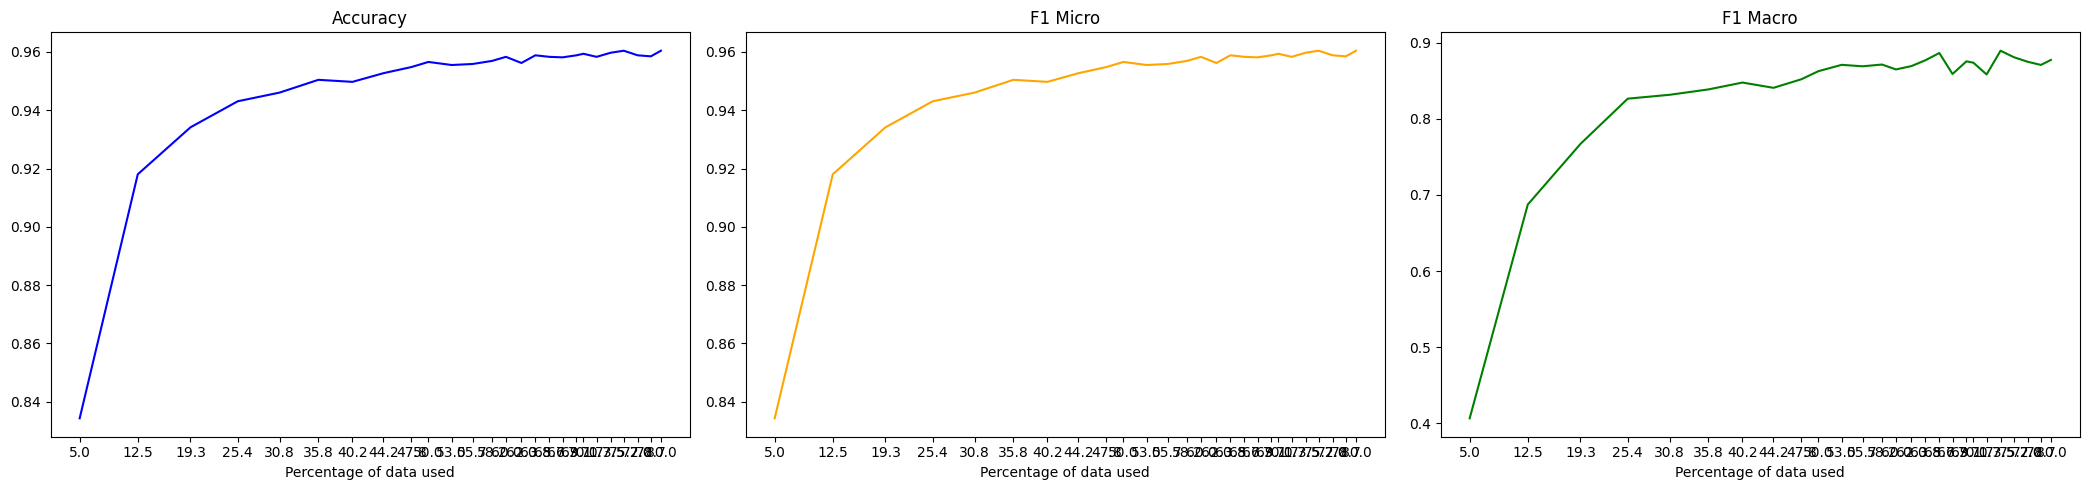

In [ ]:
active_learning(seeds[1], 1)

## RUN 3

TRIAL 3
Random seed: 14
Launching training on 2 GPUs.


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6341, Accuracy: 0.7974, F1 Micro: 0.8859, F1 Macro: 0.8768
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.5134, Accuracy: 0.8014, F1 Micro: 0.8897, F1 Macro: 0.8853
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4829, Accuracy: 0.8017, F1 Micro: 0.8897, F1 Macro: 0.885
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.4632, Accuracy: 0.8045, F1 Micro: 0.8906, F1 Macro: 0.8847
Epoch 5/10, Train Loss: 0.4642, Accuracy: 0.8047, F1 Micro: 0.8903, F1 Macro: 0.8835
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.4501, Accuracy: 0.8075, F1 Micro: 0.891, F1 Macro: 0.8822
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.451, Accuracy: 0.8149, F1 Micro: 0.8947, F1 Macro: 0.8862
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.4034, Accuracy: 0.8273, F1 Micro: 0.9007, F1 Macro: 0.892
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.3957, Accuracy: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.7316, Accuracy: 0.5412, F1 Micro: 0.5412, F1 Macro: 0.3512
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.612, Accuracy: 0.5412, F1 Micro: 0.5412, F1 Macro: 0.3512
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.5437, Accuracy: 0.5645, F1 Micro: 0.5645, F1 Macro: 0.4185
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.5596, Accuracy: 0.5751, F1 Micro: 0.5751, F1 Macro: 0.4522
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.4998, Accuracy: 0.5877, F1 Micro: 0.5877, F1 Macro: 0.5659
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.478, Accuracy: 0.6025, F1 Micro: 0.6025, F1 Macro: 0.5626
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.3806, Accuracy: 0.666, F1 Micro: 0.666, F1 Macro: 0.6564
Epoch 8/10, Train Loss: 0.3522, Accuracy: 0.6195, F1 Micro: 0.6195, F1 Macro: 0.5823
Epoch 9/10, Train Loss: 0.3548, Accuracy: 0.6575, F1 Micro: 0.6575, F1 Macro: 0.6482
Epoch 10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.553, Accuracy: 0.801, F1 Micro: 0.8895, F1 Macro: 0.8852
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.437, Accuracy: 0.801, F1 Micro: 0.8895, F1 Macro: 0.8852
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4232, Accuracy: 0.8019, F1 Micro: 0.8899, F1 Macro: 0.8853
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.4113, Accuracy: 0.8109, F1 Micro: 0.8932, F1 Macro: 0.8859
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3647, Accuracy: 0.8523, F1 Micro: 0.9144, F1 Macro: 0.9079
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.3096, Accuracy: 0.8875, F1 Micro: 0.9329, F1 Macro: 0.9257
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2672, Accuracy: 0.8977, F1 Micro: 0.939, F1 Macro: 0.9343
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.2208, Accuracy: 0.9187, F1 Micro: 0.9509, F1 Macro: 0.9469
Higher F1 achieved, saving model
Epoch 9/10,

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5739, Accuracy: 0.7205, F1 Micro: 0.7205, F1 Macro: 0.4188
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.47, Accuracy: 0.7614, F1 Micro: 0.7614, F1 Macro: 0.5616
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.297, Accuracy: 0.8295, F1 Micro: 0.8295, F1 Macro: 0.7905
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2248, Accuracy: 0.8614, F1 Micro: 0.8614, F1 Macro: 0.8117
Epoch 5/10, Train Loss: 0.1512, Accuracy: 0.858, F1 Micro: 0.858, F1 Macro: 0.812
Epoch 6/10, Train Loss: 0.149, Accuracy: 0.8602, F1 Micro: 0.8602, F1 Macro: 0.8145
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1448, Accuracy: 0.867, F1 Micro: 0.867, F1 Macro: 0.8219
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1012, Accuracy: 0.8693, F1 Micro: 0.8693, F1 Macro: 0.8244
Epoch 9/10, Train Loss: 0.0879, Accuracy: 0.8659, F1 Micro: 0.8659, F1 Macro: 0.8305
Higher F1 achieved, saving model
Epoch 10/10, 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5161, Accuracy: 0.801, F1 Micro: 0.8895, F1 Macro: 0.8852
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4342, Accuracy: 0.805, F1 Micro: 0.8914, F1 Macro: 0.8871
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4134, Accuracy: 0.8196, F1 Micro: 0.8983, F1 Macro: 0.8944
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3681, Accuracy: 0.8562, F1 Micro: 0.9168, F1 Macro: 0.9127
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3087, Accuracy: 0.8899, F1 Micro: 0.9348, F1 Macro: 0.9311
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2625, Accuracy: 0.9092, F1 Micro: 0.9454, F1 Macro: 0.9417
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2112, Accuracy: 0.9286, F1 Micro: 0.9567, F1 Macro: 0.9535
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1806, Accuracy: 0.9335, F1 Micro: 0.9597, F1 Macro: 0.9565
Higher F1 achieved, saving model
Epoch 9/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5568, Accuracy: 0.7531, F1 Micro: 0.7531, F1 Macro: 0.5887
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4134, Accuracy: 0.7958, F1 Micro: 0.7958, F1 Macro: 0.6746
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3177, Accuracy: 0.8167, F1 Micro: 0.8167, F1 Macro: 0.7878
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2444, Accuracy: 0.851, F1 Micro: 0.851, F1 Macro: 0.7941
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2197, Accuracy: 0.875, F1 Micro: 0.875, F1 Macro: 0.8329
Epoch 6/10, Train Loss: 0.192, Accuracy: 0.8729, F1 Micro: 0.8729, F1 Macro: 0.8406
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1838, Accuracy: 0.8865, F1 Micro: 0.8865, F1 Macro: 0.8571
Epoch 8/10, Train Loss: 0.1529, Accuracy: 0.8833, F1 Micro: 0.8833, F1 Macro: 0.8512
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0867, Accuracy: 0.8969, F1 Micro: 0.8969, F1 Macro: 0.8663
Epoch 10/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5278, Accuracy: 0.8033, F1 Micro: 0.8905, F1 Macro: 0.8856
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4666, Accuracy: 0.8116, F1 Micro: 0.8946, F1 Macro: 0.8903
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4056, Accuracy: 0.8583, F1 Micro: 0.9179, F1 Macro: 0.9135
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3283, Accuracy: 0.9047, F1 Micro: 0.9432, F1 Macro: 0.9394
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2777, Accuracy: 0.9286, F1 Micro: 0.9567, F1 Macro: 0.953
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2263, Accuracy: 0.9399, F1 Micro: 0.9634, F1 Macro: 0.9607
Epoch 7/10, Train Loss: 0.1919, Accuracy: 0.9389, F1 Micro: 0.9627, F1 Macro: 0.9604
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1694, Accuracy: 0.945, F1 Micro: 0.9663, F1 Macro: 0.9634
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1455, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5476, Accuracy: 0.7965, F1 Micro: 0.7965, F1 Macro: 0.671
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3706, Accuracy: 0.8633, F1 Micro: 0.8633, F1 Macro: 0.8224
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3331, Accuracy: 0.8692, F1 Micro: 0.8692, F1 Macro: 0.8293
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2503, Accuracy: 0.8761, F1 Micro: 0.8761, F1 Macro: 0.8356
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1889, Accuracy: 0.8938, F1 Micro: 0.8938, F1 Macro: 0.8642
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1303, Accuracy: 0.9027, F1 Micro: 0.9027, F1 Macro: 0.8732
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1162, Accuracy: 0.9056, F1 Micro: 0.9056, F1 Macro: 0.8778
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0876, Accuracy: 0.9076, F1 Micro: 0.9076, F1 Macro: 0.8818
Epoch 9/10, Train Loss: 0.0643, Accuracy: 0.8997, F1 Micr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5218, Accuracy: 0.8033, F1 Micro: 0.8906, F1 Macro: 0.8861
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4456, Accuracy: 0.8306, F1 Micro: 0.9038, F1 Macro: 0.8991
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.379, Accuracy: 0.8858, F1 Micro: 0.9327, F1 Macro: 0.9287
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2878, Accuracy: 0.9264, F1 Micro: 0.9555, F1 Macro: 0.9523
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2392, Accuracy: 0.9411, F1 Micro: 0.9641, F1 Macro: 0.9613
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.199, Accuracy: 0.9413, F1 Micro: 0.9642, F1 Macro: 0.9611
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1696, Accuracy: 0.9464, F1 Micro: 0.9672, F1 Macro: 0.9644
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1466, Accuracy: 0.9521, F1 Micro: 0.9705, F1 Macro: 0.9676
Higher F1 achieved, saving model
Epoch 9/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5371, Accuracy: 0.84, F1 Micro: 0.84, F1 Macro: 0.7954
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3599, Accuracy: 0.8693, F1 Micro: 0.8693, F1 Macro: 0.837
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.273, Accuracy: 0.8958, F1 Micro: 0.8958, F1 Macro: 0.8678
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2195, Accuracy: 0.8987, F1 Micro: 0.8987, F1 Macro: 0.8748
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1488, Accuracy: 0.8996, F1 Micro: 0.8996, F1 Macro: 0.8709
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1169, Accuracy: 0.9034, F1 Micro: 0.9034, F1 Macro: 0.878
Epoch 7/10, Train Loss: 0.0874, Accuracy: 0.8968, F1 Micro: 0.8968, F1 Macro: 0.87
Epoch 8/10, Train Loss: 0.0766, Accuracy: 0.9015, F1 Micro: 0.9015, F1 Macro: 0.8739
Epoch 9/10, Train Loss: 0.0593, Accuracy: 0.8977, F1 Micro: 0.8977, F1 Macro: 0.8702
Epoch 10/10, Train Loss: 0.0466, Accuracy: 0.8

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5135, Accuracy: 0.8043, F1 Micro: 0.8908, F1 Macro: 0.8857
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4492, Accuracy: 0.8472, F1 Micro: 0.9115, F1 Macro: 0.9049
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3573, Accuracy: 0.9155, F1 Micro: 0.949, F1 Macro: 0.9453
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2712, Accuracy: 0.9345, F1 Micro: 0.9601, F1 Macro: 0.9569
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.22, Accuracy: 0.9446, F1 Micro: 0.9661, F1 Macro: 0.9635
Epoch 6/10, Train Loss: 0.1828, Accuracy: 0.9441, F1 Micro: 0.9659, F1 Macro: 0.9628
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1542, Accuracy: 0.9517, F1 Micro: 0.9703, F1 Macro: 0.9677
Epoch 8/10, Train Loss: 0.1332, Accuracy: 0.946, F1 Micro: 0.967, F1 Macro: 0.9644
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1155, Accuracy: 0.9528, F1 Micro: 0.971, F1 Macro: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5272, Accuracy: 0.8634, F1 Micro: 0.8634, F1 Macro: 0.8098
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3359, Accuracy: 0.8752, F1 Micro: 0.8752, F1 Macro: 0.8298
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2563, Accuracy: 0.9099, F1 Micro: 0.9099, F1 Macro: 0.8829
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1834, Accuracy: 0.9099, F1 Micro: 0.9099, F1 Macro: 0.8838
Epoch 5/10, Train Loss: 0.1554, Accuracy: 0.9079, F1 Micro: 0.9079, F1 Macro: 0.8762
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1139, Accuracy: 0.9139, F1 Micro: 0.9139, F1 Macro: 0.8869
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0622, Accuracy: 0.9238, F1 Micro: 0.9238, F1 Macro: 0.9026
Epoch 8/10, Train Loss: 0.0669, Accuracy: 0.9208, F1 Micro: 0.9208, F1 Macro: 0.8977
Epoch 9/10, Train Loss: 0.0725, Accuracy: 0.904, F1 Micro: 0.904, F1 Macro: 0.8713
Epoch 10/10, Train Loss: 0.054, Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5147, Accuracy: 0.8054, F1 Micro: 0.8896, F1 Macro: 0.8795
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4239, Accuracy: 0.8722, F1 Micro: 0.9251, F1 Macro: 0.9201
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3174, Accuracy: 0.9264, F1 Micro: 0.9554, F1 Macro: 0.9519
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2455, Accuracy: 0.9441, F1 Micro: 0.9657, F1 Macro: 0.9629
Epoch 5/10, Train Loss: 0.2027, Accuracy: 0.9411, F1 Micro: 0.9641, F1 Macro: 0.9611
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1677, Accuracy: 0.946, F1 Micro: 0.967, F1 Macro: 0.9645
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1386, Accuracy: 0.9526, F1 Micro: 0.9709, F1 Macro: 0.9685
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1228, Accuracy: 0.9538, F1 Micro: 0.9716, F1 Macro: 0.969
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1081, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4807, Accuracy: 0.8204, F1 Micro: 0.8204, F1 Macro: 0.7289
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2915, Accuracy: 0.8728, F1 Micro: 0.8728, F1 Macro: 0.8347
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2345, Accuracy: 0.8906, F1 Micro: 0.8906, F1 Macro: 0.8549
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1552, Accuracy: 0.8915, F1 Micro: 0.8915, F1 Macro: 0.857
Epoch 5/10, Train Loss: 0.1218, Accuracy: 0.8831, F1 Micro: 0.8831, F1 Macro: 0.8418
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0762, Accuracy: 0.899, F1 Micro: 0.899, F1 Macro: 0.8672
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0758, Accuracy: 0.8999, F1 Micro: 0.8999, F1 Macro: 0.8689
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.065, Accuracy: 0.9083, F1 Micro: 0.9083, F1 Macro: 0.8809
Epoch 9/10, Train Loss: 0.0376, Accuracy: 0.898, F1 Micro: 0.898, F1 Macro: 0.8683
Epoch 10/1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5041, Accuracy: 0.8076, F1 Micro: 0.8911, F1 Macro: 0.8822
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4053, Accuracy: 0.8894, F1 Micro: 0.9347, F1 Macro: 0.9303
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2901, Accuracy: 0.9306, F1 Micro: 0.9579, F1 Macro: 0.9553
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2195, Accuracy: 0.9462, F1 Micro: 0.967, F1 Macro: 0.9643
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1818, Accuracy: 0.9535, F1 Micro: 0.9714, F1 Macro: 0.9687
Epoch 6/10, Train Loss: 0.1521, Accuracy: 0.9531, F1 Micro: 0.9711, F1 Macro: 0.9685
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1268, Accuracy: 0.954, F1 Micro: 0.9717, F1 Macro: 0.9692
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1074, Accuracy: 0.9578, F1 Micro: 0.9739, F1 Macro: 0.9715
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0957, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4459, Accuracy: 0.8316, F1 Micro: 0.8316, F1 Macro: 0.75
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2888, Accuracy: 0.8861, F1 Micro: 0.8861, F1 Macro: 0.855
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2145, Accuracy: 0.89, F1 Micro: 0.89, F1 Macro: 0.8507
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.157, Accuracy: 0.9053, F1 Micro: 0.9053, F1 Macro: 0.8741
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1057, Accuracy: 0.911, F1 Micro: 0.911, F1 Macro: 0.8843
Epoch 6/10, Train Loss: 0.0749, Accuracy: 0.8986, F1 Micro: 0.8986, F1 Macro: 0.8633
Epoch 7/10, Train Loss: 0.0689, Accuracy: 0.8976, F1 Micro: 0.8976, F1 Macro: 0.8629
Epoch 8/10, Train Loss: 0.0688, Accuracy: 0.9091, F1 Micro: 0.9091, F1 Macro: 0.8812
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0383, Accuracy: 0.912, F1 Micro: 0.912, F1 Macro: 0.8846
Higher F1 achieved, saving model
Epoch 10/10, Tra

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4975, Accuracy: 0.8191, F1 Micro: 0.8977, F1 Macro: 0.8916
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3828, Accuracy: 0.8995, F1 Micro: 0.9403, F1 Macro: 0.9366
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2675, Accuracy: 0.9358, F1 Micro: 0.9609, F1 Macro: 0.9581
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2131, Accuracy: 0.9488, F1 Micro: 0.9685, F1 Macro: 0.9659
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1695, Accuracy: 0.9516, F1 Micro: 0.9703, F1 Macro: 0.9678
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1415, Accuracy: 0.9549, F1 Micro: 0.9722, F1 Macro: 0.9697
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.128, Accuracy: 0.9575, F1 Micro: 0.9738, F1 Macro: 0.9712
Epoch 8/10, Train Loss: 0.1084, Accuracy: 0.9566, F1 Micro: 0.9732, F1 Macro: 0.9707
Epoch 9/10, Train Loss: 0.0915, Accuracy: 0.9571, F1 Micro: 0.9735, F1 Ma

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4609, Accuracy: 0.8393, F1 Micro: 0.8393, F1 Macro: 0.781
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2913, Accuracy: 0.8658, F1 Micro: 0.8658, F1 Macro: 0.8341
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.224, Accuracy: 0.8913, F1 Micro: 0.8913, F1 Macro: 0.8641
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1417, Accuracy: 0.895, F1 Micro: 0.895, F1 Macro: 0.8673
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1085, Accuracy: 0.9032, F1 Micro: 0.9032, F1 Macro: 0.8773
Epoch 6/10, Train Loss: 0.085, Accuracy: 0.8977, F1 Micro: 0.8977, F1 Macro: 0.8698
Epoch 7/10, Train Loss: 0.0577, Accuracy: 0.8959, F1 Micro: 0.8959, F1 Macro: 0.8648
Epoch 8/10, Train Loss: 0.0467, Accuracy: 0.8977, F1 Micro: 0.8977, F1 Macro: 0.8684
Epoch 9/10, Train Loss: 0.041, Accuracy: 0.8986, F1 Micro: 0.8986, F1 Macro: 0.8725
Epoch 10/10, Train Loss: 0.0314, Accuracy: 0.9014, F1 Micro: 0.9014, F1 Macr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4975, Accuracy: 0.8285, F1 Micro: 0.9025, F1 Macro: 0.8981
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3787, Accuracy: 0.9149, F1 Micro: 0.9489, F1 Macro: 0.9454
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2586, Accuracy: 0.9389, F1 Micro: 0.9626, F1 Macro: 0.9598
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2009, Accuracy: 0.9481, F1 Micro: 0.9682, F1 Macro: 0.9658
Epoch 5/10, Train Loss: 0.169, Accuracy: 0.9465, F1 Micro: 0.9673, F1 Macro: 0.9649
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1425, Accuracy: 0.9554, F1 Micro: 0.9725, F1 Macro: 0.9698
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1204, Accuracy: 0.959, F1 Micro: 0.9747, F1 Macro: 0.972
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0981, Accuracy: 0.9597, F1 Micro: 0.975, F1 Macro: 0.9727
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0906, Accuracy: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4475, Accuracy: 0.8478, F1 Micro: 0.8478, F1 Macro: 0.7952
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2595, Accuracy: 0.8808, F1 Micro: 0.8808, F1 Macro: 0.8446
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2095, Accuracy: 0.8973, F1 Micro: 0.8973, F1 Macro: 0.8673
Epoch 4/10, Train Loss: 0.1332, Accuracy: 0.8873, F1 Micro: 0.8873, F1 Macro: 0.8517
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1254, Accuracy: 0.8973, F1 Micro: 0.8973, F1 Macro: 0.8685
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0682, Accuracy: 0.9047, F1 Micro: 0.9047, F1 Macro: 0.8779
Epoch 7/10, Train Loss: 0.0657, Accuracy: 0.8955, F1 Micro: 0.8955, F1 Macro: 0.8637
Epoch 8/10, Train Loss: 0.046, Accuracy: 0.9028, F1 Micro: 0.9028, F1 Macro: 0.8758
Epoch 9/10, Train Loss: 0.0272, Accuracy: 0.8946, F1 Micro: 0.8946, F1 Macro: 0.8617
Epoch 10/10, Train Loss: 0.0457, Accuracy: 0.9028, F1 Micro: 0.9028, F1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4852, Accuracy: 0.8309, F1 Micro: 0.9029, F1 Macro: 0.8962
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3592, Accuracy: 0.9201, F1 Micro: 0.9517, F1 Macro: 0.9484
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2458, Accuracy: 0.9413, F1 Micro: 0.9642, F1 Macro: 0.9616
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1889, Accuracy: 0.9503, F1 Micro: 0.9694, F1 Macro: 0.9669
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1577, Accuracy: 0.955, F1 Micro: 0.9722, F1 Macro: 0.9696
Epoch 6/10, Train Loss: 0.1303, Accuracy: 0.9547, F1 Micro: 0.972, F1 Macro: 0.9694
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1143, Accuracy: 0.9599, F1 Micro: 0.9752, F1 Macro: 0.9726
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0972, Accuracy: 0.9604, F1 Micro: 0.9755, F1 Macro: 0.9733
Epoch 9/10, Train Loss: 0.0827, Accuracy: 0.9566, F1 Micro: 0.9732, F1 Mac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4403, Accuracy: 0.8475, F1 Micro: 0.8475, F1 Macro: 0.7886
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2757, Accuracy: 0.8845, F1 Micro: 0.8845, F1 Macro: 0.846
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1924, Accuracy: 0.9048, F1 Micro: 0.9048, F1 Macro: 0.8772
Epoch 4/10, Train Loss: 0.1181, Accuracy: 0.9011, F1 Micro: 0.9011, F1 Macro: 0.87
Epoch 5/10, Train Loss: 0.1009, Accuracy: 0.8956, F1 Micro: 0.8956, F1 Macro: 0.8611
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0689, Accuracy: 0.9048, F1 Micro: 0.9048, F1 Macro: 0.8764
Epoch 7/10, Train Loss: 0.0706, Accuracy: 0.902, F1 Micro: 0.902, F1 Macro: 0.8708
Epoch 8/10, Train Loss: 0.0444, Accuracy: 0.902, F1 Micro: 0.902, F1 Macro: 0.8702
Epoch 9/10, Train Loss: 0.0426, Accuracy: 0.902, F1 Micro: 0.902, F1 Macro: 0.8692
Epoch 10/10, Train Loss: 0.0163, Accuracy: 0.9039, F1 Micro: 0.9039, F1 Macro: 0.8756

Sentiment analysis accura

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4842, Accuracy: 0.8267, F1 Micro: 0.9016, F1 Macro: 0.8976
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.352, Accuracy: 0.9141, F1 Micro: 0.9484, F1 Macro: 0.9452
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2431, Accuracy: 0.9436, F1 Micro: 0.9655, F1 Macro: 0.963
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1865, Accuracy: 0.9526, F1 Micro: 0.9708, F1 Macro: 0.9686
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1518, Accuracy: 0.9571, F1 Micro: 0.9735, F1 Macro: 0.9708
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1315, Accuracy: 0.9594, F1 Micro: 0.9749, F1 Macro: 0.9723
Epoch 7/10, Train Loss: 0.1091, Accuracy: 0.9582, F1 Micro: 0.9741, F1 Macro: 0.9713
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.095, Accuracy: 0.9595, F1 Micro: 0.9749, F1 Macro: 0.9724
Epoch 9/10, Train Loss: 0.0815, Accuracy: 0.9589, F1 Micro: 0.9746, F1 Macr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4399, Accuracy: 0.8364, F1 Micro: 0.8364, F1 Macro: 0.7976
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2389, Accuracy: 0.8551, F1 Micro: 0.8551, F1 Macro: 0.7975
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1856, Accuracy: 0.9065, F1 Micro: 0.9065, F1 Macro: 0.8812
Epoch 4/10, Train Loss: 0.1275, Accuracy: 0.9037, F1 Micro: 0.9037, F1 Macro: 0.8756
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1003, Accuracy: 0.9065, F1 Micro: 0.9065, F1 Macro: 0.8785
Epoch 6/10, Train Loss: 0.072, Accuracy: 0.9037, F1 Micro: 0.9037, F1 Macro: 0.8753
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0617, Accuracy: 0.9103, F1 Micro: 0.9103, F1 Macro: 0.8842
Epoch 8/10, Train Loss: 0.0363, Accuracy: 0.9075, F1 Micro: 0.9075, F1 Macro: 0.881
Epoch 9/10, Train Loss: 0.0341, Accuracy: 0.9037, F1 Micro: 0.9037, F1 Macro: 0.8747
Epoch 10/10, Train Loss: 0.0255, Accuracy: 0.9093, F1 Micro: 0.9093, F1 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4749, Accuracy: 0.846, F1 Micro: 0.9113, F1 Macro: 0.9059
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3325, Accuracy: 0.9243, F1 Micro: 0.9541, F1 Macro: 0.9504
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2324, Accuracy: 0.9429, F1 Micro: 0.9651, F1 Macro: 0.9627
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1762, Accuracy: 0.951, F1 Micro: 0.9699, F1 Macro: 0.9674
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1518, Accuracy: 0.9545, F1 Micro: 0.972, F1 Macro: 0.9694
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1253, Accuracy: 0.9578, F1 Micro: 0.974, F1 Macro: 0.9712
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1065, Accuracy: 0.9606, F1 Micro: 0.9756, F1 Macro: 0.9733
Epoch 8/10, Train Loss: 0.0872, Accuracy: 0.9589, F1 Micro: 0.9745, F1 Macro: 0.9721
Epoch 9/10, Train Loss: 0.0754, Accuracy: 0.9578, F1 Micro: 0.9739, F1 Macro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.408, Accuracy: 0.8601, F1 Micro: 0.8601, F1 Macro: 0.813
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2388, Accuracy: 0.8815, F1 Micro: 0.8815, F1 Macro: 0.8434
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1525, Accuracy: 0.9076, F1 Micro: 0.9076, F1 Macro: 0.8829
Epoch 4/10, Train Loss: 0.1158, Accuracy: 0.9058, F1 Micro: 0.9058, F1 Macro: 0.8795
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.082, Accuracy: 0.9104, F1 Micro: 0.9104, F1 Macro: 0.8837
Epoch 6/10, Train Loss: 0.0617, Accuracy: 0.9011, F1 Micro: 0.9011, F1 Macro: 0.8719
Epoch 7/10, Train Loss: 0.0456, Accuracy: 0.9002, F1 Micro: 0.9002, F1 Macro: 0.8737
Epoch 8/10, Train Loss: 0.0474, Accuracy: 0.9067, F1 Micro: 0.9067, F1 Macro: 0.88
Epoch 9/10, Train Loss: 0.0225, Accuracy: 0.9067, F1 Micro: 0.9067, F1 Macro: 0.878
Epoch 10/10, Train Loss: 0.0319, Accuracy: 0.9067, F1 Micro: 0.9067, F1 Macro: 0.8794

Sentiment analysis acc

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4766, Accuracy: 0.849, F1 Micro: 0.912, F1 Macro: 0.9044
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3176, Accuracy: 0.9253, F1 Micro: 0.9549, F1 Macro: 0.952
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2185, Accuracy: 0.945, F1 Micro: 0.9663, F1 Macro: 0.9639
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1741, Accuracy: 0.9549, F1 Micro: 0.9722, F1 Macro: 0.9698
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1426, Accuracy: 0.9557, F1 Micro: 0.9727, F1 Macro: 0.9703
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1195, Accuracy: 0.9601, F1 Micro: 0.9752, F1 Macro: 0.9726
Epoch 7/10, Train Loss: 0.1009, Accuracy: 0.9571, F1 Micro: 0.9736, F1 Macro: 0.9711
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0887, Accuracy: 0.9611, F1 Micro: 0.9759, F1 Macro: 0.9736
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0721, Accuracy: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4112, Accuracy: 0.8592, F1 Micro: 0.8592, F1 Macro: 0.8108
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2532, Accuracy: 0.8813, F1 Micro: 0.8813, F1 Macro: 0.8447
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1816, Accuracy: 0.8988, F1 Micro: 0.8988, F1 Macro: 0.8686
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1257, Accuracy: 0.9043, F1 Micro: 0.9043, F1 Macro: 0.8758
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.099, Accuracy: 0.9098, F1 Micro: 0.9098, F1 Macro: 0.8843
Epoch 6/10, Train Loss: 0.0841, Accuracy: 0.9071, F1 Micro: 0.9071, F1 Macro: 0.8792
Epoch 7/10, Train Loss: 0.0525, Accuracy: 0.9062, F1 Micro: 0.9062, F1 Macro: 0.8801
Epoch 8/10, Train Loss: 0.0432, Accuracy: 0.9034, F1 Micro: 0.9034, F1 Macro: 0.8761
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0379, Accuracy: 0.9117, F1 Micro: 0.9117, F1 Macro: 0.889
Epoch 10/10, Train Loss: 0.0348, Accura

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.476, Accuracy: 0.8432, F1 Micro: 0.9104, F1 Macro: 0.9059
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3142, Accuracy: 0.9285, F1 Micro: 0.9567, F1 Macro: 0.9538
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2193, Accuracy: 0.9455, F1 Micro: 0.9666, F1 Macro: 0.9643
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.168, Accuracy: 0.9533, F1 Micro: 0.9712, F1 Macro: 0.9685
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1395, Accuracy: 0.9594, F1 Micro: 0.9748, F1 Macro: 0.9725
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1141, Accuracy: 0.9595, F1 Micro: 0.975, F1 Macro: 0.9725
Epoch 7/10, Train Loss: 0.1007, Accuracy: 0.9575, F1 Micro: 0.9736, F1 Macro: 0.9709
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0827, Accuracy: 0.9623, F1 Micro: 0.9766, F1 Macro: 0.9742
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0716, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4087, Accuracy: 0.8532, F1 Micro: 0.8532, F1 Macro: 0.8047
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2385, Accuracy: 0.8848, F1 Micro: 0.8848, F1 Macro: 0.846
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1682, Accuracy: 0.9024, F1 Micro: 0.9024, F1 Macro: 0.8731
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1057, Accuracy: 0.9061, F1 Micro: 0.9061, F1 Macro: 0.878
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0874, Accuracy: 0.9099, F1 Micro: 0.9099, F1 Macro: 0.882
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.076, Accuracy: 0.9136, F1 Micro: 0.9136, F1 Macro: 0.8874
Epoch 7/10, Train Loss: 0.0569, Accuracy: 0.9099, F1 Micro: 0.9099, F1 Macro: 0.8811
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0453, Accuracy: 0.9145, F1 Micro: 0.9145, F1 Macro: 0.8879
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.034, Accuracy: 0.9145, F1 Micro: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4742, Accuracy: 0.8531, F1 Micro: 0.9148, F1 Macro: 0.9089
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3133, Accuracy: 0.9318, F1 Micro: 0.9586, F1 Macro: 0.956
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2123, Accuracy: 0.9458, F1 Micro: 0.9668, F1 Macro: 0.9642
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1706, Accuracy: 0.9517, F1 Micro: 0.9704, F1 Macro: 0.968
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1367, Accuracy: 0.958, F1 Micro: 0.974, F1 Macro: 0.9719
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1161, Accuracy: 0.9587, F1 Micro: 0.9744, F1 Macro: 0.9721
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1017, Accuracy: 0.9606, F1 Micro: 0.9756, F1 Macro: 0.9733
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0825, Accuracy: 0.9611, F1 Micro: 0.9759, F1 Macro: 0.9737
Higher F1 achieved, saving model
Epoch 9/10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4032, Accuracy: 0.865, F1 Micro: 0.865, F1 Macro: 0.8072
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2298, Accuracy: 0.9002, F1 Micro: 0.9002, F1 Macro: 0.8643
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1439, Accuracy: 0.9144, F1 Micro: 0.9144, F1 Macro: 0.8865
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1083, Accuracy: 0.9173, F1 Micro: 0.9173, F1 Macro: 0.8915
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0737, Accuracy: 0.9192, F1 Micro: 0.9192, F1 Macro: 0.8948
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0483, Accuracy: 0.9268, F1 Micro: 0.9268, F1 Macro: 0.903
Epoch 7/10, Train Loss: 0.0518, Accuracy: 0.9192, F1 Micro: 0.9192, F1 Macro: 0.8927
Epoch 8/10, Train Loss: 0.0386, Accuracy: 0.923, F1 Micro: 0.923, F1 Macro: 0.899
Epoch 9/10, Train Loss: 0.0275, Accuracy: 0.9221, F1 Micro: 0.9221, F1 Macro: 0.8981
Epoch 10/10, Train Loss: 0.0203, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4687, Accuracy: 0.8571, F1 Micro: 0.9171, F1 Macro: 0.9113
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3059, Accuracy: 0.9316, F1 Micro: 0.9584, F1 Macro: 0.9562
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2061, Accuracy: 0.9472, F1 Micro: 0.9676, F1 Macro: 0.9652
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1608, Accuracy: 0.9533, F1 Micro: 0.9713, F1 Macro: 0.9687
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1368, Accuracy: 0.9602, F1 Micro: 0.9754, F1 Macro: 0.9726
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1148, Accuracy: 0.9622, F1 Micro: 0.9765, F1 Macro: 0.974
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.094, Accuracy: 0.9623, F1 Micro: 0.9766, F1 Macro: 0.9742
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0824, Accuracy: 0.9641, F1 Micro: 0.9777, F1 Macro: 0.9754
Higher F1 achieved, saving model
Epoch 9/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3768, Accuracy: 0.8591, F1 Micro: 0.8591, F1 Macro: 0.8093
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2435, Accuracy: 0.8978, F1 Micro: 0.8978, F1 Macro: 0.8684
Epoch 3/10, Train Loss: 0.1625, Accuracy: 0.8969, F1 Micro: 0.8969, F1 Macro: 0.863
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1259, Accuracy: 0.9015, F1 Micro: 0.9015, F1 Macro: 0.872
Epoch 5/10, Train Loss: 0.0901, Accuracy: 0.8996, F1 Micro: 0.8996, F1 Macro: 0.8662
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0638, Accuracy: 0.9134, F1 Micro: 0.9134, F1 Macro: 0.8877
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0656, Accuracy: 0.9144, F1 Micro: 0.9144, F1 Macro: 0.889
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.039, Accuracy: 0.9162, F1 Micro: 0.9162, F1 Macro: 0.8904
Epoch 9/10, Train Loss: 0.0324, Accuracy: 0.9098, F1 Micro: 0.9098, F1 Macro: 0.8829
Epoch 10/10, Train Loss: 0.0206, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4666, Accuracy: 0.8665, F1 Micro: 0.9224, F1 Macro: 0.9176
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.291, Accuracy: 0.9361, F1 Micro: 0.9611, F1 Macro: 0.9588
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2024, Accuracy: 0.9481, F1 Micro: 0.9682, F1 Macro: 0.9662
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1602, Accuracy: 0.9543, F1 Micro: 0.9718, F1 Macro: 0.9693
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1305, Accuracy: 0.9563, F1 Micro: 0.973, F1 Macro: 0.9707
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1119, Accuracy: 0.9575, F1 Micro: 0.9737, F1 Macro: 0.9714
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0939, Accuracy: 0.9634, F1 Micro: 0.9772, F1 Macro: 0.9746
Epoch 8/10, Train Loss: 0.0804, Accuracy: 0.9627, F1 Micro: 0.9768, F1 Macro: 0.9746
Epoch 9/10, Train Loss: 0.0638, Accuracy: 0.9625, F1 Micro: 0.9767, F1 Mac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3994, Accuracy: 0.8419, F1 Micro: 0.8419, F1 Macro: 0.8125
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.237, Accuracy: 0.8863, F1 Micro: 0.8863, F1 Macro: 0.8564
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1772, Accuracy: 0.897, F1 Micro: 0.897, F1 Macro: 0.8665
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1203, Accuracy: 0.897, F1 Micro: 0.897, F1 Macro: 0.8688
Epoch 5/10, Train Loss: 0.0924, Accuracy: 0.8908, F1 Micro: 0.8908, F1 Macro: 0.8613
Epoch 6/10, Train Loss: 0.0913, Accuracy: 0.8908, F1 Micro: 0.8908, F1 Macro: 0.8595
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0689, Accuracy: 0.8996, F1 Micro: 0.8996, F1 Macro: 0.8689
Epoch 8/10, Train Loss: 0.0526, Accuracy: 0.8961, F1 Micro: 0.8961, F1 Macro: 0.8675
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0482, Accuracy: 0.8996, F1 Micro: 0.8996, F1 Macro: 0.8715
Higher F1 achieved, saving model
Epoch 10/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4573, Accuracy: 0.8745, F1 Micro: 0.9256, F1 Macro: 0.9185
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2921, Accuracy: 0.9304, F1 Micro: 0.9578, F1 Macro: 0.9552
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2073, Accuracy: 0.9488, F1 Micro: 0.9686, F1 Macro: 0.9664
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.161, Accuracy: 0.9543, F1 Micro: 0.9719, F1 Macro: 0.9697
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1284, Accuracy: 0.9595, F1 Micro: 0.9749, F1 Macro: 0.9723
Epoch 6/10, Train Loss: 0.1098, Accuracy: 0.9587, F1 Micro: 0.9744, F1 Macro: 0.9721
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.092, Accuracy: 0.9625, F1 Micro: 0.9767, F1 Macro: 0.9746
Epoch 8/10, Train Loss: 0.0756, Accuracy: 0.9616, F1 Micro: 0.9762, F1 Macro: 0.9742
Epoch 9/10, Train Loss: 0.0654, Accuracy: 0.962, F1 Micro: 0.9764, F1 Macro: 0.9744
Epoch 10/10, Train Loss

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3905, Accuracy: 0.8583, F1 Micro: 0.8583, F1 Macro: 0.8108
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2136, Accuracy: 0.9052, F1 Micro: 0.9052, F1 Macro: 0.8785
Epoch 3/10, Train Loss: 0.1596, Accuracy: 0.8979, F1 Micro: 0.8979, F1 Macro: 0.8651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.0987, Accuracy: 0.908, F1 Micro: 0.908, F1 Macro: 0.8814
Epoch 5/10, Train Loss: 0.0846, Accuracy: 0.8979, F1 Micro: 0.8979, F1 Macro: 0.8721
Epoch 6/10, Train Loss: 0.0651, Accuracy: 0.9052, F1 Micro: 0.9052, F1 Macro: 0.8757
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0426, Accuracy: 0.9117, F1 Micro: 0.9117, F1 Macro: 0.8861
Epoch 8/10, Train Loss: 0.0384, Accuracy: 0.9025, F1 Micro: 0.9025, F1 Macro: 0.8756
Epoch 9/10, Train Loss: 0.0277, Accuracy: 0.9062, F1 Micro: 0.9062, F1 Macro: 0.8776
Epoch 10/10, Train Loss: 0.0318, Accuracy: 0.9025, F1 Micro: 0.9025, F1 Macro: 0.871

Sentiment analysis 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4666, Accuracy: 0.8698, F1 Micro: 0.9234, F1 Macro: 0.9168
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2944, Accuracy: 0.9319, F1 Micro: 0.9585, F1 Macro: 0.9556
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2014, Accuracy: 0.9472, F1 Micro: 0.9677, F1 Macro: 0.9653
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1528, Accuracy: 0.9547, F1 Micro: 0.972, F1 Macro: 0.9696
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1297, Accuracy: 0.9578, F1 Micro: 0.974, F1 Macro: 0.9713
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1084, Accuracy: 0.9622, F1 Micro: 0.9765, F1 Macro: 0.9742
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0911, Accuracy: 0.963, F1 Micro: 0.977, F1 Macro: 0.9747
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0756, Accuracy: 0.9634, F1 Micro: 0.9773, F1 Macro: 0.9751
Epoch 9/10, Train Loss: 0.0647, Accuracy: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.38, Accuracy: 0.8638, F1 Micro: 0.8638, F1 Macro: 0.814
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2106, Accuracy: 0.9045, F1 Micro: 0.9045, F1 Macro: 0.8765
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1449, Accuracy: 0.911, F1 Micro: 0.911, F1 Macro: 0.8845
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1175, Accuracy: 0.911, F1 Micro: 0.911, F1 Macro: 0.8829
Epoch 5/10, Train Loss: 0.0701, Accuracy: 0.9082, F1 Micro: 0.9082, F1 Macro: 0.8773
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0484, Accuracy: 0.9138, F1 Micro: 0.9138, F1 Macro: 0.8861
Epoch 7/10, Train Loss: 0.0463, Accuracy: 0.9055, F1 Micro: 0.9055, F1 Macro: 0.8737
Epoch 8/10, Train Loss: 0.0325, Accuracy: 0.911, F1 Micro: 0.911, F1 Macro: 0.8858
Epoch 9/10, Train Loss: 0.0356, Accuracy: 0.911, F1 Micro: 0.911, F1 Macro: 0.885
Epoch 10/10, Train Loss: 0.023, Accuracy: 0.9064, F1 Micro: 0.9064, F1 Macro: 0.87

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.446, Accuracy: 0.8786, F1 Micro: 0.9283, F1 Macro: 0.922
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2777, Accuracy: 0.9335, F1 Micro: 0.9596, F1 Macro: 0.9573
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1942, Accuracy: 0.946, F1 Micro: 0.9669, F1 Macro: 0.9643
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1535, Accuracy: 0.9561, F1 Micro: 0.9728, F1 Macro: 0.9701
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1247, Accuracy: 0.9597, F1 Micro: 0.9751, F1 Macro: 0.973
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1062, Accuracy: 0.9608, F1 Micro: 0.9756, F1 Macro: 0.973
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0866, Accuracy: 0.9623, F1 Micro: 0.9766, F1 Macro: 0.9743
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0752, Accuracy: 0.9634, F1 Micro: 0.9772, F1 Macro: 0.9747
Higher F1 achieved, saving model
Epoch 9/10,

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3932, Accuracy: 0.8578, F1 Micro: 0.8578, F1 Macro: 0.8073
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2093, Accuracy: 0.885, F1 Micro: 0.885, F1 Macro: 0.8449
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1467, Accuracy: 0.9031, F1 Micro: 0.9031, F1 Macro: 0.8709
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.118, Accuracy: 0.9139, F1 Micro: 0.9139, F1 Macro: 0.8888
Epoch 5/10, Train Loss: 0.0643, Accuracy: 0.9121, F1 Micro: 0.9121, F1 Macro: 0.8865
Epoch 6/10, Train Loss: 0.0621, Accuracy: 0.9103, F1 Micro: 0.9103, F1 Macro: 0.8844
Epoch 7/10, Train Loss: 0.0391, Accuracy: 0.9076, F1 Micro: 0.9076, F1 Macro: 0.8805
Epoch 8/10, Train Loss: 0.0322, Accuracy: 0.9112, F1 Micro: 0.9112, F1 Macro: 0.8846
Epoch 9/10, Train Loss: 0.0275, Accuracy: 0.904, F1 Micro: 0.904, F1 Macro: 0.8752
Epoch 10/10, Train Loss: 0.0264, Accuracy: 0.9031, F1 Micro: 0.9031, F1 Macro: 0.8739

Sentiment analysis ac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4542, Accuracy: 0.8717, F1 Micro: 0.925, F1 Macro: 0.9206
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2799, Accuracy: 0.9337, F1 Micro: 0.9597, F1 Macro: 0.957
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1957, Accuracy: 0.9507, F1 Micro: 0.9697, F1 Macro: 0.9675
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1533, Accuracy: 0.9568, F1 Micro: 0.9733, F1 Macro: 0.9709
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1278, Accuracy: 0.9592, F1 Micro: 0.9747, F1 Macro: 0.9726
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1061, Accuracy: 0.963, F1 Micro: 0.977, F1 Macro: 0.9744
Epoch 7/10, Train Loss: 0.0889, Accuracy: 0.9615, F1 Micro: 0.9761, F1 Macro: 0.9739
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0724, Accuracy: 0.9646, F1 Micro: 0.978, F1 Macro: 0.9757
Epoch 9/10, Train Loss: 0.0629, Accuracy: 0.9641, F1 Micro: 0.9777, F1 Macro:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3619, Accuracy: 0.8608, F1 Micro: 0.8608, F1 Macro: 0.821
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1997, Accuracy: 0.8944, F1 Micro: 0.8944, F1 Macro: 0.8629
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1384, Accuracy: 0.9063, F1 Micro: 0.9063, F1 Macro: 0.8782
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1046, Accuracy: 0.9072, F1 Micro: 0.9072, F1 Macro: 0.8803
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0743, Accuracy: 0.9117, F1 Micro: 0.9117, F1 Macro: 0.8875
Epoch 6/10, Train Loss: 0.0643, Accuracy: 0.9108, F1 Micro: 0.9108, F1 Macro: 0.886
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0406, Accuracy: 0.9117, F1 Micro: 0.9117, F1 Macro: 0.8863
Epoch 8/10, Train Loss: 0.0309, Accuracy: 0.9063, F1 Micro: 0.9063, F1 Macro: 0.8795
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0365, Accuracy: 0.9136, F1 Micro: 0.9136, F1 Macro: 0.8896
Higher

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4449, Accuracy: 0.8707, F1 Micro: 0.924, F1 Macro: 0.9183
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2664, Accuracy: 0.9352, F1 Micro: 0.9607, F1 Macro: 0.9585
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1933, Accuracy: 0.9472, F1 Micro: 0.9676, F1 Macro: 0.9653
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1514, Accuracy: 0.9597, F1 Micro: 0.975, F1 Macro: 0.9726
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1271, Accuracy: 0.9608, F1 Micro: 0.9757, F1 Macro: 0.9733
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0988, Accuracy: 0.9649, F1 Micro: 0.9782, F1 Macro: 0.9762
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0826, Accuracy: 0.966, F1 Micro: 0.9789, F1 Macro: 0.9766
Epoch 8/10, Train Loss: 0.0712, Accuracy: 0.9648, F1 Micro: 0.9781, F1 Macro: 0.9761
Epoch 9/10, Train Loss: 0.06, Accuracy: 0.9648, F1 Micro: 0.9781, F1 Macro:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3762, Accuracy: 0.867, F1 Micro: 0.867, F1 Macro: 0.829
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.182, Accuracy: 0.8994, F1 Micro: 0.8994, F1 Macro: 0.8735
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.135, Accuracy: 0.9111, F1 Micro: 0.9111, F1 Macro: 0.8862
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.0863, Accuracy: 0.9128, F1 Micro: 0.9128, F1 Macro: 0.8878
Epoch 5/10, Train Loss: 0.0638, Accuracy: 0.9119, F1 Micro: 0.9119, F1 Macro: 0.8887
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0461, Accuracy: 0.9164, F1 Micro: 0.9164, F1 Macro: 0.8917
Epoch 7/10, Train Loss: 0.0366, Accuracy: 0.9128, F1 Micro: 0.9128, F1 Macro: 0.8883
Epoch 8/10, Train Loss: 0.0311, Accuracy: 0.9102, F1 Micro: 0.9102, F1 Macro: 0.8842
Epoch 9/10, Train Loss: 0.0157, Accuracy: 0.9102, F1 Micro: 0.9102, F1 Macro: 0.8857
Epoch 10/10, Train Loss: 0.0289, Accuracy: 0.9111, F1 Micro: 0.9111, F1 Mac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4367, Accuracy: 0.8818, F1 Micro: 0.9302, F1 Macro: 0.9249
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2636, Accuracy: 0.9384, F1 Micro: 0.9623, F1 Macro: 0.96
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1864, Accuracy: 0.9465, F1 Micro: 0.9672, F1 Macro: 0.9648
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.151, Accuracy: 0.9536, F1 Micro: 0.9714, F1 Macro: 0.9692
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1245, Accuracy: 0.9642, F1 Micro: 0.9778, F1 Macro: 0.9753
Epoch 6/10, Train Loss: 0.1017, Accuracy: 0.9639, F1 Micro: 0.9776, F1 Macro: 0.9753
Epoch 7/10, Train Loss: 0.0839, Accuracy: 0.9641, F1 Micro: 0.9777, F1 Macro: 0.9755
Epoch 8/10, Train Loss: 0.0694, Accuracy: 0.9635, F1 Micro: 0.9773, F1 Macro: 0.9749
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0589, Accuracy: 0.9661, F1 Micro: 0.979, F1 Macro: 0.9768
Epoch 10/10, Train Loss:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3633, Accuracy: 0.87, F1 Micro: 0.87, F1 Macro: 0.8305
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2129, Accuracy: 0.8982, F1 Micro: 0.8982, F1 Macro: 0.8659
Epoch 3/10, Train Loss: 0.1392, Accuracy: 0.8973, F1 Micro: 0.8973, F1 Macro: 0.8635
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1104, Accuracy: 0.9036, F1 Micro: 0.9036, F1 Macro: 0.8736
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0811, Accuracy: 0.9145, F1 Micro: 0.9145, F1 Macro: 0.8879
Epoch 6/10, Train Loss: 0.0624, Accuracy: 0.9118, F1 Micro: 0.9118, F1 Macro: 0.8876
Epoch 7/10, Train Loss: 0.0429, Accuracy: 0.91, F1 Micro: 0.91, F1 Macro: 0.8796
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0463, Accuracy: 0.9164, F1 Micro: 0.9164, F1 Macro: 0.8923
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0353, Accuracy: 0.9164, F1 Micro: 0.9164, F1 Macro: 0.8916
Epoch 10/10, Train Loss: 0.0205, Accuracy: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.439, Accuracy: 0.879, F1 Micro: 0.9286, F1 Macro: 0.9229
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2644, Accuracy: 0.9332, F1 Micro: 0.9594, F1 Macro: 0.9571
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1943, Accuracy: 0.9457, F1 Micro: 0.9668, F1 Macro: 0.9644
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1462, Accuracy: 0.9568, F1 Micro: 0.9734, F1 Macro: 0.9712
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1184, Accuracy: 0.9608, F1 Micro: 0.9757, F1 Macro: 0.9734
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1005, Accuracy: 0.9618, F1 Micro: 0.9764, F1 Macro: 0.9744
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0807, Accuracy: 0.9637, F1 Micro: 0.9775, F1 Macro: 0.9756
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0671, Accuracy: 0.9658, F1 Micro: 0.9787, F1 Macro: 0.9767
Epoch 9/10, Train Loss: 0.0568, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3491, Accuracy: 0.8578, F1 Micro: 0.8578, F1 Macro: 0.8049
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2007, Accuracy: 0.9031, F1 Micro: 0.9031, F1 Macro: 0.8767
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.134, Accuracy: 0.9067, F1 Micro: 0.9067, F1 Macro: 0.8781
Epoch 4/10, Train Loss: 0.1007, Accuracy: 0.9031, F1 Micro: 0.9031, F1 Macro: 0.8748
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0695, Accuracy: 0.9067, F1 Micro: 0.9067, F1 Macro: 0.8778
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0685, Accuracy: 0.9149, F1 Micro: 0.9149, F1 Macro: 0.8896
Epoch 7/10, Train Loss: 0.0447, Accuracy: 0.9058, F1 Micro: 0.9058, F1 Macro: 0.88
Epoch 8/10, Train Loss: 0.0331, Accuracy: 0.9112, F1 Micro: 0.9112, F1 Macro: 0.8852
Epoch 9/10, Train Loss: 0.0277, Accuracy: 0.9094, F1 Micro: 0.9094, F1 Macro: 0.8838
Epoch 10/10, Train Loss: 0.0294, Accuracy: 0.913, F1 Micro: 0.913, F1 Mac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4397, Accuracy: 0.8802, F1 Micro: 0.9292, F1 Macro: 0.9236
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2563, Accuracy: 0.937, F1 Micro: 0.9616, F1 Macro: 0.9591
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1848, Accuracy: 0.9516, F1 Micro: 0.9702, F1 Macro: 0.9682
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1464, Accuracy: 0.9528, F1 Micro: 0.971, F1 Macro: 0.9685
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1169, Accuracy: 0.9589, F1 Micro: 0.9745, F1 Macro: 0.9722
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.097, Accuracy: 0.9642, F1 Micro: 0.9778, F1 Macro: 0.9756
Epoch 7/10, Train Loss: 0.0791, Accuracy: 0.9609, F1 Micro: 0.9758, F1 Macro: 0.9737
Epoch 8/10, Train Loss: 0.0699, Accuracy: 0.9635, F1 Micro: 0.9773, F1 Macro: 0.9752
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0593, Accuracy: 0.9649, F1 Micro: 0.9782, F1 Macr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3584, Accuracy: 0.8552, F1 Micro: 0.8552, F1 Macro: 0.7983
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1871, Accuracy: 0.9053, F1 Micro: 0.9053, F1 Macro: 0.8765
Epoch 3/10, Train Loss: 0.1426, Accuracy: 0.9035, F1 Micro: 0.9035, F1 Macro: 0.8717
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.0925, Accuracy: 0.9135, F1 Micro: 0.9135, F1 Macro: 0.8886
Epoch 5/10, Train Loss: 0.0567, Accuracy: 0.9089, F1 Micro: 0.9089, F1 Macro: 0.8804
Epoch 6/10, Train Loss: 0.0617, Accuracy: 0.9117, F1 Micro: 0.9117, F1 Macro: 0.8836
Epoch 7/10, Train Loss: 0.0465, Accuracy: 0.9107, F1 Micro: 0.9107, F1 Macro: 0.8828
Epoch 8/10, Train Loss: 0.0355, Accuracy: 0.9107, F1 Micro: 0.9107, F1 Macro: 0.8847
Epoch 9/10, Train Loss: 0.0221, Accuracy: 0.908, F1 Micro: 0.908, F1 Macro: 0.8818
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0251, Accuracy: 0.9144, F1 Micro: 0.9144, F1 Macro: 0.8889

Sentiment analysis

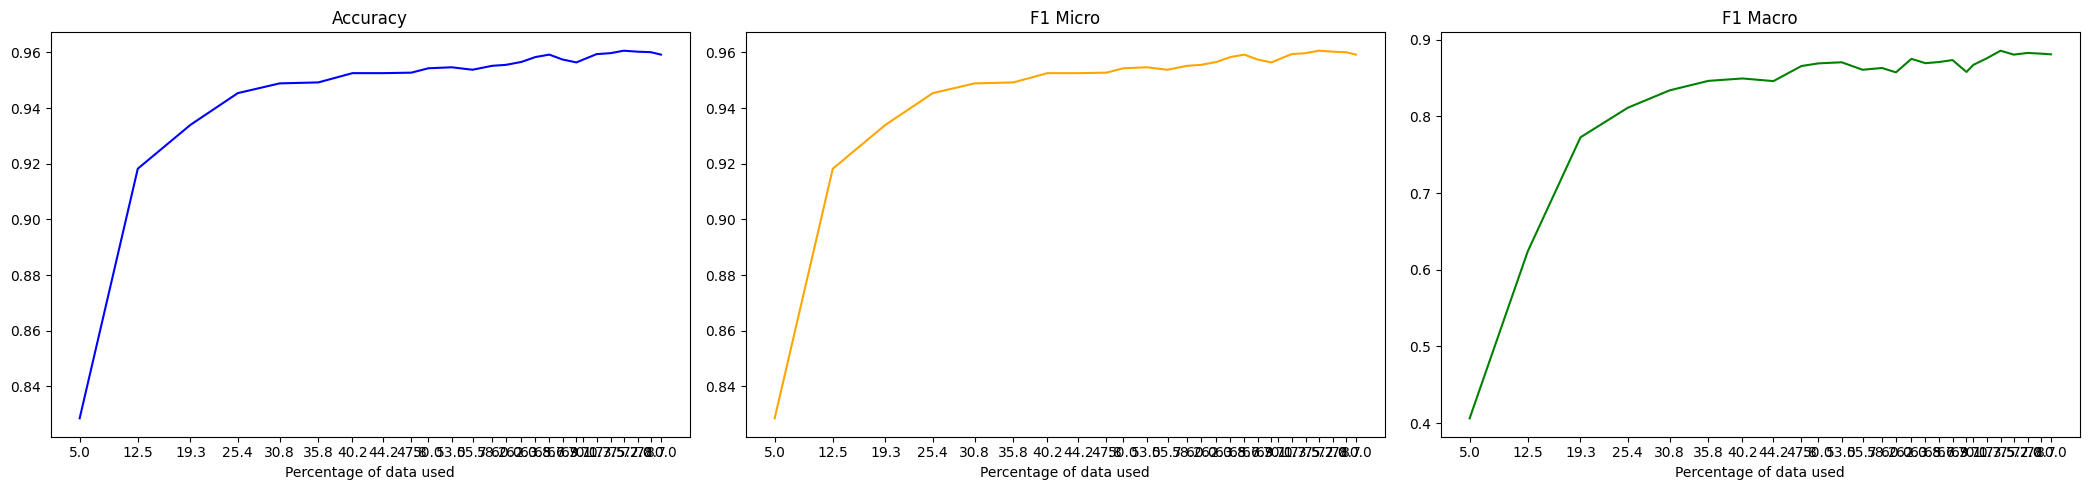

In [ ]:
active_learning(seeds[2], 2)

## RUN 4

TRIAL 4
Random seed: 3
Launching training on 2 GPUs.


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6072, Accuracy: 0.7955, F1 Micro: 0.8818, F1 Macro: 0.8546
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4916, Accuracy: 0.8016, F1 Micro: 0.8877, F1 Macro: 0.8774
Epoch 3/10, Train Loss: 0.453, Accuracy: 0.8024, F1 Micro: 0.8857, F1 Macro: 0.8609
Epoch 4/10, Train Loss: 0.4515, Accuracy: 0.8021, F1 Micro: 0.8849, F1 Macro: 0.8543
Epoch 5/10, Train Loss: 0.417, Accuracy: 0.8047, F1 Micro: 0.8868, F1 Macro: 0.862
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.4402, Accuracy: 0.8092, F1 Micro: 0.8902, F1 Macro: 0.874
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.3799, Accuracy: 0.8141, F1 Micro: 0.8937, F1 Macro: 0.8828
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.3851, Accuracy: 0.8252, F1 Micro: 0.899, F1 Macro: 0.8873
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.3532, Accuracy: 0.8361, F1 Micro: 0.9044, F1 Macro: 0.8918
Higher F1 achieved, savin

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5988, Accuracy: 0.6204, F1 Micro: 0.6204, F1 Macro: 0.3829
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.5281, Accuracy: 0.6204, F1 Micro: 0.6204, F1 Macro: 0.3829
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4888, Accuracy: 0.6259, F1 Micro: 0.6259, F1 Macro: 0.4027
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3707, Accuracy: 0.6861, F1 Micro: 0.6861, F1 Macro: 0.5752
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3492, Accuracy: 0.7336, F1 Micro: 0.7336, F1 Macro: 0.6917
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2739, Accuracy: 0.7372, F1 Micro: 0.7372, F1 Macro: 0.7005
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.3739, Accuracy: 0.7409, F1 Micro: 0.7409, F1 Macro: 0.7103
Epoch 8/10, Train Loss: 0.2974, Accuracy: 0.7281, F1 Micro: 0.7281, F1 Macro: 0.6718
Epoch 9/10, Train Loss: 0.18, Accuracy: 0.7372, F1 Micro: 0.7372, F1 Macro: 0.703
Epoch 1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5377, Accuracy: 0.801, F1 Micro: 0.8895, F1 Macro: 0.8852
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4504, Accuracy: 0.801, F1 Micro: 0.8895, F1 Macro: 0.8852
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.438, Accuracy: 0.8068, F1 Micro: 0.8923, F1 Macro: 0.8879
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.4025, Accuracy: 0.8444, F1 Micro: 0.9099, F1 Macro: 0.9027
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3454, Accuracy: 0.8729, F1 Micro: 0.9244, F1 Macro: 0.9154
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.3041, Accuracy: 0.8917, F1 Micro: 0.9346, F1 Macro: 0.925
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.259, Accuracy: 0.909, F1 Micro: 0.9446, F1 Macro: 0.9379
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.218, Accuracy: 0.9186, F1 Micro: 0.9504, F1 Macro: 0.945
Higher F1 achieved, saving model
Epoch 9/10, Tr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4924, Accuracy: 0.7202, F1 Micro: 0.7202, F1 Macro: 0.4187
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3399, Accuracy: 0.7656, F1 Micro: 0.7656, F1 Macro: 0.6193
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.298, Accuracy: 0.7835, F1 Micro: 0.7835, F1 Macro: 0.6564
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2831, Accuracy: 0.8289, F1 Micro: 0.8289, F1 Macro: 0.7587
Epoch 5/10, Train Loss: 0.2194, Accuracy: 0.8194, F1 Micro: 0.8194, F1 Macro: 0.772
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1741, Accuracy: 0.83, F1 Micro: 0.83, F1 Macro: 0.755
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1713, Accuracy: 0.8416, F1 Micro: 0.8416, F1 Macro: 0.78
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1463, Accuracy: 0.8448, F1 Micro: 0.8448, F1 Macro: 0.777
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1282, Accuracy: 0.8501, F1 Micro: 0.8501

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5089, Accuracy: 0.801, F1 Micro: 0.8895, F1 Macro: 0.8852
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4314, Accuracy: 0.8073, F1 Micro: 0.8924, F1 Macro: 0.8874
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3973, Accuracy: 0.8457, F1 Micro: 0.9109, F1 Macro: 0.9053
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3297, Accuracy: 0.875, F1 Micro: 0.9262, F1 Macro: 0.9197
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2751, Accuracy: 0.9184, F1 Micro: 0.9504, F1 Macro: 0.9453
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2305, Accuracy: 0.9312, F1 Micro: 0.958, F1 Macro: 0.9542
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1993, Accuracy: 0.9368, F1 Micro: 0.9614, F1 Macro: 0.9584
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1631, Accuracy: 0.9411, F1 Micro: 0.9639, F1 Macro: 0.9614
Higher F1 achieved, saving model
Epoch 9/1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.475, Accuracy: 0.702, F1 Micro: 0.702, F1 Macro: 0.4125
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3987, Accuracy: 0.8054, F1 Micro: 0.8054, F1 Macro: 0.7507
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2785, Accuracy: 0.8166, F1 Micro: 0.8166, F1 Macro: 0.7407
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.201, Accuracy: 0.8436, F1 Micro: 0.8436, F1 Macro: 0.8057
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2077, Accuracy: 0.8547, F1 Micro: 0.8547, F1 Macro: 0.8089
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1498, Accuracy: 0.8594, F1 Micro: 0.8594, F1 Macro: 0.8241
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1038, Accuracy: 0.8669, F1 Micro: 0.8669, F1 Macro: 0.8198
Epoch 8/10, Train Loss: 0.0955, Accuracy: 0.8361, F1 Micro: 0.8361, F1 Macro: 0.7653
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0853, Accuracy: 0.8678, F1 Micro: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5241, Accuracy: 0.8019, F1 Micro: 0.89, F1 Macro: 0.8856
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4665, Accuracy: 0.8137, F1 Micro: 0.8951, F1 Macro: 0.8891
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3999, Accuracy: 0.8833, F1 Micro: 0.9307, F1 Macro: 0.9251
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3188, Accuracy: 0.9142, F1 Micro: 0.9482, F1 Macro: 0.9437
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2479, Accuracy: 0.9351, F1 Micro: 0.9603, F1 Macro: 0.9569
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2101, Accuracy: 0.9406, F1 Micro: 0.9634, F1 Macro: 0.9601
Epoch 7/10, Train Loss: 0.1825, Accuracy: 0.9403, F1 Micro: 0.9634, F1 Macro: 0.9604
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1619, Accuracy: 0.9446, F1 Micro: 0.9661, F1 Macro: 0.9636
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.144, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5302, Accuracy: 0.7657, F1 Micro: 0.7657, F1 Macro: 0.5749
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3438, Accuracy: 0.8445, F1 Micro: 0.8445, F1 Macro: 0.7793
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2557, Accuracy: 0.8504, F1 Micro: 0.8504, F1 Macro: 0.7765
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1741, Accuracy: 0.8923, F1 Micro: 0.8923, F1 Macro: 0.8525
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.127, Accuracy: 0.8933, F1 Micro: 0.8933, F1 Macro: 0.8524
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1261, Accuracy: 0.9033, F1 Micro: 0.9033, F1 Macro: 0.8716
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0809, Accuracy: 0.9043, F1 Micro: 0.9043, F1 Macro: 0.8685
Epoch 8/10, Train Loss: 0.074, Accuracy: 0.8993, F1 Micro: 0.8993, F1 Macro: 0.8638
Epoch 9/10, Train Loss: 0.0617, Accuracy: 0.8963, F1 Micro: 0.8963, F1 Macro: 0.8576
Epoch 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5272, Accuracy: 0.801, F1 Micro: 0.8895, F1 Macro: 0.8852
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4536, Accuracy: 0.8609, F1 Micro: 0.9188, F1 Macro: 0.9125
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3496, Accuracy: 0.9137, F1 Micro: 0.9479, F1 Macro: 0.9432
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2636, Accuracy: 0.9352, F1 Micro: 0.9604, F1 Macro: 0.9565
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2182, Accuracy: 0.9422, F1 Micro: 0.9647, F1 Macro: 0.9623
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1888, Accuracy: 0.9464, F1 Micro: 0.967, F1 Macro: 0.9644
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1711, Accuracy: 0.9464, F1 Micro: 0.9671, F1 Macro: 0.9648
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1435, Accuracy: 0.9503, F1 Micro: 0.9694, F1 Macro: 0.967
Higher F1 achieved, saving model
Epoch 9/1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5004, Accuracy: 0.8171, F1 Micro: 0.8171, F1 Macro: 0.746
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3022, Accuracy: 0.8385, F1 Micro: 0.8385, F1 Macro: 0.7559
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2268, Accuracy: 0.8628, F1 Micro: 0.8628, F1 Macro: 0.7978
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1774, Accuracy: 0.893, F1 Micro: 0.893, F1 Macro: 0.8605
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1373, Accuracy: 0.8988, F1 Micro: 0.8988, F1 Macro: 0.8626
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0998, Accuracy: 0.8988, F1 Micro: 0.8988, F1 Macro: 0.8614
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1003, Accuracy: 0.8998, F1 Micro: 0.8998, F1 Macro: 0.8633
Epoch 8/10, Train Loss: 0.0623, Accuracy: 0.8872, F1 Micro: 0.8872, F1 Macro: 0.8405
Epoch 9/10, Train Loss: 0.0625, Accuracy: 0.892, F1 Micro: 0.892, F1 Macro: 0.8547
Epoch 10/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5225, Accuracy: 0.801, F1 Micro: 0.8895, F1 Macro: 0.8852
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4374, Accuracy: 0.8712, F1 Micro: 0.9243, F1 Macro: 0.9186
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3132, Accuracy: 0.9267, F1 Micro: 0.9553, F1 Macro: 0.951
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2461, Accuracy: 0.9356, F1 Micro: 0.9608, F1 Macro: 0.9578
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2039, Accuracy: 0.9464, F1 Micro: 0.9671, F1 Macro: 0.9647
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1752, Accuracy: 0.949, F1 Micro: 0.9686, F1 Macro: 0.9666
Epoch 7/10, Train Loss: 0.1519, Accuracy: 0.9481, F1 Micro: 0.9682, F1 Macro: 0.966
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1312, Accuracy: 0.9523, F1 Micro: 0.9706, F1 Macro: 0.9684
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1132, Accuracy: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.454, Accuracy: 0.8371, F1 Micro: 0.8371, F1 Macro: 0.7764
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3238, Accuracy: 0.8736, F1 Micro: 0.8736, F1 Macro: 0.8291
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2281, Accuracy: 0.8954, F1 Micro: 0.8954, F1 Macro: 0.8569
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1765, Accuracy: 0.9013, F1 Micro: 0.9013, F1 Macro: 0.8672
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.126, Accuracy: 0.9033, F1 Micro: 0.9033, F1 Macro: 0.8654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1012, Accuracy: 0.9082, F1 Micro: 0.9082, F1 Macro: 0.8757
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0796, Accuracy: 0.9121, F1 Micro: 0.9121, F1 Macro: 0.8832
Epoch 8/10, Train Loss: 0.0638, Accuracy: 0.9112, F1 Micro: 0.9112, F1 Macro: 0.8785
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0484, Accuracy: 0.9161, F1 Micro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5144, Accuracy: 0.8062, F1 Micro: 0.8917, F1 Macro: 0.8863
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3987, Accuracy: 0.8979, F1 Micro: 0.9391, F1 Macro: 0.9337
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.288, Accuracy: 0.9323, F1 Micro: 0.9588, F1 Macro: 0.9555
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2259, Accuracy: 0.9405, F1 Micro: 0.9637, F1 Macro: 0.961
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1887, Accuracy: 0.9469, F1 Micro: 0.9675, F1 Macro: 0.9655
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1633, Accuracy: 0.9512, F1 Micro: 0.9699, F1 Macro: 0.9674
Epoch 7/10, Train Loss: 0.1424, Accuracy: 0.9488, F1 Micro: 0.9686, F1 Macro: 0.9658
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1143, Accuracy: 0.9561, F1 Micro: 0.9729, F1 Macro: 0.9705
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1, Accuracy: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4657, Accuracy: 0.8559, F1 Micro: 0.8559, F1 Macro: 0.8155
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2615, Accuracy: 0.8757, F1 Micro: 0.8757, F1 Macro: 0.8328
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2207, Accuracy: 0.8983, F1 Micro: 0.8983, F1 Macro: 0.8725
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1652, Accuracy: 0.9021, F1 Micro: 0.9021, F1 Macro: 0.8702
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1171, Accuracy: 0.9068, F1 Micro: 0.9068, F1 Macro: 0.8806
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0802, Accuracy: 0.9068, F1 Micro: 0.9068, F1 Macro: 0.8801
Epoch 7/10, Train Loss: 0.0465, Accuracy: 0.9011, F1 Micro: 0.9011, F1 Macro: 0.8698
Epoch 8/10, Train Loss: 0.0555, Accuracy: 0.904, F1 Micro: 0.904, F1 Macro: 0.8755
Epoch 9/10, Train Loss: 0.0387, Accuracy: 0.904, F1 Micro: 0.904, F1 Macro: 0.8749
Higher F1 achieved, saving model
Epoch 10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5017, Accuracy: 0.8104, F1 Micro: 0.8937, F1 Macro: 0.8881
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3704, Accuracy: 0.9146, F1 Micro: 0.9482, F1 Macro: 0.9432
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.263, Accuracy: 0.9358, F1 Micro: 0.9608, F1 Macro: 0.9578
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2115, Accuracy: 0.942, F1 Micro: 0.9645, F1 Macro: 0.9617
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1664, Accuracy: 0.9488, F1 Micro: 0.9685, F1 Macro: 0.9661
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1494, Accuracy: 0.9526, F1 Micro: 0.9708, F1 Macro: 0.9679
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1229, Accuracy: 0.9547, F1 Micro: 0.972, F1 Macro: 0.9694
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1071, Accuracy: 0.9589, F1 Micro: 0.9745, F1 Macro: 0.9721
Higher F1 achieved, saving model
Epoch 9/1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4307, Accuracy: 0.8475, F1 Micro: 0.8475, F1 Macro: 0.8126
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2899, Accuracy: 0.8567, F1 Micro: 0.8567, F1 Macro: 0.8041
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1996, Accuracy: 0.8845, F1 Micro: 0.8845, F1 Macro: 0.8456
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.141, Accuracy: 0.8909, F1 Micro: 0.8909, F1 Macro: 0.8572
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1076, Accuracy: 0.9002, F1 Micro: 0.9002, F1 Macro: 0.8711
Epoch 6/10, Train Loss: 0.0638, Accuracy: 0.8965, F1 Micro: 0.8965, F1 Macro: 0.8666
Epoch 7/10, Train Loss: 0.055, Accuracy: 0.8983, F1 Micro: 0.8983, F1 Macro: 0.8687
Epoch 8/10, Train Loss: 0.0521, Accuracy: 0.8983, F1 Micro: 0.8983, F1 Macro: 0.8707
Epoch 9/10, Train Loss: 0.0699, Accuracy: 0.8974, F1 Micro: 0.8974, F1 Macro: 0.8655
Epoch 10/10, Train Loss: 0.0297, Accuracy: 0.8965, F1 Micro: 0.8965, F1 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4921, Accuracy: 0.8208, F1 Micro: 0.8988, F1 Macro: 0.8932
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3569, Accuracy: 0.9172, F1 Micro: 0.9499, F1 Macro: 0.9455
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.246, Accuracy: 0.9359, F1 Micro: 0.9612, F1 Macro: 0.9584
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1984, Accuracy: 0.9441, F1 Micro: 0.9658, F1 Macro: 0.9635
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1603, Accuracy: 0.9491, F1 Micro: 0.9687, F1 Macro: 0.9661
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1404, Accuracy: 0.9573, F1 Micro: 0.9736, F1 Macro: 0.9711
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.118, Accuracy: 0.9592, F1 Micro: 0.9747, F1 Macro: 0.9723
Epoch 8/10, Train Loss: 0.0991, Accuracy: 0.9587, F1 Micro: 0.9744, F1 Macro: 0.972
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0888, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4224, Accuracy: 0.8554, F1 Micro: 0.8554, F1 Macro: 0.8131
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.243, Accuracy: 0.861, F1 Micro: 0.861, F1 Macro: 0.8108
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1776, Accuracy: 0.8978, F1 Micro: 0.8978, F1 Macro: 0.8704
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1171, Accuracy: 0.8978, F1 Micro: 0.8978, F1 Macro: 0.8699
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0974, Accuracy: 0.8987, F1 Micro: 0.8987, F1 Macro: 0.8703
Epoch 6/10, Train Loss: 0.0676, Accuracy: 0.8877, F1 Micro: 0.8877, F1 Macro: 0.862
Epoch 7/10, Train Loss: 0.0677, Accuracy: 0.8978, F1 Micro: 0.8978, F1 Macro: 0.866
Epoch 8/10, Train Loss: 0.0467, Accuracy: 0.8969, F1 Micro: 0.8969, F1 Macro: 0.8708
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0284, Accuracy: 0.9006, F1 Micro: 0.9006, F1 Macro: 0.8724
Higher F1 achieved, saving model
Epoch 10/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4905, Accuracy: 0.8266, F1 Micro: 0.9017, F1 Macro: 0.8964
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3478, Accuracy: 0.9198, F1 Micro: 0.9515, F1 Macro: 0.9476
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2424, Accuracy: 0.9418, F1 Micro: 0.9645, F1 Macro: 0.9621
Epoch 4/10, Train Loss: 0.1925, Accuracy: 0.9415, F1 Micro: 0.9642, F1 Macro: 0.9617
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1638, Accuracy: 0.954, F1 Micro: 0.9716, F1 Macro: 0.9695
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.136, Accuracy: 0.9547, F1 Micro: 0.972, F1 Macro: 0.9694
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1144, Accuracy: 0.959, F1 Micro: 0.9746, F1 Macro: 0.9725
Epoch 8/10, Train Loss: 0.0943, Accuracy: 0.9575, F1 Micro: 0.9737, F1 Macro: 0.9714
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0827, Accuracy: 0.9592, F1 Micro: 0.9747, F1 Macro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4, Accuracy: 0.8371, F1 Micro: 0.8371, F1 Macro: 0.7718
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.272, Accuracy: 0.871, F1 Micro: 0.871, F1 Macro: 0.8289
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1875, Accuracy: 0.8838, F1 Micro: 0.8838, F1 Macro: 0.8455
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1385, Accuracy: 0.903, F1 Micro: 0.903, F1 Macro: 0.8762
Epoch 5/10, Train Loss: 0.0867, Accuracy: 0.8948, F1 Micro: 0.8948, F1 Macro: 0.8669
Epoch 6/10, Train Loss: 0.0782, Accuracy: 0.9012, F1 Micro: 0.9012, F1 Macro: 0.8738
Epoch 7/10, Train Loss: 0.0602, Accuracy: 0.9003, F1 Micro: 0.9003, F1 Macro: 0.8687
Epoch 8/10, Train Loss: 0.032, Accuracy: 0.9003, F1 Micro: 0.9003, F1 Macro: 0.8705
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0467, Accuracy: 0.9039, F1 Micro: 0.9039, F1 Macro: 0.875
Epoch 10/10, Train Loss: 0.0333, Accuracy: 0.8783, F1 Micro: 0.8783, F1 Macro: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4781, Accuracy: 0.8377, F1 Micro: 0.9075, F1 Macro: 0.9026
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3247, Accuracy: 0.9243, F1 Micro: 0.954, F1 Macro: 0.9499
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2312, Accuracy: 0.9438, F1 Micro: 0.9654, F1 Macro: 0.9624
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1855, Accuracy: 0.9476, F1 Micro: 0.9678, F1 Macro: 0.9655
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1546, Accuracy: 0.9505, F1 Micro: 0.9696, F1 Macro: 0.9666
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1299, Accuracy: 0.9589, F1 Micro: 0.9745, F1 Macro: 0.9719
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1074, Accuracy: 0.959, F1 Micro: 0.9746, F1 Macro: 0.9721
Epoch 8/10, Train Loss: 0.0922, Accuracy: 0.9573, F1 Micro: 0.9735, F1 Macro: 0.9709
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0768, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4135, Accuracy: 0.8555, F1 Micro: 0.8555, F1 Macro: 0.8155
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2459, Accuracy: 0.8919, F1 Micro: 0.8919, F1 Macro: 0.8579
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1514, Accuracy: 0.9021, F1 Micro: 0.9021, F1 Macro: 0.8756
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1173, Accuracy: 0.9059, F1 Micro: 0.9059, F1 Macro: 0.8784
Epoch 5/10, Train Loss: 0.0697, Accuracy: 0.9049, F1 Micro: 0.9049, F1 Macro: 0.8747
Epoch 6/10, Train Loss: 0.0608, Accuracy: 0.8993, F1 Micro: 0.8993, F1 Macro: 0.8683
Epoch 7/10, Train Loss: 0.0576, Accuracy: 0.9031, F1 Micro: 0.9031, F1 Macro: 0.8735
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0303, Accuracy: 0.9077, F1 Micro: 0.9077, F1 Macro: 0.878
Epoch 9/10, Train Loss: 0.0456, Accuracy: 0.9049, F1 Micro: 0.9049, F1 Macro: 0.8756
Epoch 10/10, Train Loss: 0.0328, Accuracy: 0.9021, F1 Micro: 0.9021, F1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4748, Accuracy: 0.8436, F1 Micro: 0.9103, F1 Macro: 0.9052
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3242, Accuracy: 0.9214, F1 Micro: 0.9526, F1 Macro: 0.9493
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.226, Accuracy: 0.946, F1 Micro: 0.9667, F1 Macro: 0.9641
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1805, Accuracy: 0.9512, F1 Micro: 0.9699, F1 Macro: 0.9675
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1464, Accuracy: 0.9543, F1 Micro: 0.9719, F1 Macro: 0.9696
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1259, Accuracy: 0.9589, F1 Micro: 0.9745, F1 Macro: 0.9717
Epoch 7/10, Train Loss: 0.1045, Accuracy: 0.9585, F1 Micro: 0.9743, F1 Macro: 0.9723
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0928, Accuracy: 0.9615, F1 Micro: 0.9761, F1 Macro: 0.9741
Epoch 9/10, Train Loss: 0.0785, Accuracy: 0.9608, F1 Micro: 0.9757, F1 Mac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4009, Accuracy: 0.862, F1 Micro: 0.862, F1 Macro: 0.8217
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2307, Accuracy: 0.8859, F1 Micro: 0.8859, F1 Macro: 0.8498
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.179, Accuracy: 0.8979, F1 Micro: 0.8979, F1 Macro: 0.8724
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1214, Accuracy: 0.9043, F1 Micro: 0.9043, F1 Macro: 0.8798
Epoch 5/10, Train Loss: 0.1142, Accuracy: 0.8979, F1 Micro: 0.8979, F1 Macro: 0.8716
Epoch 6/10, Train Loss: 0.076, Accuracy: 0.8997, F1 Micro: 0.8997, F1 Macro: 0.8691
Epoch 7/10, Train Loss: 0.0476, Accuracy: 0.9025, F1 Micro: 0.9025, F1 Macro: 0.8728
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0536, Accuracy: 0.9052, F1 Micro: 0.9052, F1 Macro: 0.8782
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0349, Accuracy: 0.908, F1 Micro: 0.908, F1 Macro: 0.8811
Epoch 10/10, Train Loss: 0.0223, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4649, Accuracy: 0.8573, F1 Micro: 0.9169, F1 Macro: 0.9109
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3038, Accuracy: 0.9281, F1 Micro: 0.9562, F1 Macro: 0.953
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2184, Accuracy: 0.9439, F1 Micro: 0.9657, F1 Macro: 0.9632
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1753, Accuracy: 0.9476, F1 Micro: 0.9678, F1 Macro: 0.9652
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1467, Accuracy: 0.9542, F1 Micro: 0.9717, F1 Macro: 0.9694
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1218, Accuracy: 0.9568, F1 Micro: 0.9733, F1 Macro: 0.9708
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0993, Accuracy: 0.962, F1 Micro: 0.9764, F1 Macro: 0.9741
Epoch 8/10, Train Loss: 0.085, Accuracy: 0.9611, F1 Micro: 0.9758, F1 Macro: 0.9735
Epoch 9/10, Train Loss: 0.0719, Accuracy: 0.9606, F1 Micro: 0.9756, F1 Macr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4074, Accuracy: 0.8496, F1 Micro: 0.8496, F1 Macro: 0.8157
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2505, Accuracy: 0.8822, F1 Micro: 0.8822, F1 Macro: 0.8522
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.184, Accuracy: 0.8949, F1 Micro: 0.8949, F1 Macro: 0.8656
Epoch 4/10, Train Loss: 0.1348, Accuracy: 0.8877, F1 Micro: 0.8877, F1 Macro: 0.8537
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1095, Accuracy: 0.8958, F1 Micro: 0.8958, F1 Macro: 0.8626
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0784, Accuracy: 0.9013, F1 Micro: 0.9013, F1 Macro: 0.8735
Epoch 7/10, Train Loss: 0.0631, Accuracy: 0.8859, F1 Micro: 0.8859, F1 Macro: 0.8524
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.049, Accuracy: 0.9031, F1 Micro: 0.9031, F1 Macro: 0.8748
Epoch 9/10, Train Loss: 0.0233, Accuracy: 0.8986, F1 Micro: 0.8986, F1 Macro: 0.8685
Epoch 10/10, Train Loss: 0.0305, Accura

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4679, Accuracy: 0.8701, F1 Micro: 0.9234, F1 Macro: 0.9173
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3013, Accuracy: 0.929, F1 Micro: 0.957, F1 Macro: 0.9542
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2111, Accuracy: 0.9427, F1 Micro: 0.965, F1 Macro: 0.9626
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1704, Accuracy: 0.9526, F1 Micro: 0.9707, F1 Macro: 0.9681
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1397, Accuracy: 0.9542, F1 Micro: 0.9717, F1 Macro: 0.9687
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1212, Accuracy: 0.958, F1 Micro: 0.974, F1 Macro: 0.9715
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0986, Accuracy: 0.959, F1 Micro: 0.9747, F1 Macro: 0.9722
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0861, Accuracy: 0.962, F1 Micro: 0.9763, F1 Macro: 0.9738
Epoch 9/10, Train Loss: 0.0691, Accuracy: 0.95

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3806, Accuracy: 0.8678, F1 Micro: 0.8678, F1 Macro: 0.8225
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2512, Accuracy: 0.8937, F1 Micro: 0.8937, F1 Macro: 0.8607
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1539, Accuracy: 0.9057, F1 Micro: 0.9057, F1 Macro: 0.8766
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.122, Accuracy: 0.9113, F1 Micro: 0.9113, F1 Macro: 0.8886
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0853, Accuracy: 0.9159, F1 Micro: 0.9159, F1 Macro: 0.8927
Epoch 6/10, Train Loss: 0.0581, Accuracy: 0.9122, F1 Micro: 0.9122, F1 Macro: 0.8875
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0434, Accuracy: 0.9168, F1 Micro: 0.9168, F1 Macro: 0.8942
Epoch 8/10, Train Loss: 0.0387, Accuracy: 0.9104, F1 Micro: 0.9104, F1 Macro: 0.883
Epoch 9/10, Train Loss: 0.0293, Accuracy: 0.914, F1 Micro: 0.914, F1 Macro: 0.8891
Epoch 10/10, Train Loss: 0.017, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.465, Accuracy: 0.8722, F1 Micro: 0.925, F1 Macro: 0.9194
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2976, Accuracy: 0.9321, F1 Micro: 0.9586, F1 Macro: 0.9557
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2091, Accuracy: 0.9425, F1 Micro: 0.9649, F1 Macro: 0.9629
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1737, Accuracy: 0.9538, F1 Micro: 0.9716, F1 Macro: 0.9693
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1332, Accuracy: 0.9575, F1 Micro: 0.9737, F1 Macro: 0.9713
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1127, Accuracy: 0.9599, F1 Micro: 0.9751, F1 Macro: 0.9728
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0951, Accuracy: 0.9611, F1 Micro: 0.9759, F1 Macro: 0.9737
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0818, Accuracy: 0.9623, F1 Micro: 0.9767, F1 Macro: 0.9742
Epoch 9/10, Train Loss: 0.0689, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3738, Accuracy: 0.8594, F1 Micro: 0.8594, F1 Macro: 0.8073
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2162, Accuracy: 0.896, F1 Micro: 0.896, F1 Macro: 0.8616
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1372, Accuracy: 0.9082, F1 Micro: 0.9082, F1 Macro: 0.8816
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1052, Accuracy: 0.9082, F1 Micro: 0.9082, F1 Macro: 0.88
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0873, Accuracy: 0.9166, F1 Micro: 0.9166, F1 Macro: 0.8934
Epoch 6/10, Train Loss: 0.0537, Accuracy: 0.9007, F1 Micro: 0.9007, F1 Macro: 0.8686
Epoch 7/10, Train Loss: 0.0536, Accuracy: 0.911, F1 Micro: 0.911, F1 Macro: 0.8838
Epoch 8/10, Train Loss: 0.046, Accuracy: 0.9138, F1 Micro: 0.9138, F1 Macro: 0.8884
Epoch 9/10, Train Loss: 0.0148, Accuracy: 0.9157, F1 Micro: 0.9157, F1 Macro: 0.8895
Epoch 10/10, Train Loss: 0.0264, Accuracy: 0.9063, F1 Micro: 0.9063, F1 Macro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4654, Accuracy: 0.8759, F1 Micro: 0.9271, F1 Macro: 0.9221
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2943, Accuracy: 0.9356, F1 Micro: 0.9607, F1 Macro: 0.9575
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2101, Accuracy: 0.9446, F1 Micro: 0.9661, F1 Macro: 0.9639
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1677, Accuracy: 0.9514, F1 Micro: 0.9701, F1 Macro: 0.9677
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1351, Accuracy: 0.9571, F1 Micro: 0.9735, F1 Macro: 0.9711
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1155, Accuracy: 0.9594, F1 Micro: 0.9749, F1 Macro: 0.9725
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0974, Accuracy: 0.9609, F1 Micro: 0.9758, F1 Macro: 0.9735
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.082, Accuracy: 0.9613, F1 Micro: 0.976, F1 Macro: 0.9737
Higher F1 achieved, saving model
Epoch 9/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3683, Accuracy: 0.8434, F1 Micro: 0.8434, F1 Macro: 0.7821
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2242, Accuracy: 0.8971, F1 Micro: 0.8971, F1 Macro: 0.866
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1817, Accuracy: 0.9016, F1 Micro: 0.9016, F1 Macro: 0.8732
Epoch 4/10, Train Loss: 0.1047, Accuracy: 0.8934, F1 Micro: 0.8934, F1 Macro: 0.8663
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1056, Accuracy: 0.9026, F1 Micro: 0.9026, F1 Macro: 0.8756
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0847, Accuracy: 0.9044, F1 Micro: 0.9044, F1 Macro: 0.8757
Epoch 7/10, Train Loss: 0.057, Accuracy: 0.9026, F1 Micro: 0.9026, F1 Macro: 0.8759
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0603, Accuracy: 0.9107, F1 Micro: 0.9107, F1 Macro: 0.8849
Epoch 9/10, Train Loss: 0.03, Accuracy: 0.9071, F1 Micro: 0.9071, F1 Macro: 0.8808
Epoch 10/10, Train Loss: 0.0445, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4602, Accuracy: 0.8708, F1 Micro: 0.9241, F1 Macro: 0.9176
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2842, Accuracy: 0.9354, F1 Micro: 0.9606, F1 Macro: 0.9575
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2046, Accuracy: 0.946, F1 Micro: 0.967, F1 Macro: 0.9646
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1626, Accuracy: 0.9484, F1 Micro: 0.9684, F1 Macro: 0.9661
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.135, Accuracy: 0.9576, F1 Micro: 0.9738, F1 Macro: 0.9713
Epoch 6/10, Train Loss: 0.1097, Accuracy: 0.9571, F1 Micro: 0.9735, F1 Macro: 0.9711
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.091, Accuracy: 0.9604, F1 Micro: 0.9755, F1 Macro: 0.9732
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0778, Accuracy: 0.9632, F1 Micro: 0.9771, F1 Macro: 0.9749
Epoch 9/10, Train Loss: 0.0633, Accuracy: 0.9615, F1 Micro: 0.9761, F1 Macro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3739, Accuracy: 0.8454, F1 Micro: 0.8454, F1 Macro: 0.8098
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2245, Accuracy: 0.8856, F1 Micro: 0.8856, F1 Macro: 0.85
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1606, Accuracy: 0.8963, F1 Micro: 0.8963, F1 Macro: 0.8659
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1054, Accuracy: 0.899, F1 Micro: 0.899, F1 Macro: 0.8704
Epoch 5/10, Train Loss: 0.0875, Accuracy: 0.8981, F1 Micro: 0.8981, F1 Macro: 0.8682
Epoch 6/10, Train Loss: 0.0691, Accuracy: 0.8963, F1 Micro: 0.8963, F1 Macro: 0.8653
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0522, Accuracy: 0.8999, F1 Micro: 0.8999, F1 Macro: 0.8694
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0472, Accuracy: 0.8999, F1 Micro: 0.8999, F1 Macro: 0.87
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0195, Accuracy: 0.9017, F1 Micro: 0.9017, F1 Macro: 0.8723
Epoch 10/1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4616, Accuracy: 0.8774, F1 Micro: 0.9275, F1 Macro: 0.9215
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2784, Accuracy: 0.937, F1 Micro: 0.9615, F1 Macro: 0.9589
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1981, Accuracy: 0.9464, F1 Micro: 0.9672, F1 Macro: 0.9652
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1574, Accuracy: 0.9559, F1 Micro: 0.9727, F1 Macro: 0.9705
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1346, Accuracy: 0.9604, F1 Micro: 0.9755, F1 Macro: 0.9732
Epoch 6/10, Train Loss: 0.1054, Accuracy: 0.9595, F1 Micro: 0.9749, F1 Macro: 0.9726
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0885, Accuracy: 0.9609, F1 Micro: 0.9758, F1 Macro: 0.9738
Epoch 8/10, Train Loss: 0.0748, Accuracy: 0.9608, F1 Micro: 0.9758, F1 Macro: 0.9739
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0656, Accuracy: 0.9632, F1 Micro: 0.9771, F1 Ma

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3701, Accuracy: 0.859, F1 Micro: 0.859, F1 Macro: 0.8099
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2115, Accuracy: 0.8897, F1 Micro: 0.8897, F1 Macro: 0.8548
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1487, Accuracy: 0.9024, F1 Micro: 0.9024, F1 Macro: 0.8746
Epoch 4/10, Train Loss: 0.1046, Accuracy: 0.8996, F1 Micro: 0.8996, F1 Macro: 0.8748
Epoch 5/10, Train Loss: 0.0761, Accuracy: 0.896, F1 Micro: 0.896, F1 Macro: 0.8624
Epoch 6/10, Train Loss: 0.0615, Accuracy: 0.8996, F1 Micro: 0.8996, F1 Macro: 0.8721
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0559, Accuracy: 0.9096, F1 Micro: 0.9096, F1 Macro: 0.8826
Epoch 8/10, Train Loss: 0.0355, Accuracy: 0.9051, F1 Micro: 0.9051, F1 Macro: 0.8758
Epoch 9/10, Train Loss: 0.0325, Accuracy: 0.9033, F1 Micro: 0.9033, F1 Macro: 0.874
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0217, Accuracy: 0.9096, F1 Micro: 0.9096, F1 Mac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4489, Accuracy: 0.8837, F1 Micro: 0.9309, F1 Macro: 0.9251
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2766, Accuracy: 0.9368, F1 Micro: 0.9616, F1 Macro: 0.9591
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2013, Accuracy: 0.9443, F1 Micro: 0.966, F1 Macro: 0.9638
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1605, Accuracy: 0.9514, F1 Micro: 0.9702, F1 Macro: 0.9678
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1294, Accuracy: 0.9613, F1 Micro: 0.976, F1 Macro: 0.9736
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1045, Accuracy: 0.963, F1 Micro: 0.977, F1 Macro: 0.9748
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0893, Accuracy: 0.9648, F1 Micro: 0.9781, F1 Macro: 0.9759
Epoch 8/10, Train Loss: 0.0731, Accuracy: 0.9592, F1 Micro: 0.9748, F1 Macro: 0.9727
Epoch 9/10, Train Loss: 0.0622, Accuracy: 0.9642, F1 Micro: 0.9778, F1 Macro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3739, Accuracy: 0.8626, F1 Micro: 0.8626, F1 Macro: 0.8186
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2147, Accuracy: 0.8864, F1 Micro: 0.8864, F1 Macro: 0.8482
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.155, Accuracy: 0.9048, F1 Micro: 0.9048, F1 Macro: 0.8768
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1149, Accuracy: 0.9066, F1 Micro: 0.9066, F1 Macro: 0.8781
Epoch 5/10, Train Loss: 0.0962, Accuracy: 0.9048, F1 Micro: 0.9048, F1 Macro: 0.8782
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0613, Accuracy: 0.9148, F1 Micro: 0.9148, F1 Macro: 0.8895
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0455, Accuracy: 0.9158, F1 Micro: 0.9158, F1 Macro: 0.8918
Epoch 8/10, Train Loss: 0.0487, Accuracy: 0.9139, F1 Micro: 0.9139, F1 Macro: 0.8887
Epoch 9/10, Train Loss: 0.0344, Accuracy: 0.9103, F1 Micro: 0.9103, F1 Macro: 0.8845
Epoch 10/10, Train Loss: 0.0363, Accur

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4504, Accuracy: 0.878, F1 Micro: 0.9281, F1 Macro: 0.923
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2636, Accuracy: 0.9417, F1 Micro: 0.9644, F1 Macro: 0.9622
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1916, Accuracy: 0.9465, F1 Micro: 0.9674, F1 Macro: 0.9652
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1558, Accuracy: 0.9545, F1 Micro: 0.972, F1 Macro: 0.9698
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1275, Accuracy: 0.959, F1 Micro: 0.9747, F1 Macro: 0.9725
Epoch 6/10, Train Loss: 0.1033, Accuracy: 0.9587, F1 Micro: 0.9745, F1 Macro: 0.9725
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0918, Accuracy: 0.963, F1 Micro: 0.977, F1 Macro: 0.9748
Epoch 8/10, Train Loss: 0.0729, Accuracy: 0.963, F1 Micro: 0.977, F1 Macro: 0.9748
Epoch 9/10, Train Loss: 0.0615, Accuracy: 0.9606, F1 Micro: 0.9756, F1 Macro: 0.9734
Higher F1 achieved, saving m

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3822, Accuracy: 0.8473, F1 Micro: 0.8473, F1 Macro: 0.7844
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2007, Accuracy: 0.897, F1 Micro: 0.897, F1 Macro: 0.8634
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1417, Accuracy: 0.9115, F1 Micro: 0.9115, F1 Macro: 0.888
Epoch 4/10, Train Loss: 0.0983, Accuracy: 0.9042, F1 Micro: 0.9042, F1 Macro: 0.8781
Epoch 5/10, Train Loss: 0.0718, Accuracy: 0.9097, F1 Micro: 0.9097, F1 Macro: 0.884
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.052, Accuracy: 0.9124, F1 Micro: 0.9124, F1 Macro: 0.8866
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0353, Accuracy: 0.9142, F1 Micro: 0.9142, F1 Macro: 0.8892
Epoch 8/10, Train Loss: 0.0334, Accuracy: 0.9088, F1 Micro: 0.9088, F1 Macro: 0.8797
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0211, Accuracy: 0.9178, F1 Micro: 0.9178, F1 Macro: 0.8938
Epoch 10/10, Train Loss: 0.0163, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4445, Accuracy: 0.8832, F1 Micro: 0.9305, F1 Macro: 0.9236
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2701, Accuracy: 0.9392, F1 Micro: 0.9628, F1 Macro: 0.9599
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1933, Accuracy: 0.9493, F1 Micro: 0.9689, F1 Macro: 0.9666
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1577, Accuracy: 0.9533, F1 Micro: 0.9713, F1 Macro: 0.9692
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1221, Accuracy: 0.9602, F1 Micro: 0.9753, F1 Macro: 0.973
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1049, Accuracy: 0.9606, F1 Micro: 0.9756, F1 Macro: 0.9731
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0862, Accuracy: 0.963, F1 Micro: 0.977, F1 Macro: 0.9748
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0719, Accuracy: 0.9635, F1 Micro: 0.9774, F1 Macro: 0.975
Epoch 9/10, Train Loss: 0.0616, Accuracy: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3868, Accuracy: 0.8664, F1 Micro: 0.8664, F1 Macro: 0.8307
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2159, Accuracy: 0.8949, F1 Micro: 0.8949, F1 Macro: 0.8618
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1324, Accuracy: 0.9023, F1 Micro: 0.9023, F1 Macro: 0.8736
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.0986, Accuracy: 0.9051, F1 Micro: 0.9051, F1 Macro: 0.8784
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0683, Accuracy: 0.9134, F1 Micro: 0.9134, F1 Macro: 0.8889
Epoch 6/10, Train Loss: 0.0468, Accuracy: 0.9088, F1 Micro: 0.9088, F1 Macro: 0.8818
Epoch 7/10, Train Loss: 0.0368, Accuracy: 0.9097, F1 Micro: 0.9097, F1 Macro: 0.8834
Epoch 8/10, Train Loss: 0.0404, Accuracy: 0.9069, F1 Micro: 0.9069, F1 Macro: 0.8813
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0283, Accuracy: 0.9134, F1 Micro: 0.9134, F1 Macro: 0.8877
Epoch 10/10, Train Loss: 0.0163, Accu

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4462, Accuracy: 0.8865, F1 Micro: 0.933, F1 Macro: 0.928
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2571, Accuracy: 0.9396, F1 Micro: 0.9631, F1 Macro: 0.9609
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.185, Accuracy: 0.9505, F1 Micro: 0.9696, F1 Macro: 0.9677
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1456, Accuracy: 0.9549, F1 Micro: 0.9723, F1 Macro: 0.9702
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1213, Accuracy: 0.9597, F1 Micro: 0.9751, F1 Macro: 0.973
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.095, Accuracy: 0.9611, F1 Micro: 0.976, F1 Macro: 0.9735
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.085, Accuracy: 0.9641, F1 Micro: 0.9777, F1 Macro: 0.9755
Epoch 8/10, Train Loss: 0.0681, Accuracy: 0.9637, F1 Micro: 0.9775, F1 Macro: 0.9751
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0594, Accuracy: 0.96

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3643, Accuracy: 0.859, F1 Micro: 0.859, F1 Macro: 0.821
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2215, Accuracy: 0.8972, F1 Micro: 0.8972, F1 Macro: 0.869
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1503, Accuracy: 0.9017, F1 Micro: 0.9017, F1 Macro: 0.8697
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1096, Accuracy: 0.9099, F1 Micro: 0.9099, F1 Macro: 0.8834
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0777, Accuracy: 0.9136, F1 Micro: 0.9136, F1 Macro: 0.8874
Epoch 6/10, Train Loss: 0.056, Accuracy: 0.9126, F1 Micro: 0.9126, F1 Macro: 0.8855
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0365, Accuracy: 0.9136, F1 Micro: 0.9136, F1 Macro: 0.8863
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0342, Accuracy: 0.9199, F1 Micro: 0.9199, F1 Macro: 0.8953
Epoch 9/10, Train Loss: 0.0264, Accuracy: 0.9108, F1 Micro: 0.9108, F1 Macro: 0.8837
Epoch 10/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4418, Accuracy: 0.888, F1 Micro: 0.9338, F1 Macro: 0.9288
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2579, Accuracy: 0.9417, F1 Micro: 0.9643, F1 Macro: 0.9616
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1836, Accuracy: 0.9498, F1 Micro: 0.9692, F1 Macro: 0.9672
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1487, Accuracy: 0.9552, F1 Micro: 0.9723, F1 Macro: 0.97
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1213, Accuracy: 0.9575, F1 Micro: 0.9738, F1 Macro: 0.9716
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0998, Accuracy: 0.9632, F1 Micro: 0.9772, F1 Macro: 0.9751
Epoch 7/10, Train Loss: 0.0803, Accuracy: 0.9625, F1 Micro: 0.9767, F1 Macro: 0.9742
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0672, Accuracy: 0.9637, F1 Micro: 0.9775, F1 Macro: 0.9753
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0548, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3501, Accuracy: 0.8738, F1 Micro: 0.8738, F1 Macro: 0.835
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1916, Accuracy: 0.9079, F1 Micro: 0.9079, F1 Macro: 0.8794
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1223, Accuracy: 0.9116, F1 Micro: 0.9116, F1 Macro: 0.884
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.0989, Accuracy: 0.9125, F1 Micro: 0.9125, F1 Macro: 0.8845
Epoch 5/10, Train Loss: 0.0759, Accuracy: 0.9098, F1 Micro: 0.9098, F1 Macro: 0.8834
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0553, Accuracy: 0.9217, F1 Micro: 0.9217, F1 Macro: 0.8979
Epoch 7/10, Train Loss: 0.0414, Accuracy: 0.918, F1 Micro: 0.918, F1 Macro: 0.8928
Epoch 8/10, Train Loss: 0.0198, Accuracy: 0.9153, F1 Micro: 0.9153, F1 Macro: 0.8908
Epoch 9/10, Train Loss: 0.0347, Accuracy: 0.9125, F1 Micro: 0.9125, F1 Macro: 0.8893
Epoch 10/10, Train Loss: 0.0248, Accuracy: 0.9107, F1 Micro: 0.9107, F1 Ma

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION


Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4335, Accuracy: 0.8896, F1 Micro: 0.934, F1 Macro: 0.9283
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2551, Accuracy: 0.9385, F1 Micro: 0.9625, F1 Macro: 0.9598
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1796, Accuracy: 0.9509, F1 Micro: 0.9698, F1 Macro: 0.9677
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1454, Accuracy: 0.9564, F1 Micro: 0.9731, F1 Macro: 0.971
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1151, Accuracy: 0.9578, F1 Micro: 0.974, F1 Macro: 0.9717
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0929, Accuracy: 0.9639, F1 Micro: 0.9776, F1 Macro: 0.9754
Epoch 7/10, Train Loss: 0.0798, Accuracy: 0.9608, F1 Micro: 0.9757, F1 Macro: 0.9737
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0678, Accuracy: 0.9646, F1 Micro: 0.978, F1 Macro: 0.9758
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.054, Accuracy: 0.9661, F1 Micro: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3409, Accuracy: 0.8637, F1 Micro: 0.8637, F1 Macro: 0.8185
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2222, Accuracy: 0.8953, F1 Micro: 0.8953, F1 Macro: 0.8621
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1367, Accuracy: 0.9043, F1 Micro: 0.9043, F1 Macro: 0.8751
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1082, Accuracy: 0.9088, F1 Micro: 0.9088, F1 Macro: 0.8847
Epoch 5/10, Train Loss: 0.0724, Accuracy: 0.898, F1 Micro: 0.898, F1 Macro: 0.8651
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0567, Accuracy: 0.9097, F1 Micro: 0.9097, F1 Macro: 0.8845
Epoch 7/10, Train Loss: 0.0473, Accuracy: 0.9088, F1 Micro: 0.9088, F1 Macro: 0.8817
Epoch 8/10, Train Loss: 0.0338, Accuracy: 0.9088, F1 Micro: 0.9088, F1 Macro: 0.8817
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0342, Accuracy: 0.9097, F1 Micro: 0.9097, F1 Macro: 0.8824
Higher F1 achieved, saving model
Epoch 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4283, Accuracy: 0.8941, F1 Micro: 0.9368, F1 Macro: 0.9315
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2453, Accuracy: 0.9432, F1 Micro: 0.9653, F1 Macro: 0.9629
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1768, Accuracy: 0.9535, F1 Micro: 0.9714, F1 Macro: 0.9695
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.139, Accuracy: 0.958, F1 Micro: 0.9741, F1 Macro: 0.9722
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1136, Accuracy: 0.9637, F1 Micro: 0.9776, F1 Macro: 0.9757
Epoch 6/10, Train Loss: 0.0938, Accuracy: 0.9634, F1 Micro: 0.9773, F1 Macro: 0.9751
Epoch 7/10, Train Loss: 0.0785, Accuracy: 0.9637, F1 Micro: 0.9775, F1 Macro: 0.9755
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0651, Accuracy: 0.9641, F1 Micro: 0.9777, F1 Macro: 0.9755
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0536, Accuracy: 0.9656, F1 Micro: 0.9786, F1 Mac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3525, Accuracy: 0.8751, F1 Micro: 0.8751, F1 Macro: 0.8393
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1929, Accuracy: 0.9052, F1 Micro: 0.9052, F1 Macro: 0.8776
Epoch 3/10, Train Loss: 0.1269, Accuracy: 0.9034, F1 Micro: 0.9034, F1 Macro: 0.8711
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.0898, Accuracy: 0.9152, F1 Micro: 0.9152, F1 Macro: 0.8897
Epoch 5/10, Train Loss: 0.0718, Accuracy: 0.9088, F1 Micro: 0.9088, F1 Macro: 0.8815
Epoch 6/10, Train Loss: 0.0521, Accuracy: 0.9134, F1 Micro: 0.9134, F1 Macro: 0.886
Epoch 7/10, Train Loss: 0.0456, Accuracy: 0.9043, F1 Micro: 0.9043, F1 Macro: 0.8754
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0275, Accuracy: 0.9152, F1 Micro: 0.9152, F1 Macro: 0.8902
Epoch 9/10, Train Loss: 0.0212, Accuracy: 0.9107, F1 Micro: 0.9107, F1 Macro: 0.8836
Epoch 10/10, Train Loss: 0.038, Accuracy: 0.9088, F1 Micro: 0.9088, F1 Macro: 0.8809

Sentiment analysis

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4299, Accuracy: 0.8958, F1 Micro: 0.9379, F1 Macro: 0.9329
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2461, Accuracy: 0.9425, F1 Micro: 0.9649, F1 Macro: 0.9628
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1744, Accuracy: 0.9497, F1 Micro: 0.9691, F1 Macro: 0.9668
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1401, Accuracy: 0.955, F1 Micro: 0.9723, F1 Macro: 0.9706
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1188, Accuracy: 0.962, F1 Micro: 0.9764, F1 Macro: 0.9745
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0953, Accuracy: 0.9625, F1 Micro: 0.9768, F1 Macro: 0.9747
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0807, Accuracy: 0.9646, F1 Micro: 0.978, F1 Macro: 0.9762
Epoch 8/10, Train Loss: 0.065, Accuracy: 0.962, F1 Micro: 0.9765, F1 Macro: 0.9743
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0562, Accuracy: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3543, Accuracy: 0.8794, F1 Micro: 0.8794, F1 Macro: 0.8411
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2026, Accuracy: 0.8987, F1 Micro: 0.8987, F1 Macro: 0.8709
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1263, Accuracy: 0.9171, F1 Micro: 0.9171, F1 Macro: 0.8927
Epoch 4/10, Train Loss: 0.0885, Accuracy: 0.9052, F1 Micro: 0.9052, F1 Macro: 0.8782
Epoch 5/10, Train Loss: 0.0656, Accuracy: 0.9033, F1 Micro: 0.9033, F1 Macro: 0.8688
Epoch 6/10, Train Loss: 0.0688, Accuracy: 0.9107, F1 Micro: 0.9107, F1 Macro: 0.8832
Epoch 7/10, Train Loss: 0.0369, Accuracy: 0.9125, F1 Micro: 0.9125, F1 Macro: 0.8853
Epoch 8/10, Train Loss: 0.026, Accuracy: 0.9107, F1 Micro: 0.9107, F1 Macro: 0.8815
Epoch 9/10, Train Loss: 0.0229, Accuracy: 0.9144, F1 Micro: 0.9144, F1 Macro: 0.888
Epoch 10/10, Train Loss: 0.0258, Accuracy: 0.9061, F1 Micro: 0.9061, F1 Macro: 0.8758

Sentiment analysis accuracy: 0.9171, F1 Micro: 0.91

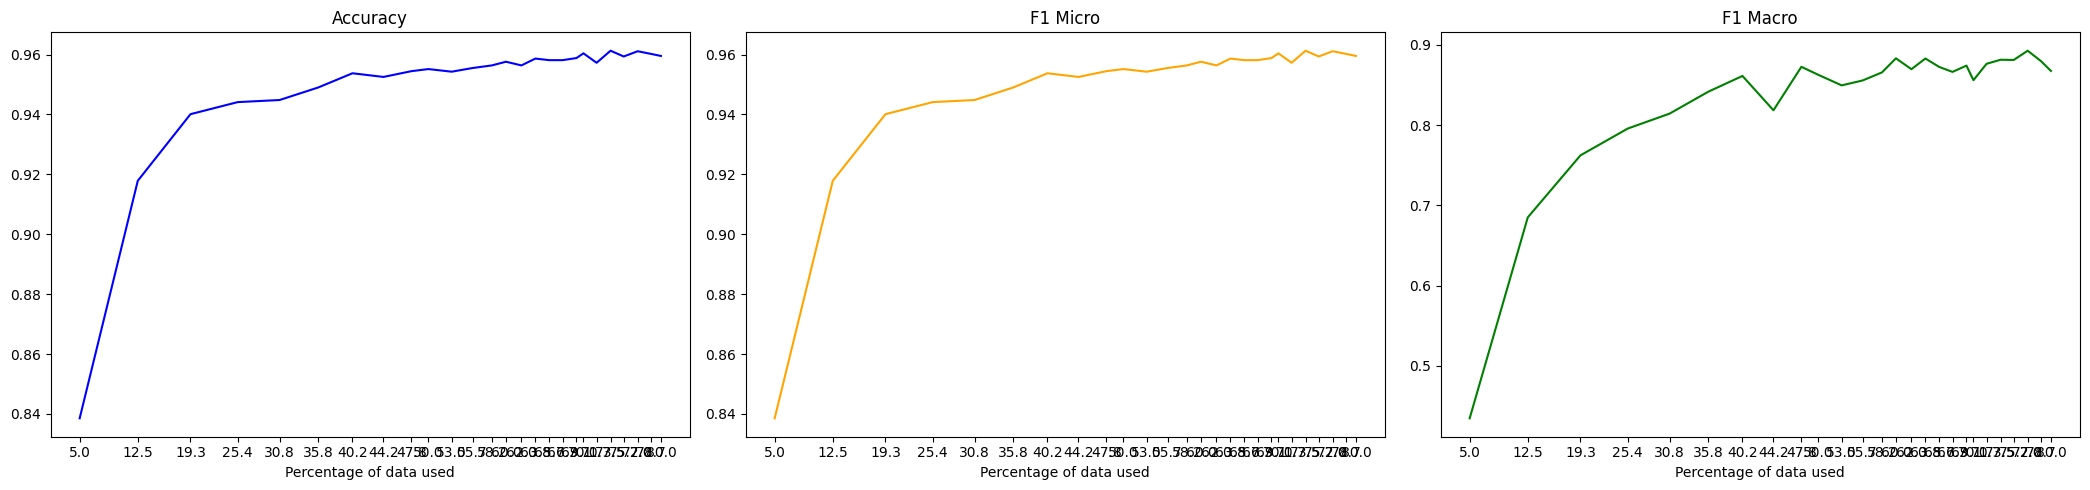

In [ ]:
active_learning(seeds[3], 3)

## RUN 5

TRIAL 5
Random seed: 94
Launching training on 2 GPUs.


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6222, Accuracy: 0.7984, F1 Micro: 0.8875, F1 Macro: 0.8819
Epoch 2/10, Train Loss: 0.4944, Accuracy: 0.7981, F1 Micro: 0.8873, F1 Macro: 0.8811
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4566, Accuracy: 0.7997, F1 Micro: 0.8881, F1 Macro: 0.8821
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.4288, Accuracy: 0.8017, F1 Micro: 0.8893, F1 Macro: 0.8836
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.4243, Accuracy: 0.804, F1 Micro: 0.8907, F1 Macro: 0.8857
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.4161, Accuracy: 0.8135, F1 Micro: 0.8944, F1 Macro: 0.8872
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.4005, Accuracy: 0.8179, F1 Micro: 0.8965, F1 Macro: 0.8903
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.3794, Accuracy: 0.8247, F1 Micro: 0.9001, F1 Macro: 0.8939
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.3213, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5506, Accuracy: 0.6036, F1 Micro: 0.6036, F1 Macro: 0.3764
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4796, Accuracy: 0.6036, F1 Micro: 0.6036, F1 Macro: 0.3764
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4879, Accuracy: 0.6036, F1 Micro: 0.6036, F1 Macro: 0.3764
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.4287, Accuracy: 0.6036, F1 Micro: 0.6036, F1 Macro: 0.3764
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3515, Accuracy: 0.6036, F1 Micro: 0.6036, F1 Macro: 0.3849
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.3279, Accuracy: 0.7, F1 Micro: 0.7, F1 Macro: 0.6242
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2793, Accuracy: 0.7073, F1 Micro: 0.7073, F1 Macro: 0.6432
Epoch 8/10, Train Loss: 0.202, Accuracy: 0.6873, F1 Micro: 0.6873, F1 Macro: 0.6008
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.2003, Accuracy: 0.7309, F1 Micro: 0.7

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5516, Accuracy: 0.801, F1 Micro: 0.8895, F1 Macro: 0.8852
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4382, Accuracy: 0.801, F1 Micro: 0.8895, F1 Macro: 0.8852
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4022, Accuracy: 0.8016, F1 Micro: 0.8898, F1 Macro: 0.8854
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3732, Accuracy: 0.8276, F1 Micro: 0.9025, F1 Macro: 0.8984
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3234, Accuracy: 0.8502, F1 Micro: 0.9138, F1 Macro: 0.9092
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2787, Accuracy: 0.8714, F1 Micro: 0.9251, F1 Macro: 0.9202
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2274, Accuracy: 0.9076, F1 Micro: 0.9446, F1 Macro: 0.9401
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.2025, Accuracy: 0.9177, F1 Micro: 0.9502, F1 Macro: 0.946
Higher F1 achieved, saving model
Epoch 9/1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4196, Accuracy: 0.7218, F1 Micro: 0.7218, F1 Macro: 0.4192
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3402, Accuracy: 0.7218, F1 Micro: 0.7218, F1 Macro: 0.4192
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2607, Accuracy: 0.805, F1 Micro: 0.805, F1 Macro: 0.7076
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1821, Accuracy: 0.8171, F1 Micro: 0.8171, F1 Macro: 0.7252
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1367, Accuracy: 0.8324, F1 Micro: 0.8324, F1 Macro: 0.7654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1295, Accuracy: 0.8401, F1 Micro: 0.8401, F1 Macro: 0.7743
Epoch 7/10, Train Loss: 0.0938, Accuracy: 0.8313, F1 Micro: 0.8313, F1 Macro: 0.7603
Epoch 8/10, Train Loss: 0.0775, Accuracy: 0.8072, F1 Micro: 0.8072, F1 Macro: 0.6834
Epoch 9/10, Train Loss: 0.0773, Accuracy: 0.8346, F1 Micro: 0.8346, F1 Macro: 0.7587
Epoch 10/10, Train Loss: 0.0852, Accura

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5169, Accuracy: 0.801, F1 Micro: 0.8895, F1 Macro: 0.8852
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4429, Accuracy: 0.8118, F1 Micro: 0.8927, F1 Macro: 0.8852
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3956, Accuracy: 0.8361, F1 Micro: 0.9054, F1 Macro: 0.8993
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3251, Accuracy: 0.8687, F1 Micro: 0.9224, F1 Macro: 0.9161
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2889, Accuracy: 0.9042, F1 Micro: 0.9421, F1 Macro: 0.9372
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2425, Accuracy: 0.9226, F1 Micro: 0.9531, F1 Macro: 0.9498
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1988, Accuracy: 0.9233, F1 Micro: 0.9536, F1 Macro: 0.9503
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1844, Accuracy: 0.9354, F1 Micro: 0.9604, F1 Macro: 0.9563
Higher F1 achieved, saving model
Epoch 9

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5812, Accuracy: 0.7226, F1 Micro: 0.7226, F1 Macro: 0.4687
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3755, Accuracy: 0.8092, F1 Micro: 0.8092, F1 Macro: 0.7104
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3051, Accuracy: 0.8457, F1 Micro: 0.8457, F1 Macro: 0.7914
Epoch 4/10, Train Loss: 0.2563, Accuracy: 0.8436, F1 Micro: 0.8436, F1 Macro: 0.8035
Epoch 5/10, Train Loss: 0.1834, Accuracy: 0.8436, F1 Micro: 0.8436, F1 Macro: 0.7766
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1425, Accuracy: 0.854, F1 Micro: 0.854, F1 Macro: 0.7942
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1244, Accuracy: 0.854, F1 Micro: 0.854, F1 Macro: 0.7961
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1326, Accuracy: 0.8592, F1 Micro: 0.8592, F1 Macro: 0.8043
Epoch 9/10, Train Loss: 0.0909, Accuracy: 0.8551, F1 Micro: 0.8551, F1 Macro: 0.796
Higher F1 achieved, saving model
Epoch 10/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5181, Accuracy: 0.8007, F1 Micro: 0.8892, F1 Macro: 0.8845
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4459, Accuracy: 0.8201, F1 Micro: 0.8974, F1 Macro: 0.8903
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3862, Accuracy: 0.8554, F1 Micro: 0.9154, F1 Macro: 0.9095
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3288, Accuracy: 0.9083, F1 Micro: 0.9452, F1 Macro: 0.9414
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2657, Accuracy: 0.9156, F1 Micro: 0.9494, F1 Macro: 0.9461
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2207, Accuracy: 0.9325, F1 Micro: 0.9587, F1 Macro: 0.9548
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1842, Accuracy: 0.9418, F1 Micro: 0.9645, F1 Macro: 0.9619
Epoch 8/10, Train Loss: 0.1601, Accuracy: 0.9385, F1 Micro: 0.9626, F1 Macro: 0.9599
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1397, Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5253, Accuracy: 0.7852, F1 Micro: 0.7852, F1 Macro: 0.7541
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3758, Accuracy: 0.846, F1 Micro: 0.846, F1 Macro: 0.7709
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2857, Accuracy: 0.8551, F1 Micro: 0.8551, F1 Macro: 0.8158
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2364, Accuracy: 0.8875, F1 Micro: 0.8875, F1 Macro: 0.847
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.217, Accuracy: 0.8977, F1 Micro: 0.8977, F1 Macro: 0.8596
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1378, Accuracy: 0.8997, F1 Micro: 0.8997, F1 Macro: 0.8616
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0982, Accuracy: 0.9007, F1 Micro: 0.9007, F1 Macro: 0.8636
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.095, Accuracy: 0.9027, F1 Micro: 0.9027, F1 Macro: 0.8714
Epoch 9/10, Train Loss: 0.086, Accuracy: 0.8987, F1 Micro: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5212, Accuracy: 0.801, F1 Micro: 0.8894, F1 Macro: 0.8849
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4444, Accuracy: 0.8368, F1 Micro: 0.9057, F1 Macro: 0.8993
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3553, Accuracy: 0.8941, F1 Micro: 0.937, F1 Macro: 0.9321
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2853, Accuracy: 0.9274, F1 Micro: 0.9561, F1 Macro: 0.9527
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2185, Accuracy: 0.9352, F1 Micro: 0.9607, F1 Macro: 0.9576
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1915, Accuracy: 0.9436, F1 Micro: 0.9655, F1 Macro: 0.9626
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.165, Accuracy: 0.9474, F1 Micro: 0.9678, F1 Macro: 0.9653
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1364, Accuracy: 0.951, F1 Micro: 0.9699, F1 Macro: 0.9672
Higher F1 achieved, saving model
Epoch 9/10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4957, Accuracy: 0.8111, F1 Micro: 0.8111, F1 Macro: 0.7158
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3534, Accuracy: 0.8581, F1 Micro: 0.8581, F1 Macro: 0.8037
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2774, Accuracy: 0.8869, F1 Micro: 0.8869, F1 Macro: 0.8536
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2209, Accuracy: 0.8907, F1 Micro: 0.8907, F1 Macro: 0.8572
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.163, Accuracy: 0.9032, F1 Micro: 0.9032, F1 Macro: 0.8743
Epoch 6/10, Train Loss: 0.1147, Accuracy: 0.8936, F1 Micro: 0.8936, F1 Macro: 0.8591
Epoch 7/10, Train Loss: 0.0864, Accuracy: 0.8897, F1 Micro: 0.8897, F1 Macro: 0.8517
Epoch 8/10, Train Loss: 0.0879, Accuracy: 0.884, F1 Micro: 0.884, F1 Macro: 0.8415
Epoch 9/10, Train Loss: 0.0605, Accuracy: 0.8955, F1 Micro: 0.8955, F1 Macro: 0.8646
Epoch 10/10, Train Loss: 0.043, Accuracy: 0.8907, F1 Micro: 0.8907, F1 Ma

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5205, Accuracy: 0.8026, F1 Micro: 0.8901, F1 Macro: 0.8854
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4258, Accuracy: 0.8599, F1 Micro: 0.9183, F1 Macro: 0.9119
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3303, Accuracy: 0.9189, F1 Micro: 0.9508, F1 Macro: 0.9462
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2575, Accuracy: 0.9342, F1 Micro: 0.96, F1 Macro: 0.9567
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2057, Accuracy: 0.9403, F1 Micro: 0.9636, F1 Macro: 0.9604
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1729, Accuracy: 0.9438, F1 Micro: 0.9657, F1 Macro: 0.9628
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1473, Accuracy: 0.9523, F1 Micro: 0.9706, F1 Macro: 0.9679
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1329, Accuracy: 0.9533, F1 Micro: 0.9712, F1 Macro: 0.9686
Higher F1 achieved, saving model
Epoch 9/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5154, Accuracy: 0.8487, F1 Micro: 0.8487, F1 Macro: 0.8051
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3357, Accuracy: 0.8684, F1 Micro: 0.8684, F1 Macro: 0.8219
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2309, Accuracy: 0.8919, F1 Micro: 0.8919, F1 Macro: 0.8575
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1859, Accuracy: 0.9023, F1 Micro: 0.9023, F1 Macro: 0.8731
Epoch 5/10, Train Loss: 0.1441, Accuracy: 0.8919, F1 Micro: 0.8919, F1 Macro: 0.8557
Epoch 6/10, Train Loss: 0.1126, Accuracy: 0.89, F1 Micro: 0.89, F1 Macro: 0.8501
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0853, Accuracy: 0.9023, F1 Micro: 0.9023, F1 Macro: 0.8722
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0539, Accuracy: 0.907, F1 Micro: 0.907, F1 Macro: 0.8791
Epoch 9/10, Train Loss: 0.0601, Accuracy: 0.9051, F1 Micro: 0.9051, F1 Macro: 0.8763
Higher F1 achieved, saving model
Epoch 10/1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5156, Accuracy: 0.8083, F1 Micro: 0.8924, F1 Macro: 0.8862
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4089, Accuracy: 0.8934, F1 Micro: 0.9358, F1 Macro: 0.9277
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3013, Accuracy: 0.9285, F1 Micro: 0.9567, F1 Macro: 0.9532
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2368, Accuracy: 0.9394, F1 Micro: 0.9631, F1 Macro: 0.9604
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.192, Accuracy: 0.9484, F1 Micro: 0.9683, F1 Macro: 0.9654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1569, Accuracy: 0.9545, F1 Micro: 0.9719, F1 Macro: 0.9691
Epoch 7/10, Train Loss: 0.1344, Accuracy: 0.9479, F1 Micro: 0.9681, F1 Macro: 0.9654
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1173, Accuracy: 0.9585, F1 Micro: 0.9743, F1 Macro: 0.9716
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1029, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4569, Accuracy: 0.8037, F1 Micro: 0.8037, F1 Macro: 0.7038
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3402, Accuracy: 0.8645, F1 Micro: 0.8645, F1 Macro: 0.8208
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2376, Accuracy: 0.8737, F1 Micro: 0.8737, F1 Macro: 0.8292
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1688, Accuracy: 0.894, F1 Micro: 0.894, F1 Macro: 0.8624
Epoch 5/10, Train Loss: 0.124, Accuracy: 0.8857, F1 Micro: 0.8857, F1 Macro: 0.8479
Epoch 6/10, Train Loss: 0.1162, Accuracy: 0.8857, F1 Micro: 0.8857, F1 Macro: 0.8483
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0977, Accuracy: 0.8995, F1 Micro: 0.8995, F1 Macro: 0.8684
Epoch 8/10, Train Loss: 0.0522, Accuracy: 0.8959, F1 Micro: 0.8959, F1 Macro: 0.8632
Epoch 9/10, Train Loss: 0.0475, Accuracy: 0.8949, F1 Micro: 0.8949, F1 Macro: 0.8605
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0464, Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5073, Accuracy: 0.8191, F1 Micro: 0.8972, F1 Macro: 0.8904
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3948, Accuracy: 0.9024, F1 Micro: 0.9417, F1 Macro: 0.9368
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2831, Accuracy: 0.9349, F1 Micro: 0.9603, F1 Macro: 0.957
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2139, Accuracy: 0.9444, F1 Micro: 0.966, F1 Macro: 0.9633
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1788, Accuracy: 0.9469, F1 Micro: 0.9675, F1 Macro: 0.9649
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1491, Accuracy: 0.954, F1 Micro: 0.9716, F1 Macro: 0.969
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1333, Accuracy: 0.9583, F1 Micro: 0.9743, F1 Macro: 0.9717
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1143, Accuracy: 0.9589, F1 Micro: 0.9745, F1 Macro: 0.972
Higher F1 achieved, saving model
Epoch 9/10,

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4436, Accuracy: 0.8673, F1 Micro: 0.8673, F1 Macro: 0.8262
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2682, Accuracy: 0.8796, F1 Micro: 0.8796, F1 Macro: 0.8394
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2315, Accuracy: 0.8948, F1 Micro: 0.8948, F1 Macro: 0.8596
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1295, Accuracy: 0.9081, F1 Micro: 0.9081, F1 Macro: 0.8828
Epoch 5/10, Train Loss: 0.1091, Accuracy: 0.9052, F1 Micro: 0.9052, F1 Macro: 0.8753
Epoch 6/10, Train Loss: 0.0702, Accuracy: 0.9024, F1 Micro: 0.9024, F1 Macro: 0.8704
Epoch 7/10, Train Loss: 0.0604, Accuracy: 0.9024, F1 Micro: 0.9024, F1 Macro: 0.8726
Epoch 8/10, Train Loss: 0.0524, Accuracy: 0.9043, F1 Micro: 0.9043, F1 Macro: 0.8757
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0373, Accuracy: 0.9081, F1 Micro: 0.9081, F1 Macro: 0.8803
Epoch 10/10, Train Loss: 0.0447, Accuracy: 0.8976, F1 Micro: 0.8976, F

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5004, Accuracy: 0.8118, F1 Micro: 0.8944, F1 Macro: 0.889
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3722, Accuracy: 0.901, F1 Micro: 0.9414, F1 Macro: 0.9375
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2435, Accuracy: 0.9363, F1 Micro: 0.9613, F1 Macro: 0.9584
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2049, Accuracy: 0.9453, F1 Micro: 0.9664, F1 Macro: 0.9635
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1578, Accuracy: 0.9514, F1 Micro: 0.9701, F1 Macro: 0.9676
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1424, Accuracy: 0.9557, F1 Micro: 0.9726, F1 Macro: 0.9696
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1203, Accuracy: 0.9604, F1 Micro: 0.9755, F1 Macro: 0.9729
Epoch 8/10, Train Loss: 0.1037, Accuracy: 0.9587, F1 Micro: 0.9744, F1 Macro: 0.9719
Epoch 9/10, Train Loss: 0.0866, Accuracy: 0.9601, F1 Micro: 0.9751, F1 Mac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4464, Accuracy: 0.8407, F1 Micro: 0.8407, F1 Macro: 0.808
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.273, Accuracy: 0.8878, F1 Micro: 0.8878, F1 Macro: 0.8545
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1965, Accuracy: 0.8992, F1 Micro: 0.8992, F1 Macro: 0.8676
Epoch 4/10, Train Loss: 0.1229, Accuracy: 0.8907, F1 Micro: 0.8907, F1 Macro: 0.853
Epoch 5/10, Train Loss: 0.0989, Accuracy: 0.8963, F1 Micro: 0.8963, F1 Macro: 0.8624
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0631, Accuracy: 0.8992, F1 Micro: 0.8992, F1 Macro: 0.8666
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0552, Accuracy: 0.9114, F1 Micro: 0.9114, F1 Macro: 0.8841
Epoch 8/10, Train Loss: 0.0505, Accuracy: 0.9086, F1 Micro: 0.9086, F1 Macro: 0.8808
Epoch 9/10, Train Loss: 0.0491, Accuracy: 0.902, F1 Micro: 0.902, F1 Macro: 0.8753
Epoch 10/10, Train Loss: 0.039, Accuracy: 0.9095, F1 Micro: 0.9095, F1 Macr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4974, Accuracy: 0.8189, F1 Micro: 0.8979, F1 Macro: 0.8924
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3694, Accuracy: 0.9108, F1 Micro: 0.9467, F1 Macro: 0.943
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2483, Accuracy: 0.9358, F1 Micro: 0.9607, F1 Macro: 0.9564
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1959, Accuracy: 0.9484, F1 Micro: 0.9684, F1 Macro: 0.9662
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1623, Accuracy: 0.9507, F1 Micro: 0.9697, F1 Macro: 0.9667
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1368, Accuracy: 0.9559, F1 Micro: 0.9728, F1 Macro: 0.9703
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.119, Accuracy: 0.9599, F1 Micro: 0.9752, F1 Macro: 0.9728
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1006, Accuracy: 0.9602, F1 Micro: 0.9754, F1 Macro: 0.973
Higher F1 achieved, saving model
Epoch 9/1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4406, Accuracy: 0.8665, F1 Micro: 0.8665, F1 Macro: 0.8299
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2861, Accuracy: 0.8842, F1 Micro: 0.8842, F1 Macro: 0.8488
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1979, Accuracy: 0.9055, F1 Micro: 0.9055, F1 Macro: 0.8773
Epoch 4/10, Train Loss: 0.1273, Accuracy: 0.9018, F1 Micro: 0.9018, F1 Macro: 0.8734
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1219, Accuracy: 0.9073, F1 Micro: 0.9073, F1 Macro: 0.8808
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.065, Accuracy: 0.9082, F1 Micro: 0.9082, F1 Macro: 0.8837
Epoch 7/10, Train Loss: 0.063, Accuracy: 0.9045, F1 Micro: 0.9045, F1 Macro: 0.876
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0567, Accuracy: 0.9101, F1 Micro: 0.9101, F1 Macro: 0.8842
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0421, Accuracy: 0.9138, F1 Micro: 0.9138, F1 Macro: 0.8898
Epoch 1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4906, Accuracy: 0.8203, F1 Micro: 0.8984, F1 Macro: 0.8933
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.354, Accuracy: 0.9226, F1 Micro: 0.9531, F1 Macro: 0.9489
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2375, Accuracy: 0.9425, F1 Micro: 0.9649, F1 Macro: 0.9622
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1873, Accuracy: 0.9495, F1 Micro: 0.9689, F1 Macro: 0.9666
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1579, Accuracy: 0.9568, F1 Micro: 0.9733, F1 Macro: 0.9706
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1394, Accuracy: 0.9592, F1 Micro: 0.9747, F1 Macro: 0.9722
Epoch 7/10, Train Loss: 0.111, Accuracy: 0.9589, F1 Micro: 0.9746, F1 Macro: 0.9721
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0914, Accuracy: 0.9592, F1 Micro: 0.9747, F1 Macro: 0.9724
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0826, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4154, Accuracy: 0.8619, F1 Micro: 0.8619, F1 Macro: 0.8139
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2382, Accuracy: 0.8897, F1 Micro: 0.8897, F1 Macro: 0.8614
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1723, Accuracy: 0.9027, F1 Micro: 0.9027, F1 Macro: 0.8771
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1368, Accuracy: 0.9045, F1 Micro: 0.9045, F1 Macro: 0.8751
Epoch 5/10, Train Loss: 0.0904, Accuracy: 0.9018, F1 Micro: 0.9018, F1 Macro: 0.8691
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0743, Accuracy: 0.9092, F1 Micro: 0.9092, F1 Macro: 0.8824
Epoch 7/10, Train Loss: 0.0582, Accuracy: 0.8999, F1 Micro: 0.8999, F1 Macro: 0.8679
Epoch 8/10, Train Loss: 0.0351, Accuracy: 0.899, F1 Micro: 0.899, F1 Macro: 0.8665
Epoch 9/10, Train Loss: 0.0423, Accuracy: 0.9064, F1 Micro: 0.9064, F1 Macro: 0.8811
Epoch 10/10, Train Loss: 0.0268, Accuracy: 0.9064, F1 Micro: 0.9064, F1 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4843, Accuracy: 0.8313, F1 Micro: 0.9027, F1 Macro: 0.8942
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3361, Accuracy: 0.9241, F1 Micro: 0.954, F1 Macro: 0.95
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2274, Accuracy: 0.9444, F1 Micro: 0.966, F1 Macro: 0.9632
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1831, Accuracy: 0.9491, F1 Micro: 0.9688, F1 Macro: 0.9664
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1515, Accuracy: 0.958, F1 Micro: 0.974, F1 Macro: 0.9714
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1282, Accuracy: 0.9602, F1 Micro: 0.9754, F1 Macro: 0.9733
Epoch 7/10, Train Loss: 0.1062, Accuracy: 0.9601, F1 Micro: 0.9752, F1 Macro: 0.9728
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0915, Accuracy: 0.9609, F1 Micro: 0.9758, F1 Macro: 0.9734
Epoch 9/10, Train Loss: 0.0784, Accuracy: 0.9583, F1 Micro: 0.9743, F1 Macro: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4289, Accuracy: 0.8561, F1 Micro: 0.8561, F1 Macro: 0.81
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2455, Accuracy: 0.8801, F1 Micro: 0.8801, F1 Macro: 0.8449
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1746, Accuracy: 0.8884, F1 Micro: 0.8884, F1 Macro: 0.8517
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.119, Accuracy: 0.9004, F1 Micro: 0.9004, F1 Macro: 0.87
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0883, Accuracy: 0.9013, F1 Micro: 0.9013, F1 Macro: 0.871
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0621, Accuracy: 0.9022, F1 Micro: 0.9022, F1 Macro: 0.8712
Epoch 7/10, Train Loss: 0.0573, Accuracy: 0.8994, F1 Micro: 0.8994, F1 Macro: 0.8692
Epoch 8/10, Train Loss: 0.0486, Accuracy: 0.9004, F1 Micro: 0.9004, F1 Macro: 0.8697
Epoch 9/10, Train Loss: 0.0254, Accuracy: 0.8994, F1 Micro: 0.8994, F1 Macro: 0.8671
Higher F1 achieved, saving model
Epoch 10/1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.482, Accuracy: 0.8293, F1 Micro: 0.9031, F1 Macro: 0.899
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3324, Accuracy: 0.9219, F1 Micro: 0.953, F1 Macro: 0.9499
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.223, Accuracy: 0.9429, F1 Micro: 0.9652, F1 Macro: 0.9627
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.178, Accuracy: 0.9533, F1 Micro: 0.9712, F1 Macro: 0.9686
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1423, Accuracy: 0.9576, F1 Micro: 0.9738, F1 Macro: 0.9711
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1219, Accuracy: 0.9602, F1 Micro: 0.9754, F1 Macro: 0.9729
Epoch 7/10, Train Loss: 0.1035, Accuracy: 0.9594, F1 Micro: 0.9748, F1 Macro: 0.9721
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0901, Accuracy: 0.9639, F1 Micro: 0.9776, F1 Macro: 0.9756
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0774, Accuracy: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3944, Accuracy: 0.8566, F1 Micro: 0.8566, F1 Macro: 0.8205
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.24, Accuracy: 0.898, F1 Micro: 0.898, F1 Macro: 0.8654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1694, Accuracy: 0.9035, F1 Micro: 0.9035, F1 Macro: 0.8756
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1153, Accuracy: 0.9081, F1 Micro: 0.9081, F1 Macro: 0.8792
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0988, Accuracy: 0.9081, F1 Micro: 0.9081, F1 Macro: 0.8811
Epoch 6/10, Train Loss: 0.0778, Accuracy: 0.9026, F1 Micro: 0.9026, F1 Macro: 0.8757
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0572, Accuracy: 0.909, F1 Micro: 0.909, F1 Macro: 0.8827
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0434, Accuracy: 0.9154, F1 Micro: 0.9154, F1 Macro: 0.8899
Epoch 9/10, Train Loss: 0.0299, Accuracy: 0.9136, F1 Micro: 0.9136, F1 Macro: 0.887
Epoch 10/10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4798, Accuracy: 0.8313, F1 Micro: 0.9039, F1 Macro: 0.8989
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3216, Accuracy: 0.9278, F1 Micro: 0.9564, F1 Macro: 0.9531
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2143, Accuracy: 0.9443, F1 Micro: 0.9659, F1 Macro: 0.9638
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1763, Accuracy: 0.9556, F1 Micro: 0.9726, F1 Macro: 0.9701
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1423, Accuracy: 0.9566, F1 Micro: 0.9732, F1 Macro: 0.9708
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1184, Accuracy: 0.9608, F1 Micro: 0.9757, F1 Macro: 0.9734
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1028, Accuracy: 0.9613, F1 Micro: 0.976, F1 Macro: 0.9738
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0849, Accuracy: 0.9644, F1 Micro: 0.9779, F1 Macro: 0.9757
Epoch 9/10, Train Loss: 0.0718, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3996, Accuracy: 0.8606, F1 Micro: 0.8606, F1 Macro: 0.8204
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.225, Accuracy: 0.899, F1 Micro: 0.899, F1 Macro: 0.8736
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1684, Accuracy: 0.9036, F1 Micro: 0.9036, F1 Macro: 0.8713
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1134, Accuracy: 0.9139, F1 Micro: 0.9139, F1 Macro: 0.8882
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0853, Accuracy: 0.9205, F1 Micro: 0.9205, F1 Macro: 0.8978
Epoch 6/10, Train Loss: 0.0726, Accuracy: 0.9158, F1 Micro: 0.9158, F1 Macro: 0.8931
Epoch 7/10, Train Loss: 0.0563, Accuracy: 0.9121, F1 Micro: 0.9121, F1 Macro: 0.8886
Epoch 8/10, Train Loss: 0.0398, Accuracy: 0.9149, F1 Micro: 0.9149, F1 Macro: 0.8927
Epoch 9/10, Train Loss: 0.0454, Accuracy: 0.9186, F1 Micro: 0.9186, F1 Macro: 0.8946
Epoch 10/10, Train Loss: 0.0298, Accuracy: 0.9158, F1 Micro: 0.9158, F1 M

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4728, Accuracy: 0.8457, F1 Micro: 0.9112, F1 Macro: 0.9066
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3045, Accuracy: 0.9321, F1 Micro: 0.9589, F1 Macro: 0.9563
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2121, Accuracy: 0.9434, F1 Micro: 0.9653, F1 Macro: 0.9624
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1663, Accuracy: 0.9516, F1 Micro: 0.9703, F1 Macro: 0.968
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1351, Accuracy: 0.9597, F1 Micro: 0.9751, F1 Macro: 0.9725
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1155, Accuracy: 0.9632, F1 Micro: 0.9772, F1 Macro: 0.9748
Epoch 7/10, Train Loss: 0.0988, Accuracy: 0.9628, F1 Micro: 0.9768, F1 Macro: 0.9745
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0844, Accuracy: 0.9632, F1 Micro: 0.9772, F1 Macro: 0.9752
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0709, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4017, Accuracy: 0.8626, F1 Micro: 0.8626, F1 Macro: 0.8162
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.249, Accuracy: 0.8935, F1 Micro: 0.8935, F1 Macro: 0.861
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1713, Accuracy: 0.9026, F1 Micro: 0.9026, F1 Macro: 0.8743
Epoch 4/10, Train Loss: 0.1016, Accuracy: 0.9017, F1 Micro: 0.9017, F1 Macro: 0.8744
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0699, Accuracy: 0.9117, F1 Micro: 0.9117, F1 Macro: 0.8865
Epoch 6/10, Train Loss: 0.0539, Accuracy: 0.909, F1 Micro: 0.909, F1 Macro: 0.8829
Epoch 7/10, Train Loss: 0.0337, Accuracy: 0.9045, F1 Micro: 0.9045, F1 Macro: 0.8795
Epoch 8/10, Train Loss: 0.0571, Accuracy: 0.8999, F1 Micro: 0.8999, F1 Macro: 0.8697
Epoch 9/10, Train Loss: 0.0325, Accuracy: 0.9008, F1 Micro: 0.9008, F1 Macro: 0.8728
Epoch 10/10, Train Loss: 0.0349, Accuracy: 0.9054, F1 Micro: 0.9054, F1 Macro: 0.8774

Sentiment analysis a

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.481, Accuracy: 0.8425, F1 Micro: 0.9097, F1 Macro: 0.9052
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.312, Accuracy: 0.9356, F1 Micro: 0.9607, F1 Macro: 0.958
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2117, Accuracy: 0.9469, F1 Micro: 0.9674, F1 Macro: 0.9653
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1669, Accuracy: 0.9556, F1 Micro: 0.9725, F1 Macro: 0.9697
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1414, Accuracy: 0.9592, F1 Micro: 0.9747, F1 Macro: 0.9721
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1145, Accuracy: 0.9641, F1 Micro: 0.9777, F1 Macro: 0.9756
Epoch 7/10, Train Loss: 0.1003, Accuracy: 0.9616, F1 Micro: 0.9763, F1 Macro: 0.9742
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0824, Accuracy: 0.9642, F1 Micro: 0.9778, F1 Macro: 0.9758
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0708, Accuracy: 

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3839, Accuracy: 0.859, F1 Micro: 0.859, F1 Macro: 0.8074
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2356, Accuracy: 0.8924, F1 Micro: 0.8924, F1 Macro: 0.8638
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.168, Accuracy: 0.9033, F1 Micro: 0.9033, F1 Macro: 0.874
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1258, Accuracy: 0.9096, F1 Micro: 0.9096, F1 Macro: 0.8832
Epoch 5/10, Train Loss: 0.0892, Accuracy: 0.9024, F1 Micro: 0.9024, F1 Macro: 0.8727
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0611, Accuracy: 0.9105, F1 Micro: 0.9105, F1 Macro: 0.8867
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0408, Accuracy: 0.9141, F1 Micro: 0.9141, F1 Macro: 0.8906
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0424, Accuracy: 0.9141, F1 Micro: 0.9141, F1 Macro: 0.891
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0303, Accuracy: 0.915, F1 Micro: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4705, Accuracy: 0.8398, F1 Micro: 0.9085, F1 Macro: 0.9036
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2994, Accuracy: 0.9387, F1 Micro: 0.9626, F1 Macro: 0.96
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2009, Accuracy: 0.9457, F1 Micro: 0.9667, F1 Macro: 0.9643
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1569, Accuracy: 0.9543, F1 Micro: 0.9718, F1 Macro: 0.9691
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1304, Accuracy: 0.9613, F1 Micro: 0.976, F1 Macro: 0.9735
Epoch 6/10, Train Loss: 0.1126, Accuracy: 0.9604, F1 Micro: 0.9755, F1 Macro: 0.9731
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0917, Accuracy: 0.9616, F1 Micro: 0.9762, F1 Macro: 0.9739
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0808, Accuracy: 0.9642, F1 Micro: 0.9778, F1 Macro: 0.9753
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0687, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3835, Accuracy: 0.8562, F1 Micro: 0.8562, F1 Macro: 0.8061
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2298, Accuracy: 0.8899, F1 Micro: 0.8899, F1 Macro: 0.8531
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1478, Accuracy: 0.8899, F1 Micro: 0.8899, F1 Macro: 0.8517
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1095, Accuracy: 0.9045, F1 Micro: 0.9045, F1 Macro: 0.8743
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0841, Accuracy: 0.9099, F1 Micro: 0.9099, F1 Macro: 0.8834
Epoch 6/10, Train Loss: 0.0632, Accuracy: 0.9035, F1 Micro: 0.9035, F1 Macro: 0.8733
Epoch 7/10, Train Loss: 0.0484, Accuracy: 0.9081, F1 Micro: 0.9081, F1 Macro: 0.8821
Epoch 8/10, Train Loss: 0.0378, Accuracy: 0.9008, F1 Micro: 0.9008, F1 Macro: 0.8716
Epoch 9/10, Train Loss: 0.0416, Accuracy: 0.9081, F1 Micro: 0.9081, F1 Macro: 0.8797
Epoch 10/10, Train Loss: 0.0344, Accuracy: 0.9045, F1 Micro: 0.9045, F

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION


Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4697, Accuracy: 0.8635, F1 Micro: 0.9202, F1 Macro: 0.9146
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.288, Accuracy: 0.9368, F1 Micro: 0.9614, F1 Macro: 0.9584
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1987, Accuracy: 0.9507, F1 Micro: 0.9697, F1 Macro: 0.9674
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1555, Accuracy: 0.9519, F1 Micro: 0.9704, F1 Macro: 0.968
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1306, Accuracy: 0.9543, F1 Micro: 0.9718, F1 Macro: 0.9685
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1129, Accuracy: 0.9653, F1 Micro: 0.9784, F1 Macro: 0.9765
Epoch 7/10, Train Loss: 0.0901, Accuracy: 0.9637, F1 Micro: 0.9774, F1 Macro: 0.975
Epoch 8/10, Train Loss: 0.0747, Accuracy: 0.9637, F1 Micro: 0.9775, F1 Macro: 0.9753
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0641, Accuracy: 0.9672, F1 Micro: 0.9796, F1 Macro: 0.9778
Epoch 1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3549, Accuracy: 0.8686, F1 Micro: 0.8686, F1 Macro: 0.8323
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1982, Accuracy: 0.9042, F1 Micro: 0.9042, F1 Macro: 0.8754
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1472, Accuracy: 0.9115, F1 Micro: 0.9115, F1 Macro: 0.8872
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1006, Accuracy: 0.9115, F1 Micro: 0.9115, F1 Macro: 0.8874
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.071, Accuracy: 0.9115, F1 Micro: 0.9115, F1 Macro: 0.8884
Epoch 6/10, Train Loss: 0.0607, Accuracy: 0.9042, F1 Micro: 0.9042, F1 Macro: 0.8712
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0591, Accuracy: 0.9151, F1 Micro: 0.9151, F1 Macro: 0.8927
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.043, Accuracy: 0.9188, F1 Micro: 0.9188, F1 Macro: 0.8944
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0182, Accuracy: 0.9197, F1 Micro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4628, Accuracy: 0.866, F1 Micro: 0.9212, F1 Macro: 0.9151
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2791, Accuracy: 0.9352, F1 Micro: 0.9606, F1 Macro: 0.9581
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1936, Accuracy: 0.9472, F1 Micro: 0.9677, F1 Macro: 0.9657
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1521, Accuracy: 0.9526, F1 Micro: 0.9708, F1 Macro: 0.9683
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1252, Accuracy: 0.9618, F1 Micro: 0.9763, F1 Macro: 0.9739
Epoch 6/10, Train Loss: 0.1004, Accuracy: 0.9613, F1 Micro: 0.9759, F1 Macro: 0.9728
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0868, Accuracy: 0.9625, F1 Micro: 0.9767, F1 Macro: 0.9741
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0736, Accuracy: 0.9644, F1 Micro: 0.9779, F1 Macro: 0.9757
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0613, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3599, Accuracy: 0.8567, F1 Micro: 0.8567, F1 Macro: 0.8003
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2233, Accuracy: 0.8871, F1 Micro: 0.8871, F1 Macro: 0.8464
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.145, Accuracy: 0.9063, F1 Micro: 0.9063, F1 Macro: 0.8783
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.0947, Accuracy: 0.9063, F1 Micro: 0.9063, F1 Macro: 0.8771
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0753, Accuracy: 0.9137, F1 Micro: 0.9137, F1 Macro: 0.8859
Epoch 6/10, Train Loss: 0.0499, Accuracy: 0.9118, F1 Micro: 0.9118, F1 Macro: 0.8862
Epoch 7/10, Train Loss: 0.0388, Accuracy: 0.9073, F1 Micro: 0.9073, F1 Macro: 0.8801
Epoch 8/10, Train Loss: 0.0347, Accuracy: 0.9073, F1 Micro: 0.9073, F1 Macro: 0.8801
Epoch 9/10, Train Loss: 0.028, Accuracy: 0.899, F1 Micro: 0.899, F1 Macro: 0.8632
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0287, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4625, Accuracy: 0.8755, F1 Micro: 0.9258, F1 Macro: 0.9176
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2766, Accuracy: 0.9352, F1 Micro: 0.9606, F1 Macro: 0.9578
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1952, Accuracy: 0.9476, F1 Micro: 0.9679, F1 Macro: 0.9656
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1577, Accuracy: 0.9517, F1 Micro: 0.9704, F1 Macro: 0.9682
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.131, Accuracy: 0.9592, F1 Micro: 0.9748, F1 Macro: 0.9725
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.105, Accuracy: 0.9602, F1 Micro: 0.9754, F1 Macro: 0.973
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0887, Accuracy: 0.9623, F1 Micro: 0.9766, F1 Macro: 0.9745
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0763, Accuracy: 0.9661, F1 Micro: 0.979, F1 Macro: 0.9772
Epoch 9/10, Train Loss: 0.0644, Accuracy: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3504, Accuracy: 0.8699, F1 Micro: 0.8699, F1 Macro: 0.8268
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2234, Accuracy: 0.9105, F1 Micro: 0.9105, F1 Macro: 0.8836
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.145, Accuracy: 0.9151, F1 Micro: 0.9151, F1 Macro: 0.8903
Epoch 4/10, Train Loss: 0.0848, Accuracy: 0.9114, F1 Micro: 0.9114, F1 Macro: 0.8833
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0813, Accuracy: 0.9179, F1 Micro: 0.9179, F1 Macro: 0.8951
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0581, Accuracy: 0.9179, F1 Micro: 0.9179, F1 Macro: 0.8937
Epoch 7/10, Train Loss: 0.0476, Accuracy: 0.9124, F1 Micro: 0.9124, F1 Macro: 0.8855
Epoch 8/10, Train Loss: 0.0539, Accuracy: 0.9077, F1 Micro: 0.9077, F1 Macro: 0.8815
Epoch 9/10, Train Loss: 0.0294, Accuracy: 0.9105, F1 Micro: 0.9105, F1 Macro: 0.8852
Epoch 10/10, Train Loss: 0.0342, Accuracy: 0.9077, F1 Micro: 0.9077, F1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.457, Accuracy: 0.8623, F1 Micro: 0.9201, F1 Macro: 0.9161
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2735, Accuracy: 0.938, F1 Micro: 0.9621, F1 Macro: 0.9597
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1937, Accuracy: 0.949, F1 Micro: 0.9687, F1 Macro: 0.9664
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1533, Accuracy: 0.9559, F1 Micro: 0.9728, F1 Macro: 0.9705
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1222, Accuracy: 0.9632, F1 Micro: 0.9772, F1 Macro: 0.9751
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1027, Accuracy: 0.9646, F1 Micro: 0.978, F1 Macro: 0.9759
Epoch 7/10, Train Loss: 0.0874, Accuracy: 0.9641, F1 Micro: 0.9777, F1 Macro: 0.9755
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0721, Accuracy: 0.9655, F1 Micro: 0.9785, F1 Macro: 0.9763
Epoch 9/10, Train Loss: 0.0604, Accuracy: 0.9646, F1 Micro: 0.978, F1 Macro:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3437, Accuracy: 0.8631, F1 Micro: 0.8631, F1 Macro: 0.8185
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2031, Accuracy: 0.8928, F1 Micro: 0.8928, F1 Macro: 0.8604
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.152, Accuracy: 0.8955, F1 Micro: 0.8955, F1 Macro: 0.8643
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1068, Accuracy: 0.8982, F1 Micro: 0.8982, F1 Macro: 0.8705
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0806, Accuracy: 0.9054, F1 Micro: 0.9054, F1 Macro: 0.8781
Epoch 6/10, Train Loss: 0.0656, Accuracy: 0.9045, F1 Micro: 0.9045, F1 Macro: 0.8782
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0444, Accuracy: 0.9081, F1 Micro: 0.9081, F1 Macro: 0.8818
Epoch 8/10, Train Loss: 0.0399, Accuracy: 0.9027, F1 Micro: 0.9027, F1 Macro: 0.8745
Epoch 9/10, Train Loss: 0.0419, Accuracy: 0.9072, F1 Micro: 0.9072, F1 Macro: 0.8791
Epoch 10/10, Train Loss: 0.0333, Accur

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4543, Accuracy: 0.8753, F1 Micro: 0.9261, F1 Macro: 0.9195
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2663, Accuracy: 0.9418, F1 Micro: 0.9645, F1 Macro: 0.9621
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.189, Accuracy: 0.9502, F1 Micro: 0.9694, F1 Macro: 0.967
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1478, Accuracy: 0.9575, F1 Micro: 0.9737, F1 Macro: 0.9715
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1181, Accuracy: 0.9608, F1 Micro: 0.9757, F1 Macro: 0.9733
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1043, Accuracy: 0.9623, F1 Micro: 0.9766, F1 Macro: 0.9746
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0848, Accuracy: 0.9641, F1 Micro: 0.9777, F1 Macro: 0.9758
Epoch 8/10, Train Loss: 0.0724, Accuracy: 0.9641, F1 Micro: 0.9777, F1 Macro: 0.9756
Epoch 9/10, Train Loss: 0.0607, Accuracy: 0.9635, F1 Micro: 0.9774, F1 Mac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3564, Accuracy: 0.8429, F1 Micro: 0.8429, F1 Macro: 0.8166
Epoch 2/10, Train Loss: 0.2131, Accuracy: 0.8393, F1 Micro: 0.8393, F1 Macro: 0.7631
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.161, Accuracy: 0.9005, F1 Micro: 0.9005, F1 Macro: 0.87
Epoch 4/10, Train Loss: 0.1217, Accuracy: 0.8995, F1 Micro: 0.8995, F1 Macro: 0.8687
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0725, Accuracy: 0.905, F1 Micro: 0.905, F1 Macro: 0.8806
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0605, Accuracy: 0.905, F1 Micro: 0.905, F1 Macro: 0.878
Epoch 7/10, Train Loss: 0.0503, Accuracy: 0.9032, F1 Micro: 0.9032, F1 Macro: 0.8762
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0334, Accuracy: 0.9078, F1 Micro: 0.9078, F1 Macro: 0.8822
Epoch 9/10, Train Loss: 0.0236, Accuracy: 0.8995, F1 Micro: 0.8995, F1 Macro: 0.8704
Epoch 10/10, Train Loss: 0.0278, Accuracy: 0.905, F1 Micro: 0.905, F1 Macro: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4459, Accuracy: 0.8774, F1 Micro: 0.9271, F1 Macro: 0.9203
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2617, Accuracy: 0.9413, F1 Micro: 0.9641, F1 Macro: 0.9613
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1829, Accuracy: 0.951, F1 Micro: 0.9699, F1 Macro: 0.9676
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1489, Accuracy: 0.9559, F1 Micro: 0.9728, F1 Macro: 0.9708
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1186, Accuracy: 0.9601, F1 Micro: 0.9753, F1 Macro: 0.9726
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0984, Accuracy: 0.9644, F1 Micro: 0.9779, F1 Macro: 0.9758
Epoch 7/10, Train Loss: 0.0825, Accuracy: 0.9639, F1 Micro: 0.9776, F1 Macro: 0.9756
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0692, Accuracy: 0.9644, F1 Micro: 0.9779, F1 Macro: 0.976
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0578, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3619, Accuracy: 0.873, F1 Micro: 0.873, F1 Macro: 0.8276
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.202, Accuracy: 0.9055, F1 Micro: 0.9055, F1 Macro: 0.8743
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1267, Accuracy: 0.9092, F1 Micro: 0.9092, F1 Macro: 0.8813
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.0971, Accuracy: 0.9194, F1 Micro: 0.9194, F1 Macro: 0.8966
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.06, Accuracy: 0.9194, F1 Micro: 0.9194, F1 Macro: 0.8971
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0649, Accuracy: 0.9231, F1 Micro: 0.9231, F1 Macro: 0.9009
Epoch 7/10, Train Loss: 0.0377, Accuracy: 0.9138, F1 Micro: 0.9138, F1 Macro: 0.8893
Epoch 8/10, Train Loss: 0.0351, Accuracy: 0.9064, F1 Micro: 0.9064, F1 Macro: 0.8772
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0315, Accuracy: 0.9231, F1 Micro: 0.9231, F1 Macro: 0.8991
Epoch 10/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4473, Accuracy: 0.8804, F1 Micro: 0.929, F1 Macro: 0.9222
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2617, Accuracy: 0.9384, F1 Micro: 0.9624, F1 Macro: 0.9598
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1822, Accuracy: 0.9507, F1 Micro: 0.9697, F1 Macro: 0.9673
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1497, Accuracy: 0.9594, F1 Micro: 0.9749, F1 Macro: 0.9723
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1186, Accuracy: 0.9632, F1 Micro: 0.9773, F1 Macro: 0.9751
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.103, Accuracy: 0.9641, F1 Micro: 0.9777, F1 Macro: 0.9759
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0861, Accuracy: 0.9656, F1 Micro: 0.9786, F1 Macro: 0.9765
Epoch 8/10, Train Loss: 0.0721, Accuracy: 0.9648, F1 Micro: 0.9781, F1 Macro: 0.9758
Epoch 9/10, Train Loss: 0.0574, Accuracy: 0.9644, F1 Micro: 0.9779, F1 Mac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3446, Accuracy: 0.8733, F1 Micro: 0.8733, F1 Macro: 0.836
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1958, Accuracy: 0.9005, F1 Micro: 0.9005, F1 Macro: 0.8694
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1335, Accuracy: 0.9005, F1 Micro: 0.9005, F1 Macro: 0.8688
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1027, Accuracy: 0.9041, F1 Micro: 0.9041, F1 Macro: 0.875
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0711, Accuracy: 0.9086, F1 Micro: 0.9086, F1 Macro: 0.8836
Epoch 6/10, Train Loss: 0.0578, Accuracy: 0.9032, F1 Micro: 0.9032, F1 Macro: 0.8751
Epoch 7/10, Train Loss: 0.0644, Accuracy: 0.9005, F1 Micro: 0.9005, F1 Macro: 0.8697
Epoch 8/10, Train Loss: 0.0489, Accuracy: 0.9077, F1 Micro: 0.9077, F1 Macro: 0.88
Epoch 9/10, Train Loss: 0.0356, Accuracy: 0.9077, F1 Micro: 0.9077, F1 Macro: 0.8821
Epoch 10/10, Train Loss: 0.031, Accuracy: 0.9077, F1 Micro: 0.9077, F1 Mac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4374, Accuracy: 0.8832, F1 Micro: 0.9306, F1 Macro: 0.9247
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2493, Accuracy: 0.9439, F1 Micro: 0.9657, F1 Macro: 0.9637
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1768, Accuracy: 0.9524, F1 Micro: 0.9708, F1 Macro: 0.9687
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1376, Accuracy: 0.9611, F1 Micro: 0.9759, F1 Macro: 0.9735
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1177, Accuracy: 0.962, F1 Micro: 0.9764, F1 Macro: 0.9741
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0941, Accuracy: 0.9651, F1 Micro: 0.9783, F1 Macro: 0.9756
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0788, Accuracy: 0.9658, F1 Micro: 0.9787, F1 Macro: 0.9762
Epoch 8/10, Train Loss: 0.0661, Accuracy: 0.9649, F1 Micro: 0.9782, F1 Macro: 0.9762
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0557, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3406, Accuracy: 0.872, F1 Micro: 0.872, F1 Macro: 0.8334
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2047, Accuracy: 0.8923, F1 Micro: 0.8923, F1 Macro: 0.8538
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1448, Accuracy: 0.9042, F1 Micro: 0.9042, F1 Macro: 0.8709
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1025, Accuracy: 0.9107, F1 Micro: 0.9107, F1 Macro: 0.8845
Epoch 5/10, Train Loss: 0.0728, Accuracy: 0.9088, F1 Micro: 0.9088, F1 Macro: 0.8793
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0499, Accuracy: 0.9171, F1 Micro: 0.9171, F1 Macro: 0.891
Epoch 7/10, Train Loss: 0.0484, Accuracy: 0.9107, F1 Micro: 0.9107, F1 Macro: 0.8855
Epoch 8/10, Train Loss: 0.036, Accuracy: 0.9134, F1 Micro: 0.9134, F1 Macro: 0.888
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.027, Accuracy: 0.9171, F1 Micro: 0.9171, F1 Macro: 0.8915
Epoch 10/10, Train Loss: 0.0234, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4442, Accuracy: 0.8786, F1 Micro: 0.9286, F1 Macro: 0.9245
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2545, Accuracy: 0.9411, F1 Micro: 0.964, F1 Macro: 0.9615
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1744, Accuracy: 0.9519, F1 Micro: 0.9705, F1 Macro: 0.9683
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1382, Accuracy: 0.9575, F1 Micro: 0.9737, F1 Macro: 0.9714
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1147, Accuracy: 0.9604, F1 Micro: 0.9755, F1 Macro: 0.9732
Epoch 6/10, Train Loss: 0.0952, Accuracy: 0.9602, F1 Micro: 0.9755, F1 Macro: 0.9736
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0807, Accuracy: 0.9648, F1 Micro: 0.9781, F1 Macro: 0.9758
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0655, Accuracy: 0.9653, F1 Micro: 0.9784, F1 Macro: 0.9762
Epoch 9/10, Train Loss: 0.0554, Accuracy: 0.9637, F1 Micro: 0.9775, F1 Ma

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3442, Accuracy: 0.8763, F1 Micro: 0.8763, F1 Macro: 0.8351
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1674, Accuracy: 0.8999, F1 Micro: 0.8999, F1 Macro: 0.8682
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1208, Accuracy: 0.9126, F1 Micro: 0.9126, F1 Macro: 0.8886
Epoch 4/10, Train Loss: 0.0909, Accuracy: 0.9081, F1 Micro: 0.9081, F1 Macro: 0.8808
Epoch 5/10, Train Loss: 0.0599, Accuracy: 0.9081, F1 Micro: 0.9081, F1 Macro: 0.88
Epoch 6/10, Train Loss: 0.0552, Accuracy: 0.9072, F1 Micro: 0.9072, F1 Macro: 0.8786
Epoch 7/10, Train Loss: 0.0582, Accuracy: 0.909, F1 Micro: 0.909, F1 Macro: 0.8818
Epoch 8/10, Train Loss: 0.029, Accuracy: 0.9099, F1 Micro: 0.9099, F1 Macro: 0.8823
Epoch 9/10, Train Loss: 0.0308, Accuracy: 0.9099, F1 Micro: 0.9099, F1 Macro: 0.8823
Epoch 10/10, Train Loss: 0.0247, Accuracy: 0.9117, F1 Micro: 0.9117, F1 Macro: 0.8847

Sentiment analysis accuracy: 0.9126, F1 Micro: 0.9126,

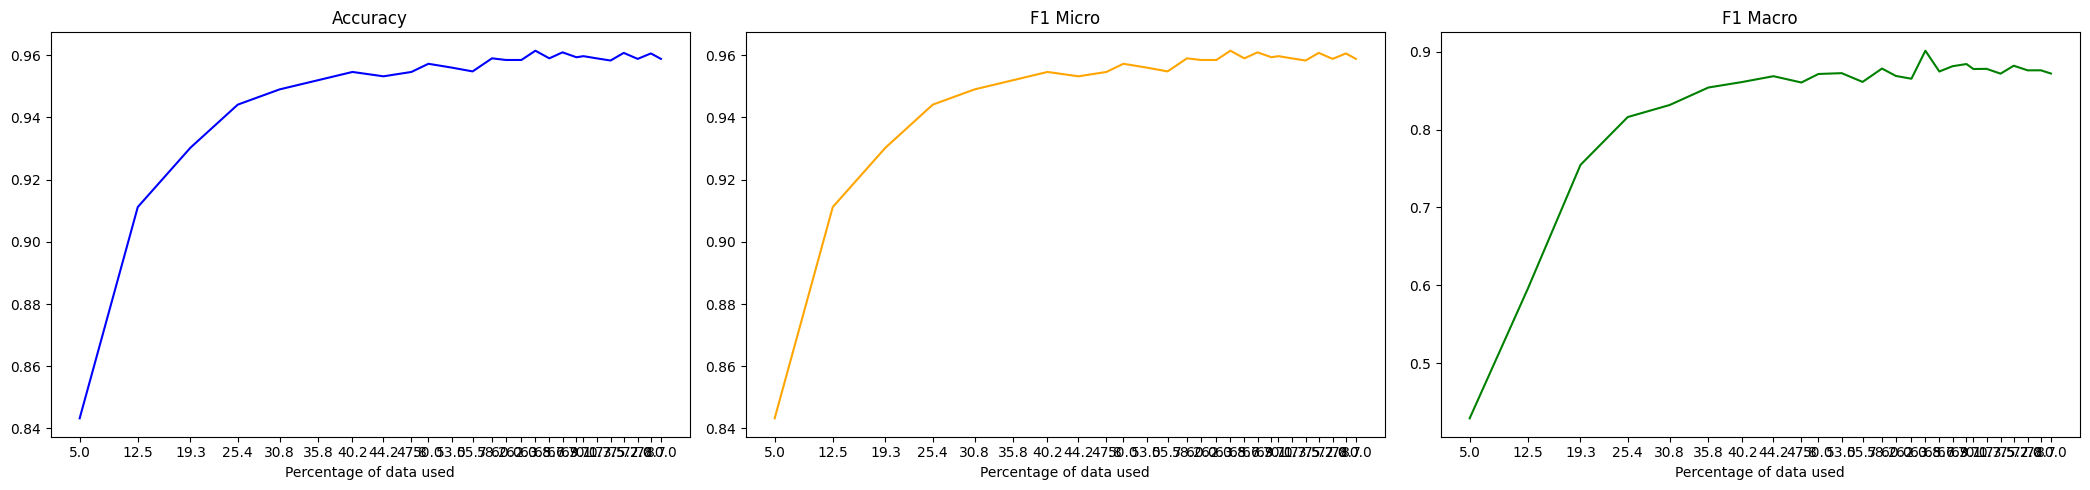

In [ ]:
active_learning(seeds[4], 4)